In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from collections import deque
import random

def generate_grid(m, n, p):
    return (np.random.rand(m, n) < p).astype(int)

def BFS_algorithm(grid):
    m, n = grid.shape
    visited = np.zeros((m, n), dtype=bool)
    queue = deque()
    for i in range(m):
        if grid[i, 0] == 1:
            queue.append((i, 0))
            visited[i, 0] = True
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    while queue:
        x, y = queue.popleft()
        if y == n - 1:
            return 1
        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            if 0 <= nx < m and 0 <= ny < n and not visited[nx, ny] and grid[nx, ny] == 1:
                visited[nx, ny] = True
                queue.append((nx, ny))
    return 0

def visualize_grid(labeled_grid, percolation, percolating_labels, figsize=(10, 10), show_all=False):
    m, n = labeled_grid.shape
    unique_labels = np.unique(labeled_grid)
    cluster_labels = unique_labels[unique_labels != 0]
    num_clusters = len(cluster_labels)

    if show_all:
        label_map = {label: i + 1 for i, label in enumerate(cluster_labels)}
        label_map[0] = 0
        color_grid = np.vectorize(label_map.get)(labeled_grid)

        if num_clusters <= 20:
            colors = [plt.cm.tab20(i) for i in range(num_clusters)]
        else:
            colors = [plt.cm.nipy_spectral(i / num_clusters) for i in range(num_clusters)]
        random.shuffle(colors)
        cmap = ListedColormap(['white'] + colors)
    else:
        percolating_labels = set(percolating_labels)
        non_percolating_labels = [label for label in cluster_labels if label not in percolating_labels]

        color_grid = np.zeros_like(labeled_grid, dtype=int)
        color_index = 2

        for label in non_percolating_labels:
            color_grid[labeled_grid == label] = 1

        label_to_color = {}
        for label in percolating_labels:
            label_to_color[label] = color_index
            color_grid[labeled_grid == label] = color_index
            color_index += 1

        num_percolating = len(percolating_labels)
        if num_percolating <= 20:
            percolating_colors = [plt.cm.tab20(i) for i in range(num_percolating)]
        else:
            percolating_colors = [plt.cm.nipy_spectral(i / num_percolating) for i in range(num_percolating)]
        random.shuffle(percolating_colors)

        colors = ['white', 'black'] + percolating_colors
        cmap = ListedColormap(colors)

    plt.figure(figsize=figsize, dpi=300)
    plt.imshow(color_grid, cmap=cmap, interpolation='nearest')
    plt.title("Percolation Detected" if percolation else "No Percolation", fontsize=16)
    plt.axis('off')
    plt.savefig(f"percolation_visualization_{'all' if show_all else 'percolating'}_{m}x{n}.png", dpi=300, bbox_inches='tight')
    plt.show()

def coloring_algorithm(grid, visualize=False, show_all=False):
    m, n = grid.shape
    
    colored_grid = np.zeros((m, n), dtype=int)
    
    color = 2
    max_color = color 
    
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    
    for i in range(m):
        for j in range(n):
            if grid[i, j] == 0:
                continue
                
            if colored_grid[i, j] > 0:
                continue
                
            neighbor_colors = set()
            non_zero_neighbor = False
            
            for dx, dy in directions:
                nx, ny = i + dx, j + dy
                if 0 <= nx < m and 0 <= ny < n:
                    if colored_grid[nx, ny] > 0:
                        neighbor_colors.add(colored_grid[nx, ny])
                        non_zero_neighbor = True
            
            if not non_zero_neighbor:
                colored_grid[i, j] = color
                max_color = max(max_color, color)
                color += 1
            else:
                if len(neighbor_colors) == 1:
                    colored_grid[i, j] = list(neighbor_colors)[0]
                else:
                    min_color = min(neighbor_colors)
                    colored_grid[i, j] = min_color
                    
                    color_change_list = {}
                    for c in neighbor_colors:
                        if c != min_color:
                            color_change_list[c] = min_color
                    
                    for ci in range(m):
                        for cj in range(n):
                            if colored_grid[ci, cj] in color_change_list:
                                colored_grid[ci, cj] = color_change_list[colored_grid[ci, cj]]
    
    percolation, percolating_labels = check_percolation(colored_grid, m, n)
    
    if visualize:
        visualize_grid(colored_grid, percolation, percolating_labels, show_all=show_all)
    
    return colored_grid, int(percolation)

def check_percolation(labeled_grid, m, n):
    left_edge = labeled_grid[:, 0]
    right_edge = labeled_grid[:, n-1]
    left_labels = set(left_edge[left_edge != 0])
    right_labels = set(right_edge[right_edge != 0])
    percolating_labels = left_labels.intersection(right_labels)
    percolation = len(percolating_labels) > 0
    return percolation, percolating_labels

def hoshen_kopelman_algorithm(grid, visualize=False, show_all=False):
    m, n = grid.shape
    if not np.all(np.logical_or(grid == 0, grid == 1)):
        raise ValueError("Grid must contain only 0s and 1s.")

    labels = np.zeros((m, n), dtype=int)
    label_map = {}
    next_label = 1

    def find(label):
        while label_map[label] != label:
            label = label_map[label]
        return label

    def union(label1, label2):
        root1 = find(label1)
        root2 = find(label2)
        if root1 != root2:
            label_map[root1] = root2

    for i in range(m):
        for j in range(n):
            if grid[i, j] == 1:
                left = labels[i, j-1] if j > 0 else 0
                up = labels[i-1, j] if i > 0 else 0
                if left == 0 and up == 0:
                    labels[i, j] = next_label
                    label_map[next_label] = next_label
                    next_label += 1
                elif left == 0:
                    labels[i, j] = up
                elif up == 0:
                    labels[i, j] = left
                else:
                    labels[i, j] = min(left, up)
                    union(left, up)

    for i in range(m):
        for j in range(n):
            if labels[i, j] != 0:
                labels[i, j] = find(labels[i, j])

    percolation, percolating_labels = check_percolation(labels, m, n)
    if visualize:
        visualize_grid(labels, percolation, percolating_labels, show_all=show_all)
    else:
        return labels, int(percolation)

def estimate_p_c(grid_sizes, num_samples=100, p_values=np.linspace(0, 1, 30), algorithm="hoshen_kopelman", show_error_bars=True, confidence_level=95):
    plot_colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    plt.figure(figsize=(12, 8), dpi=300)

    z_score = {
        80: 1.282,
        85: 1.440,
        90: 1.645,
        95: 1.96,
        98: 2.326,
        99: 2.576,
        99.5: 2.807,
        99.9: 3.291
    }
    supported_levels = list(z_score.keys())
    if confidence_level not in supported_levels:
        print(f"Warning: Confidence level {confidence_level}% not in {supported_levels}. Using 95% (Z=1.96) as default.")
        confidence_level = 95
    z_value = z_score[confidence_level]

    for idx, (m, n) in enumerate(grid_sizes):
        percolation_probs = []
        percolation_stds = []
        for p in p_values:
            percolation_count = 0
            for _ in range(num_samples):
                grid = generate_grid(m, n, p)
                if algorithm == "hoshen_kopelman":
                    percolation_count += hoshen_kopelman_algorithm(grid)[1]
                elif algorithm == "coloring":
                    percolation_count += coloring_algorithm(grid)[1]
                elif algorithm == "BFS":
                    percolation_count += BFS_algorithm(grid)
            prob = percolation_count / num_samples
            percolation_probs.append(prob)
            std = np.sqrt(prob * (1 - prob) / num_samples) if prob > 0 and prob < 1 else 0
            percolation_stds.append(std)

        color = plot_colors[idx % len(plot_colors)]
        if show_error_bars:
            plt.errorbar(p_values, percolation_probs, yerr=percolation_stds, color=color,
                         capsize=3, label=f'm={m}, n={n}', linestyle='-')
        else:
            plt.plot(p_values, percolation_probs, color=color,
                     label=f'm={m}, n={n}', linestyle='-')

        avg_q = np.mean(percolation_probs)
        se_q = np.sqrt(avg_q * (1 - avg_q) / num_samples) if avg_q > 0 and avg_q < 1 else 0
        ci_lower = max(0, avg_q - z_value * se_q)
        ci_upper = min(1, avg_q + z_value * se_q)
        print(f"Grid size (m={m}, n={n}): Average Q = {avg_q:.4f}, "
              f"{confidence_level}% CI = [{ci_lower:.4f}, {ci_upper:.4f}]")

    all_square = all(m == n for m, n in grid_sizes)
    if all_square:
        plt.axvline(x=0.5927, color='r', linestyle='--', label=r'Theoretical $p_c \approx 0.5927$')

    plt.xlabel('Probability $p$', fontsize=12)
    plt.ylabel('$Q$ (Probability of Infinite Cluster)', fontsize=12)
    plt.title('$Q$ as a Function of $p$ for Different Grid Sizes', fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.savefig("percolation_plot_Q_vs_p.png", dpi=300, bbox_inches='tight')
    plt.show()

Hoshen-Kopelman Algorithm (show_all=True):


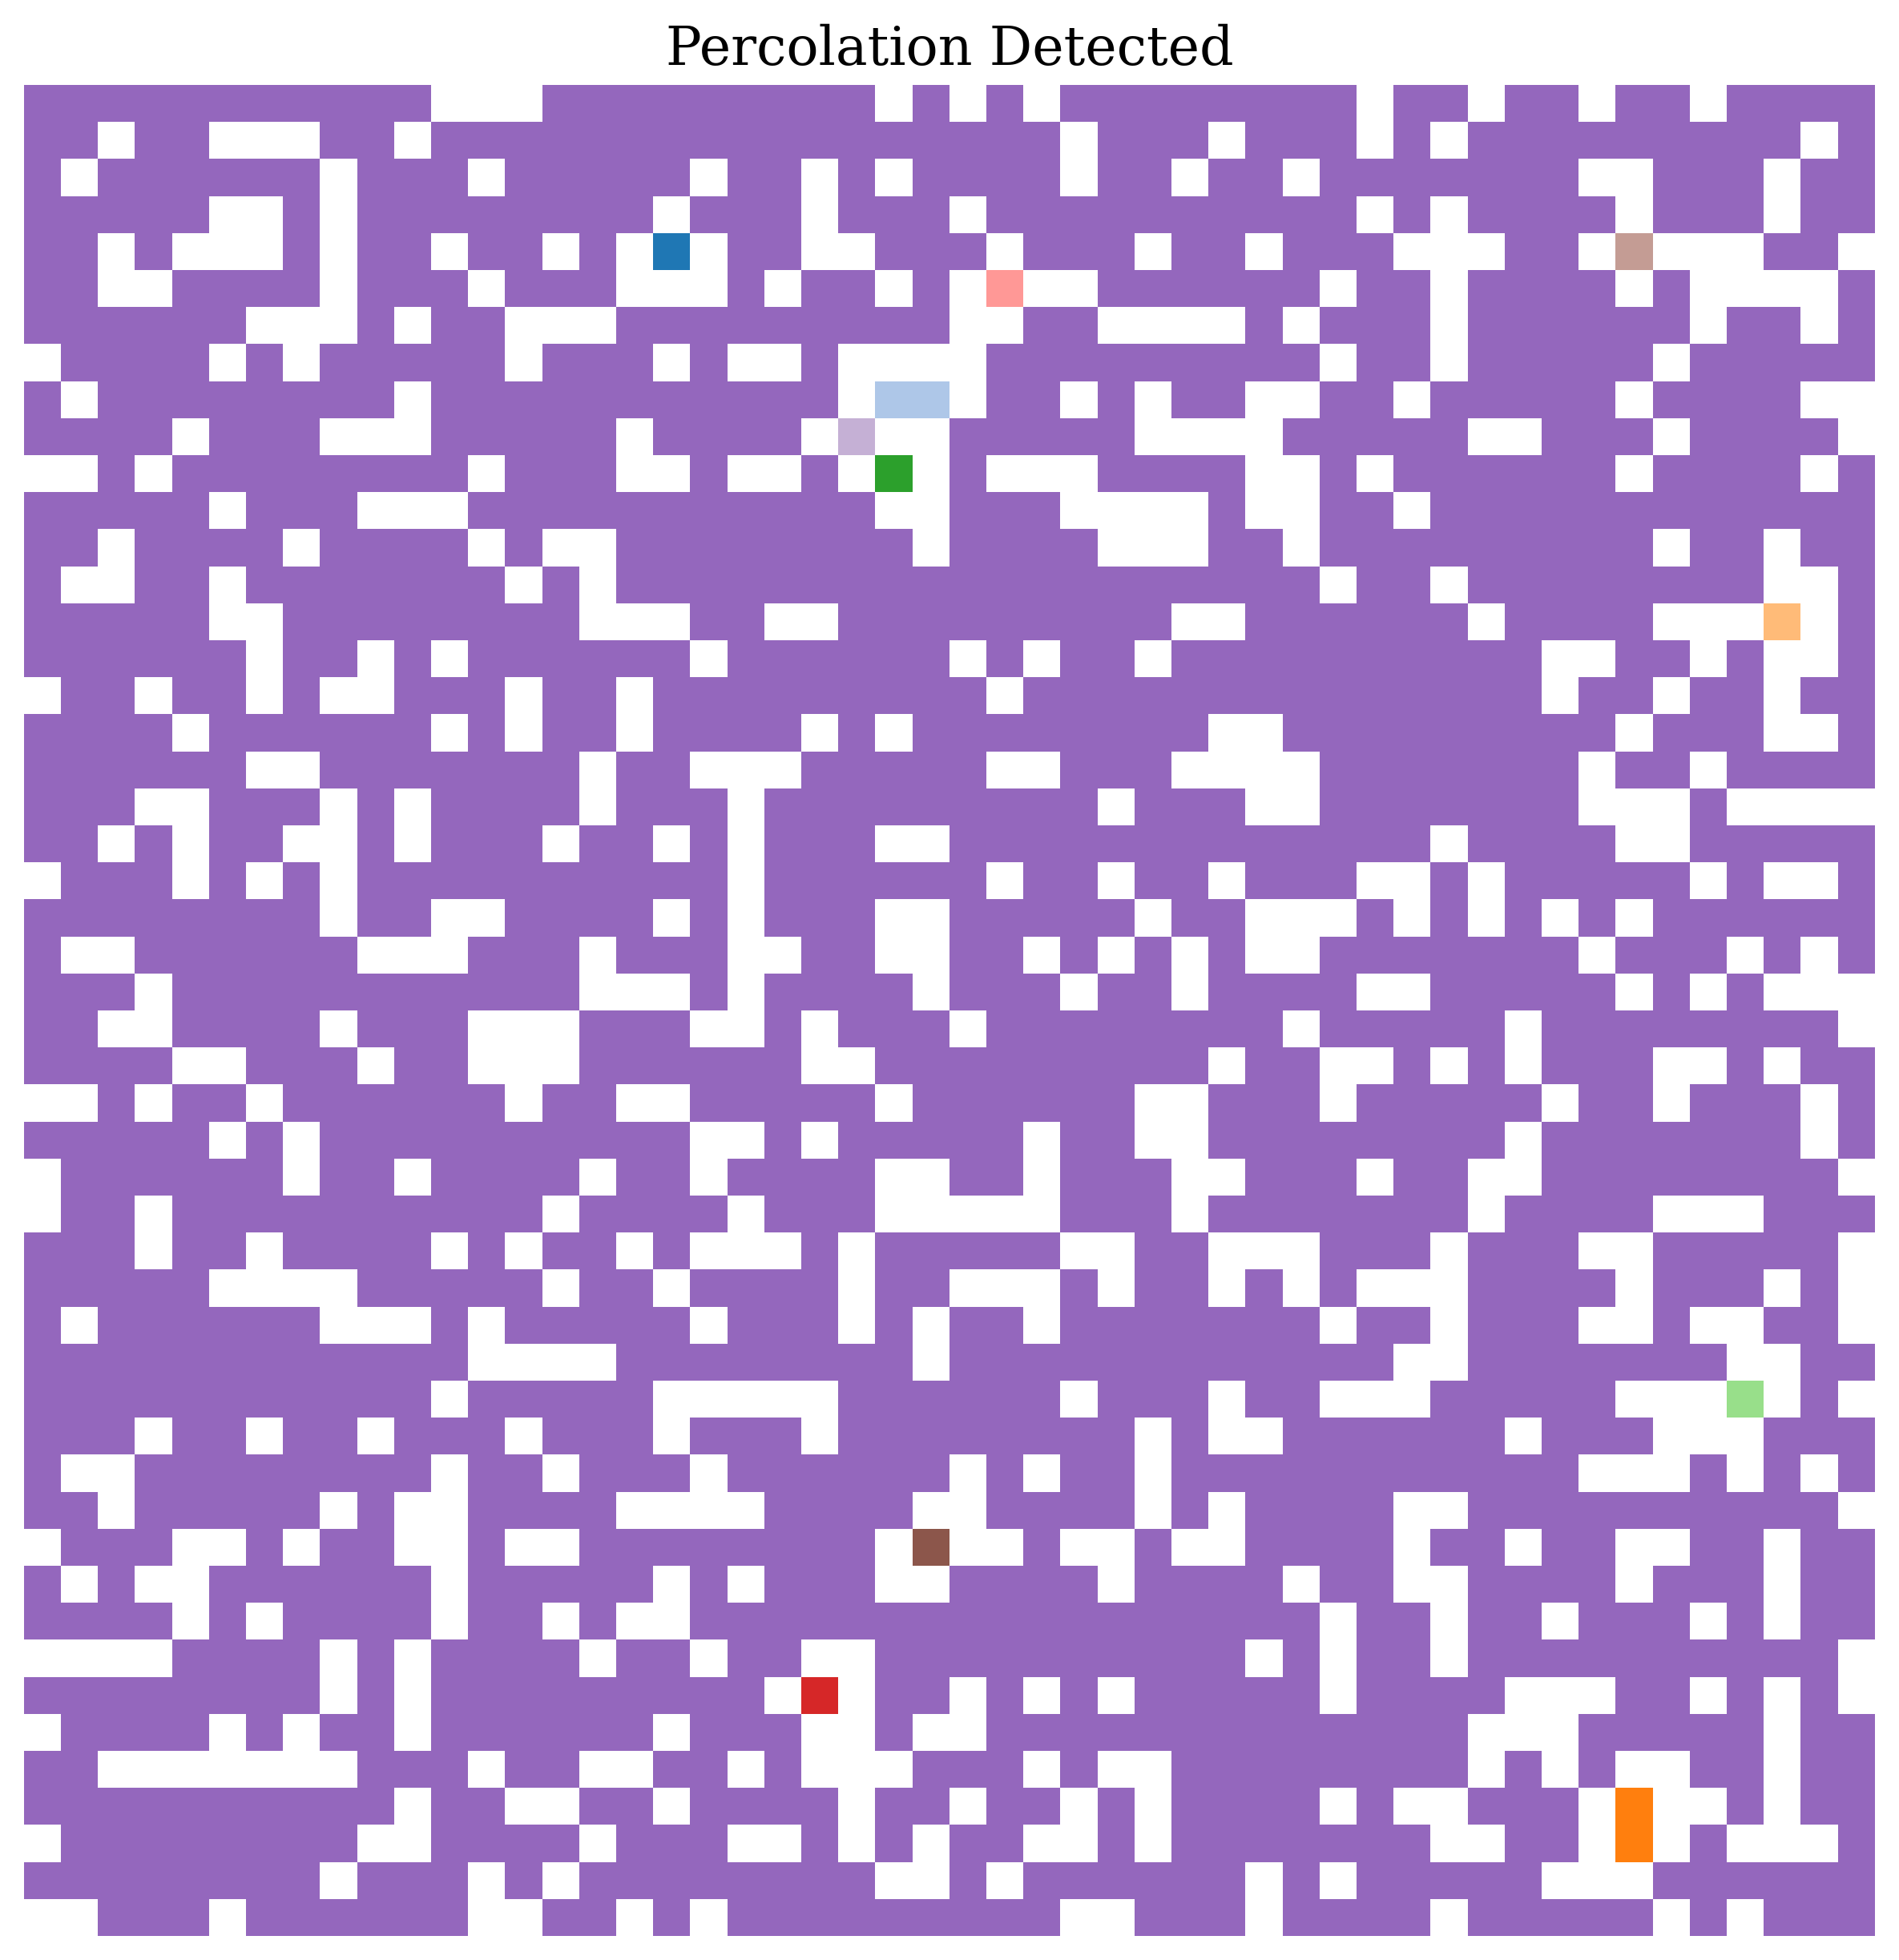

Hoshen-Kopelman Algorithm (show_all=False):


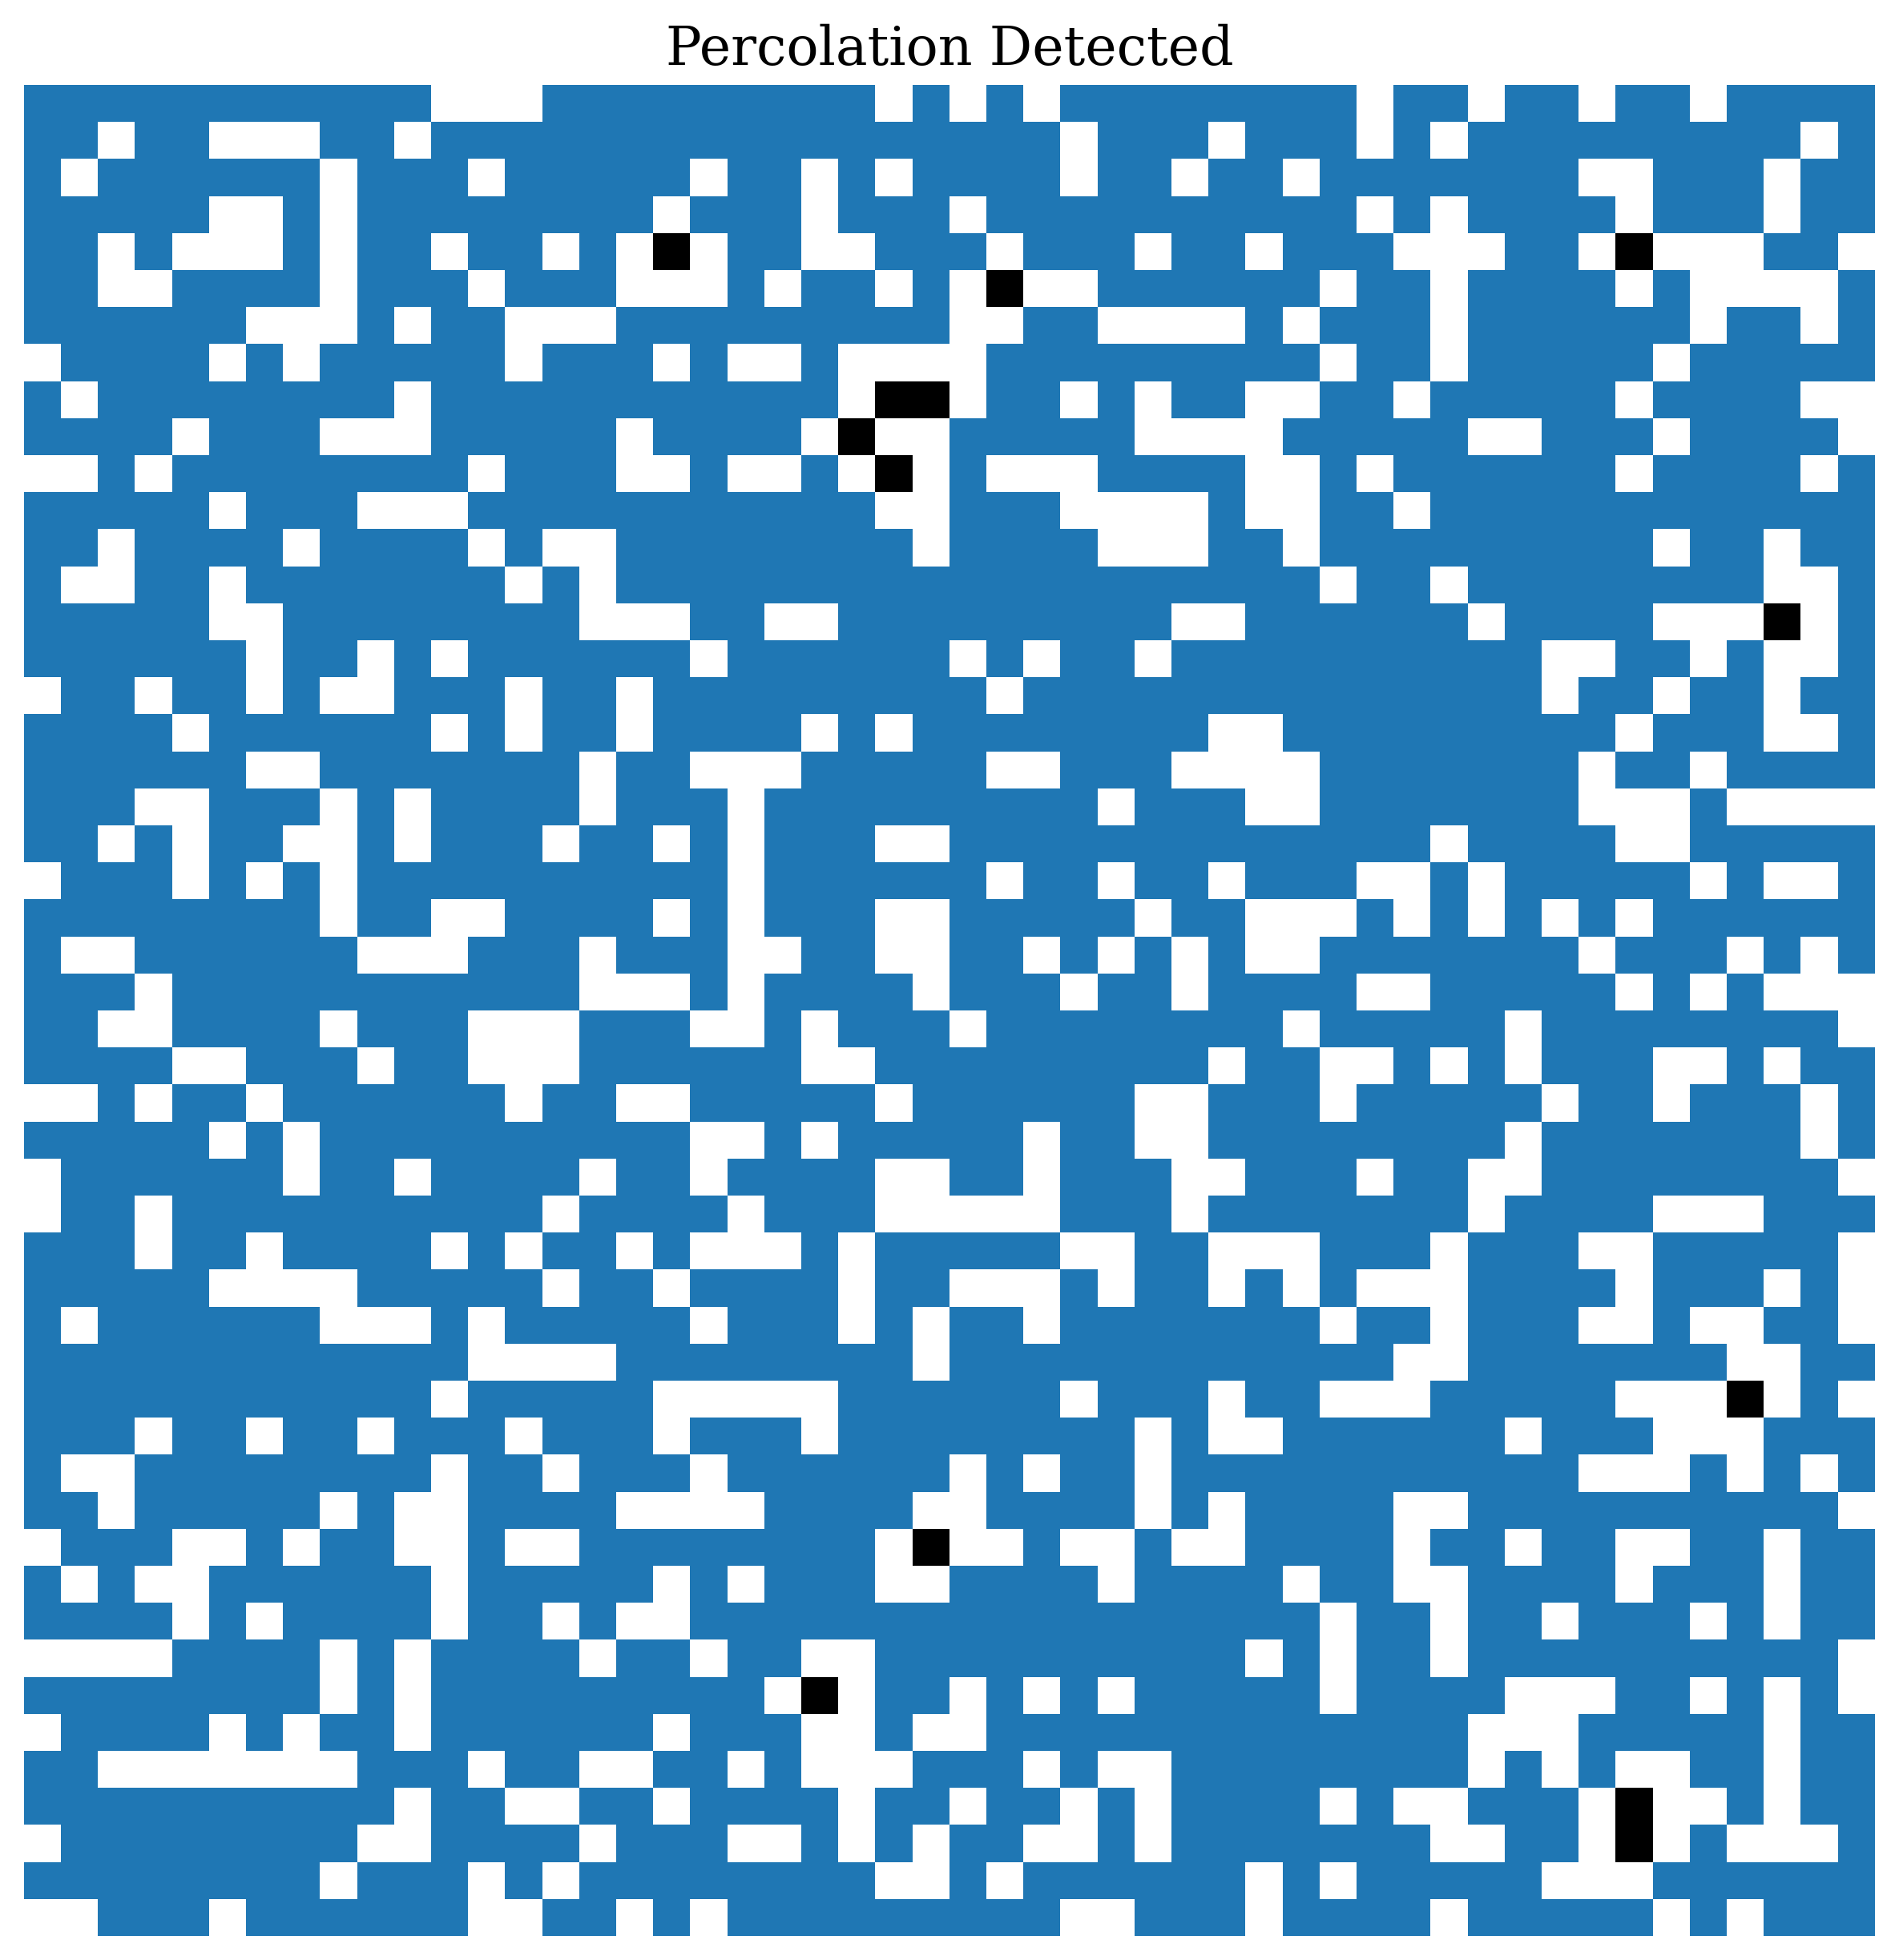

Coloring Algorithm (show_all=True):


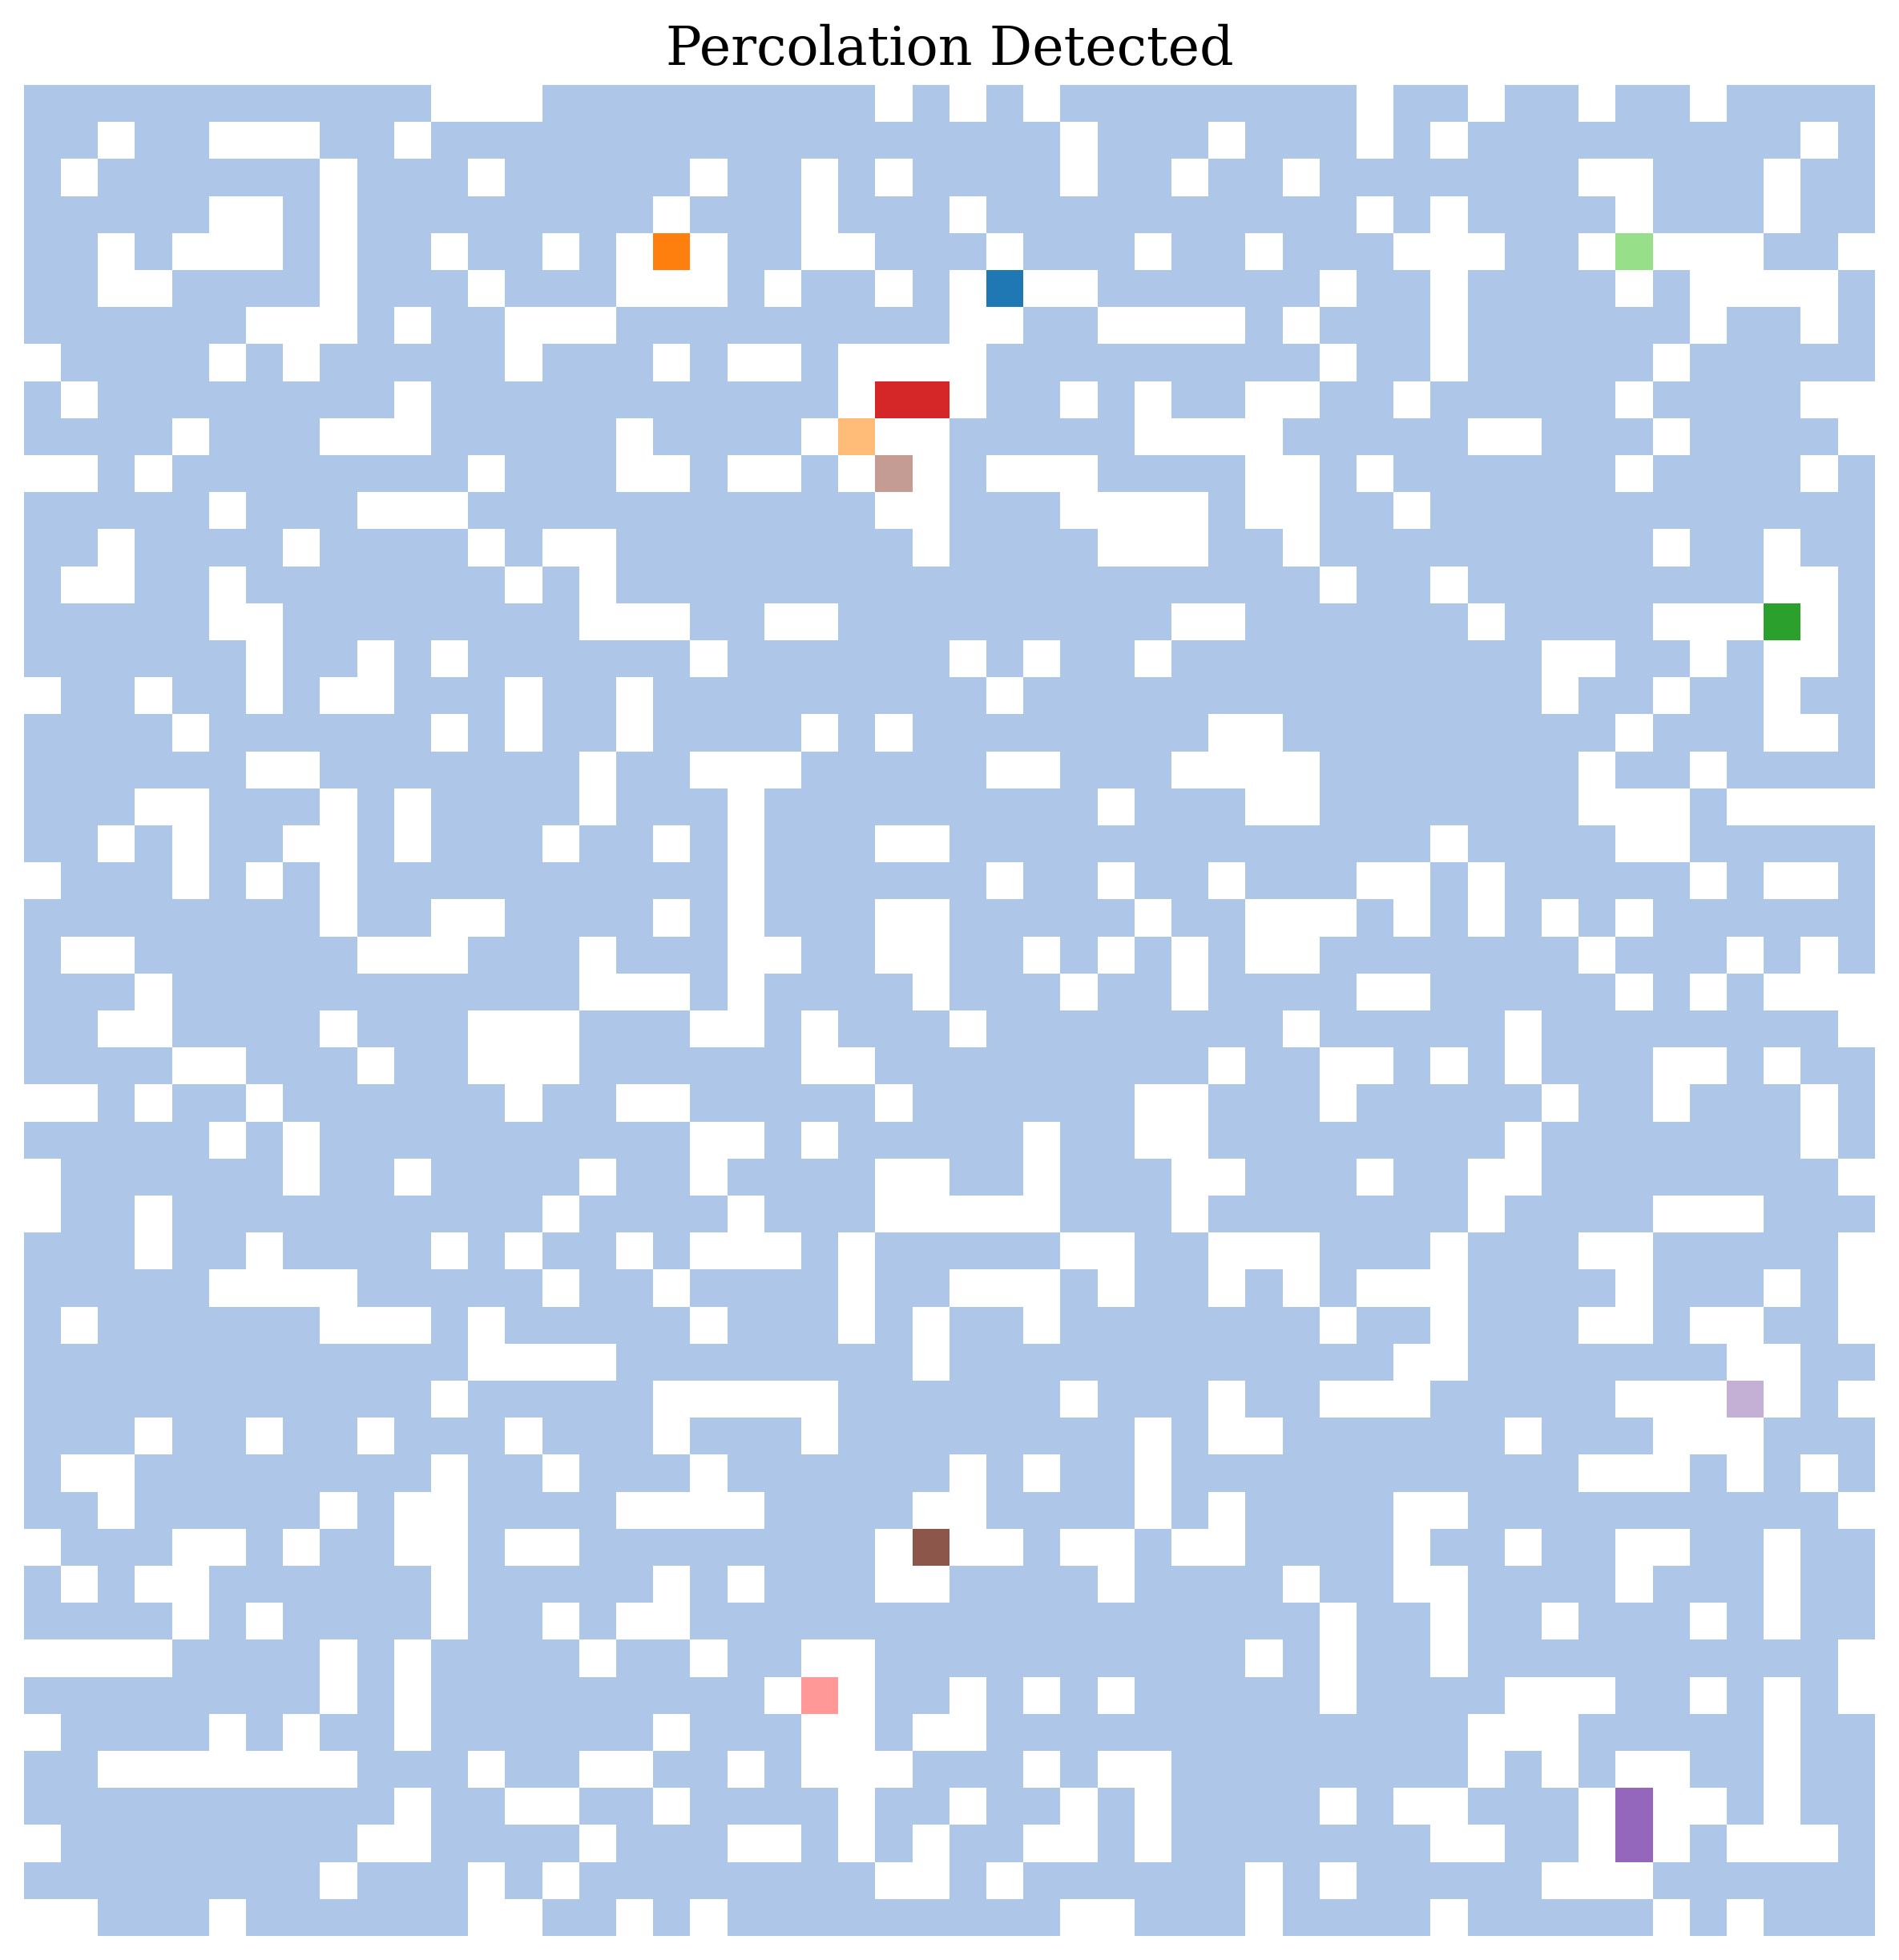

Coloring Algorithm (show_all=False):


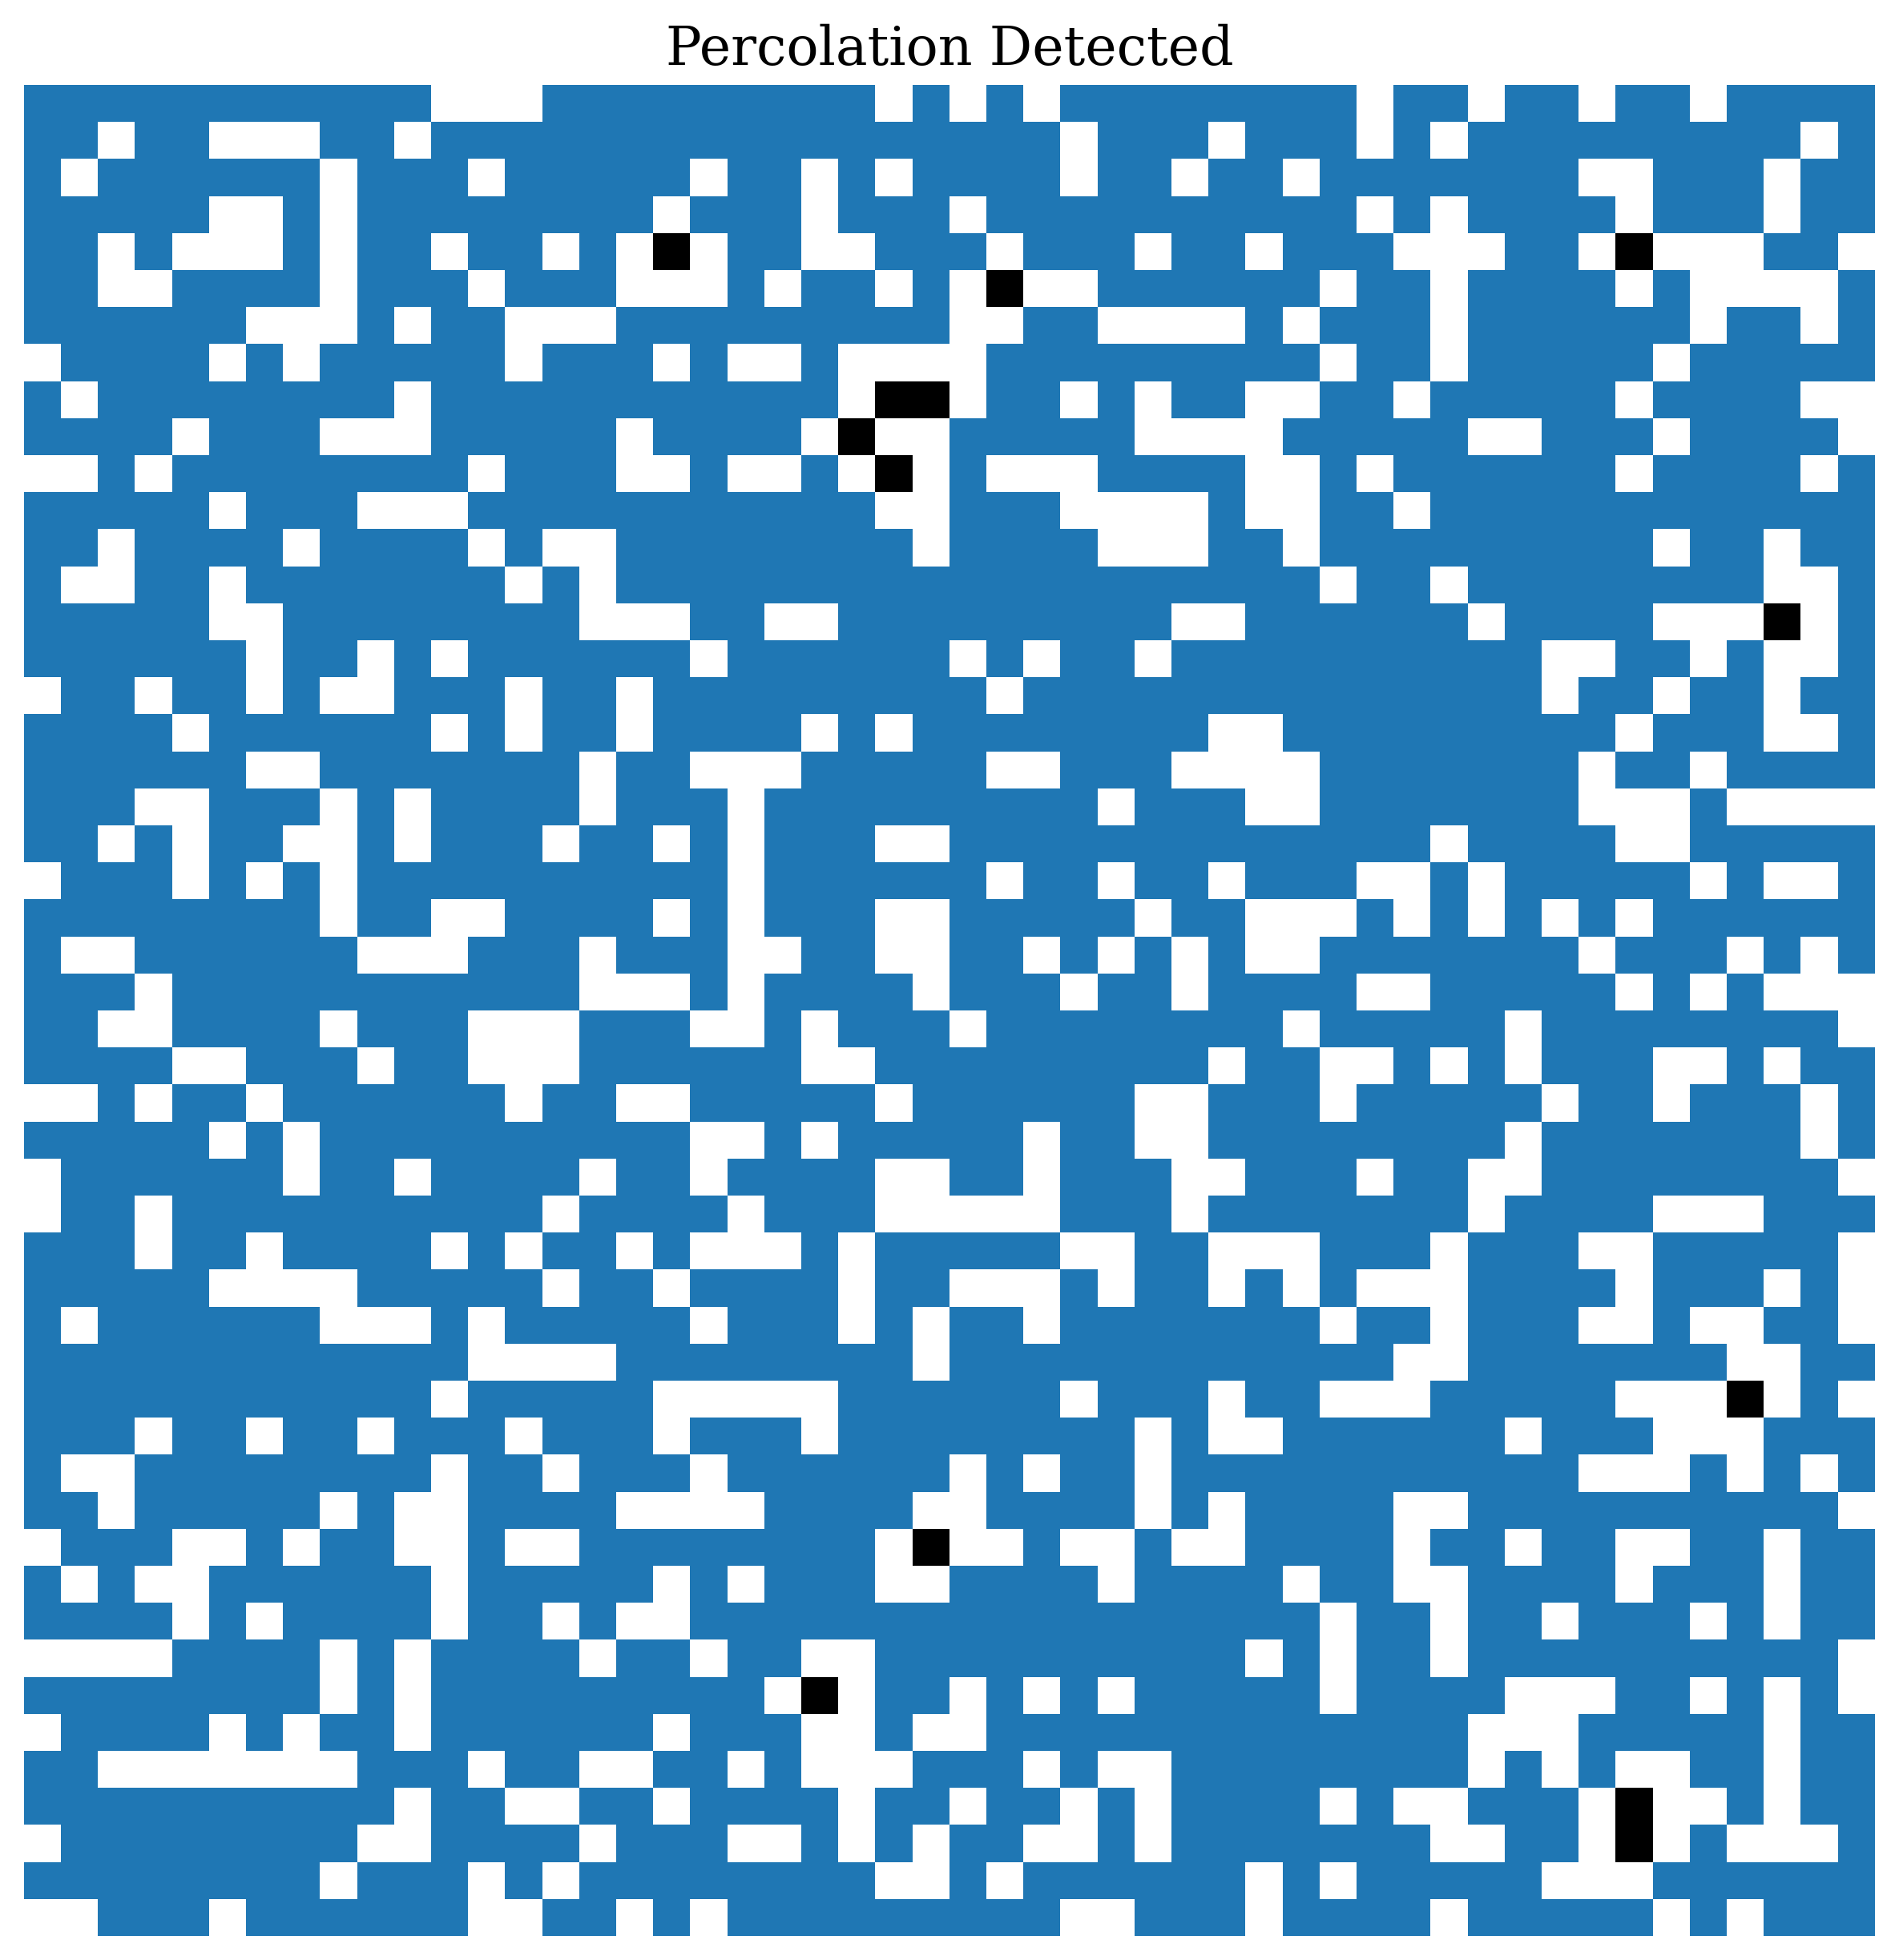

(array([[2, 2, 2, ..., 2, 2, 2],
        [2, 2, 0, ..., 2, 0, 2],
        [2, 0, 2, ..., 0, 2, 2],
        ...,
        [0, 2, 2, ..., 0, 0, 2],
        [2, 2, 2, ..., 2, 2, 2],
        [0, 0, 2, ..., 2, 2, 2]]),
 1)

In [698]:
m, n = 50, 50
p = 0.7
grid = generate_grid(m, n, p)
print("Hoshen-Kopelman Algorithm (show_all=True):")
hoshen_kopelman_algorithm(grid, visualize=True, show_all=True)
print("Hoshen-Kopelman Algorithm (show_all=False):")
hoshen_kopelman_algorithm(grid, visualize=True, show_all=False)
print("Coloring Algorithm (show_all=True):")
coloring_algorithm(grid, visualize=True, show_all=True)
print("Coloring Algorithm (show_all=False):")
coloring_algorithm(grid, visualize=True, show_all=False)

Grid size (m=10, n=10): Average Q = 0.4186, 99.9% CI = [0.2562, 0.5810]
Grid size (m=20, n=20): Average Q = 0.4119, 99.9% CI = [0.2499, 0.5739]
Grid size (m=30, n=30): Average Q = 0.4089, 99.9% CI = [0.2471, 0.5707]
Grid size (m=40, n=40): Average Q = 0.4097, 99.9% CI = [0.2479, 0.5715]
Grid size (m=50, n=50): Average Q = 0.4081, 99.9% CI = [0.2464, 0.5698]
Grid size (m=200, n=200): Average Q = 0.4085, 99.9% CI = [0.2467, 0.5703]


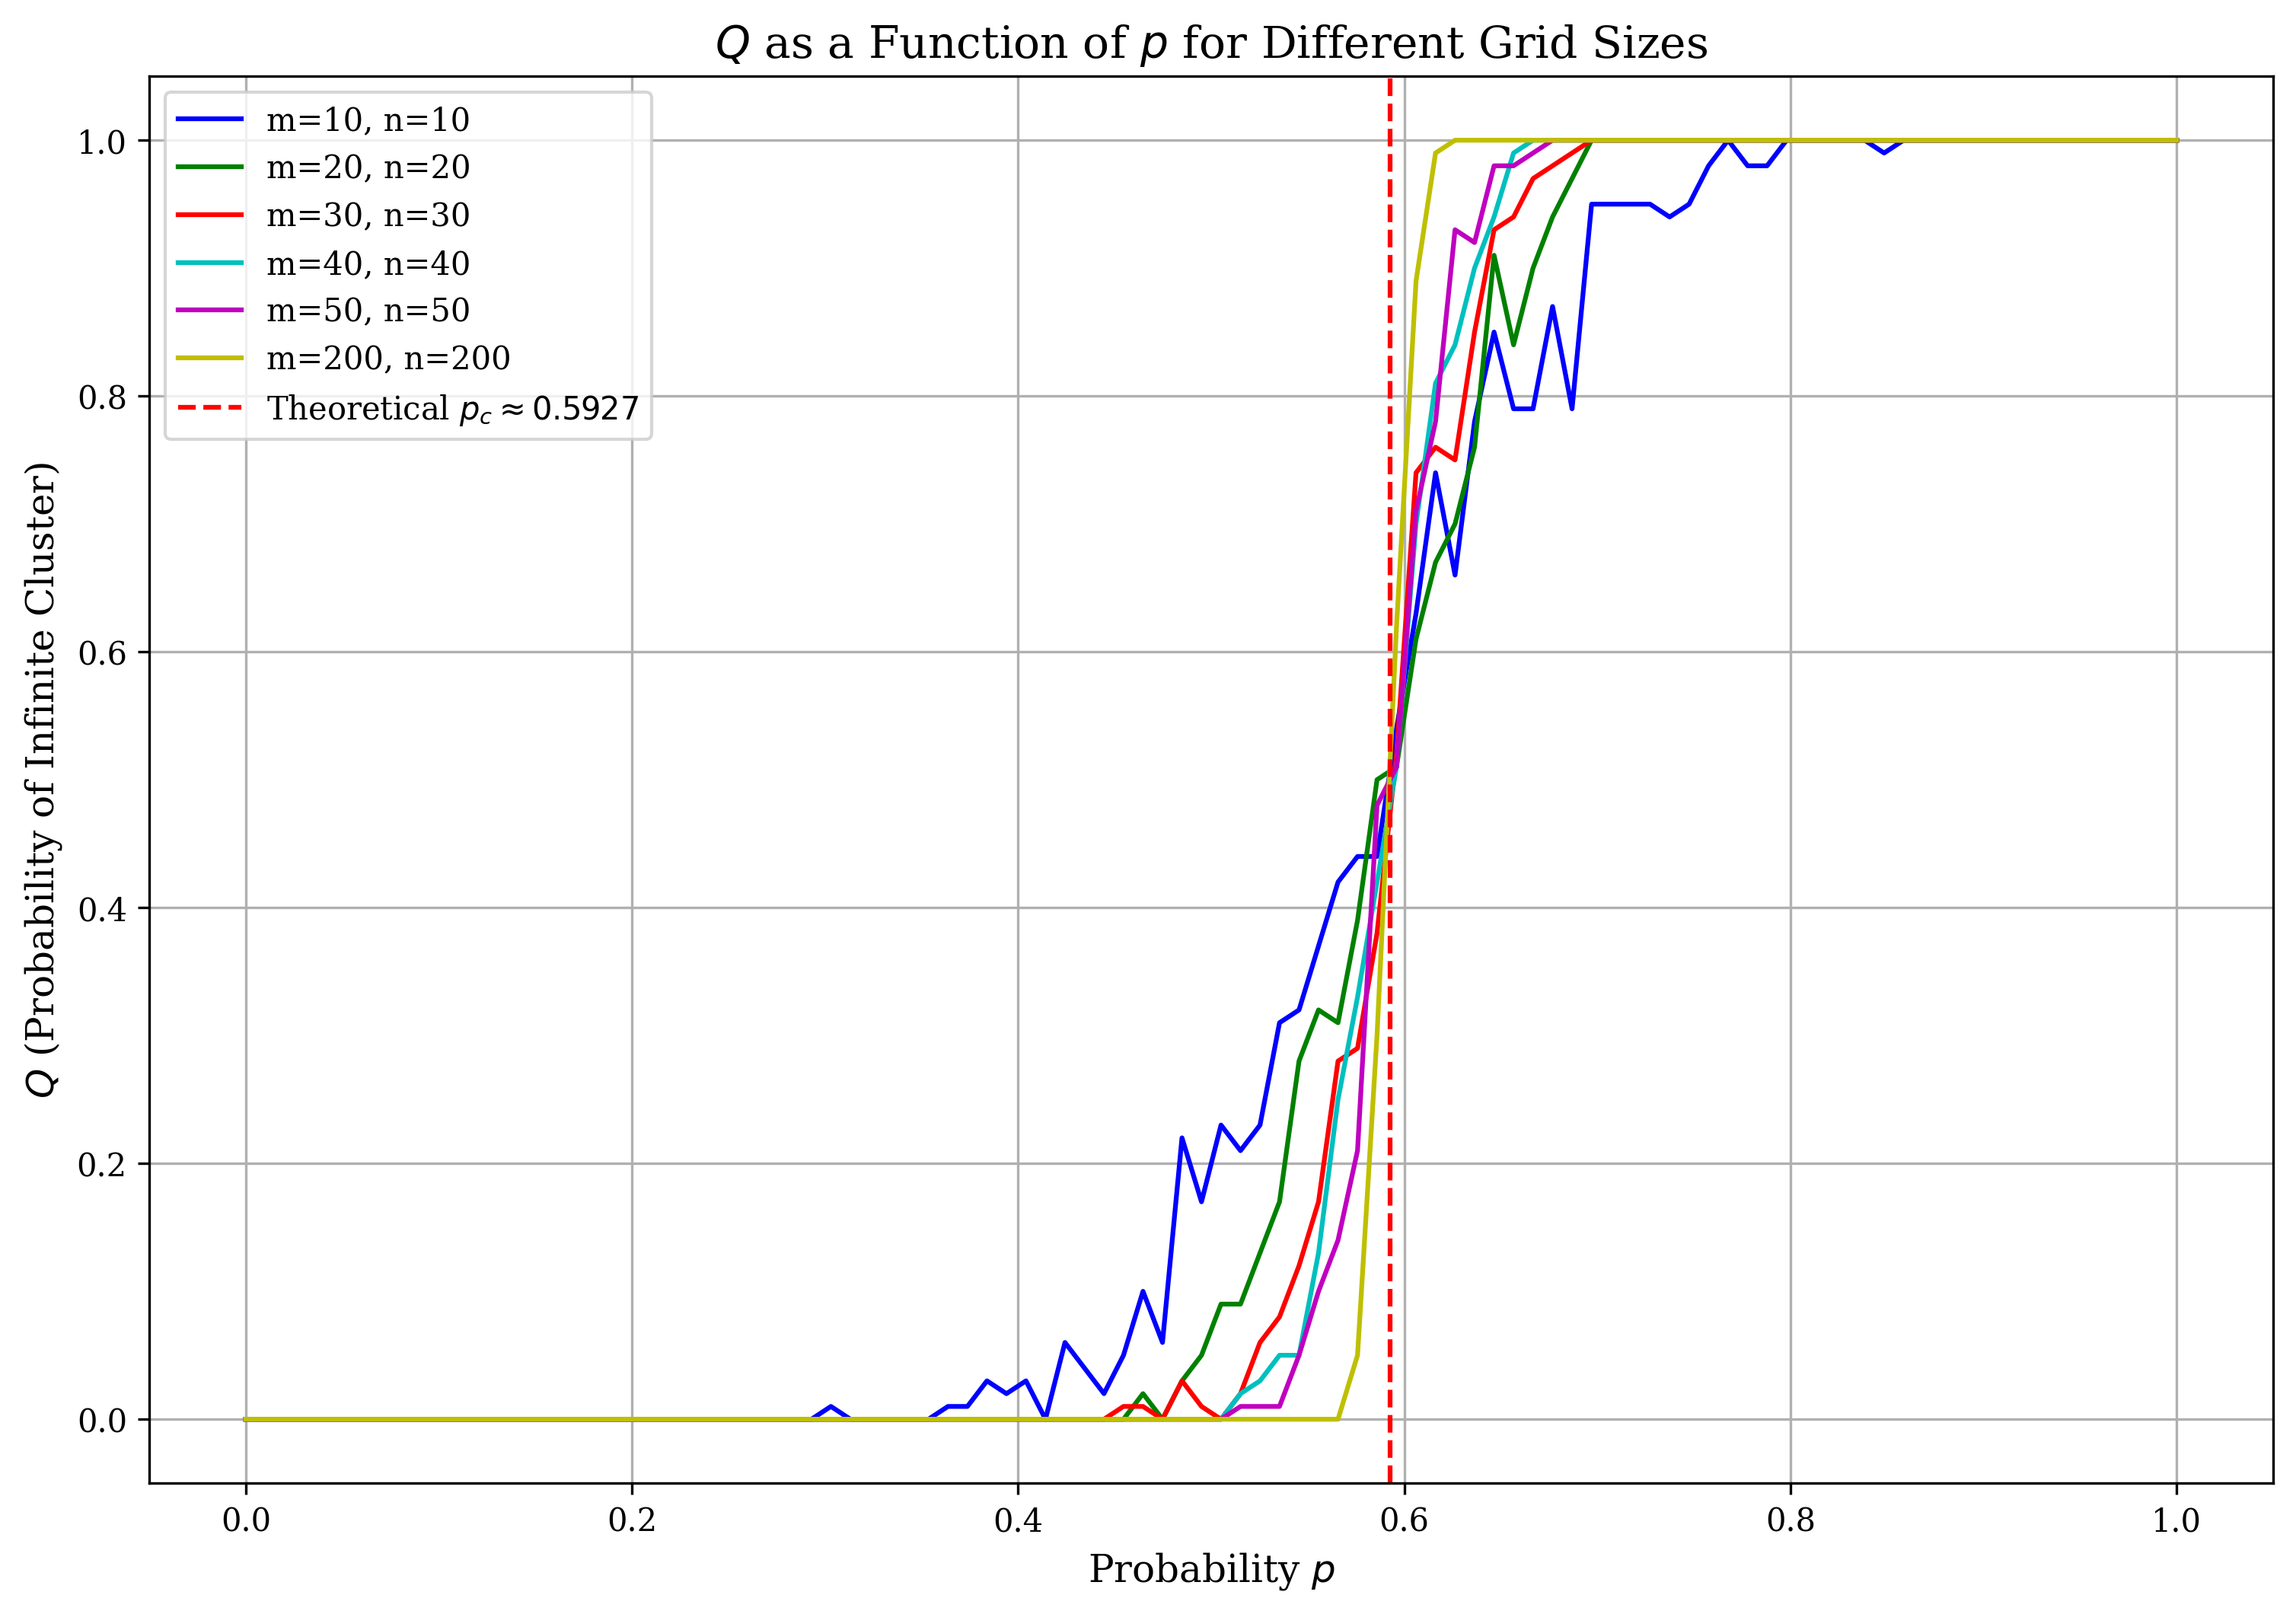

In [653]:
grid_sizes = [(10, 10), (20, 20), (30, 30), (40, 40), (50, 50), (200, 200)]
estimate_p_c(grid_sizes, num_samples=100, p_values=np.linspace(0, 1, 100), algorithm="BFS", show_error_bars=False, confidence_level=99.9)

In [ ]:
from scipy.ndimage import label

def identify_clusters(grid):
    #labeled_grid, _ = hoshen_kopelman_algorithm(grid)
    ## for faster results
    labeled_grid, _ = label(grid)
    return labeled_grid

def estimate_Q_infty(grid_sizes, num_samples=100, p_values=np.linspace(0, 1, 30), num_trials=100):
    plot_colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    
    results = {
        "avg_q_infty": {},
        "std_q_infty": {},
        "q_infty_values": {}
    }

    plt.figure(figsize=(12, 8), dpi=300)

    for idx, (m, n) in enumerate(grid_sizes):
        q_infty_values = []
        for p in p_values:
            q_infty_count = 0
            for _ in range(num_samples):
                grid = generate_grid(m, n, p)
                labeled_grid = identify_clusters(grid)
                percolation, percolating_labels = check_percolation(labeled_grid, m, n)

                if not percolation:
                    continue

                for _ in range(num_trials):
                    i = np.random.randint(0, m)
                    j = np.random.randint(0, n)
                    original_value = grid[i, j]
                    grid[i, j] = 1

                    new_labeled_grid = identify_clusters(grid)
                    new_percolation, new_percolating_labels = check_percolation(new_labeled_grid, m, n)

                    cell_label = new_labeled_grid[i, j]
                    if cell_label in new_percolating_labels:
                        q_infty_count += 1

                    grid[i, j] = original_value

            total_trials = num_samples * num_trials if percolation else 1
            q_infty = q_infty_count / total_trials if percolation else 0
            q_infty_values.append(q_infty)

        avg_q_infty = np.mean(q_infty_values)
        std_q_infty = np.std(q_infty_values)
        print(f"Grid size (m={m}, n={n}): Average Q_infty = {avg_q_infty:.4f} ± {std_q_infty:.4f}")
        
        results["avg_q_infty"][(m, n)] = avg_q_infty
        results["std_q_infty"][(m, n)] = std_q_infty
        results["q_infty_values"][(m, n)] = q_infty_values

        color = plot_colors[idx % len(plot_colors)]
        plt.plot(p_values, q_infty_values, color=color, linestyle='-', label=f'm={m}, n={n}')

    plt.xlabel('Probability $p$', fontsize=12)
    plt.ylabel('$Q_{\infty}$ (Probability of Joining Infinite Cluster)', fontsize=12)
    plt.title('$Q_{\infty}$ as a Function of $p$ for Different Grid Sizes', fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.savefig("Q_infty_vs_p_for_different_grid_sizes.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    return results

<>:65: SyntaxWarning: invalid escape sequence '\i'
<>:66: SyntaxWarning: invalid escape sequence '\i'
<>:65: SyntaxWarning: invalid escape sequence '\i'
<>:66: SyntaxWarning: invalid escape sequence '\i'
/var/folders/km/y1gjflc56rd069hf7r__rftc0000gn/T/ipykernel_5983/2345902562.py:65: SyntaxWarning: invalid escape sequence '\i'
  plt.ylabel('$Q_{\infty}$ (Probability of Joining Infinite Cluster)', fontsize=12)
/var/folders/km/y1gjflc56rd069hf7r__rftc0000gn/T/ipykernel_5983/2345902562.py:66: SyntaxWarning: invalid escape sequence '\i'
  plt.title('$Q_{\infty}$ as a Function of $p$ for Different Grid Sizes', fontsize=14)



Estimating Q_infty:
Grid size (m=10, n=10): Average Q_infty = 0.3457 ± 0.4458
Grid size (m=20, n=20): Average Q_infty = 0.3783 ± 0.4543
Grid size (m=30, n=30): Average Q_infty = 0.3787 ± 0.4632
Grid size (m=40, n=40): Average Q_infty = 0.3781 ± 0.4680
Grid size (m=50, n=50): Average Q_infty = 0.3729 ± 0.4699
Grid size (m=200, n=200): Average Q_infty = 0.3926 ± 0.4767


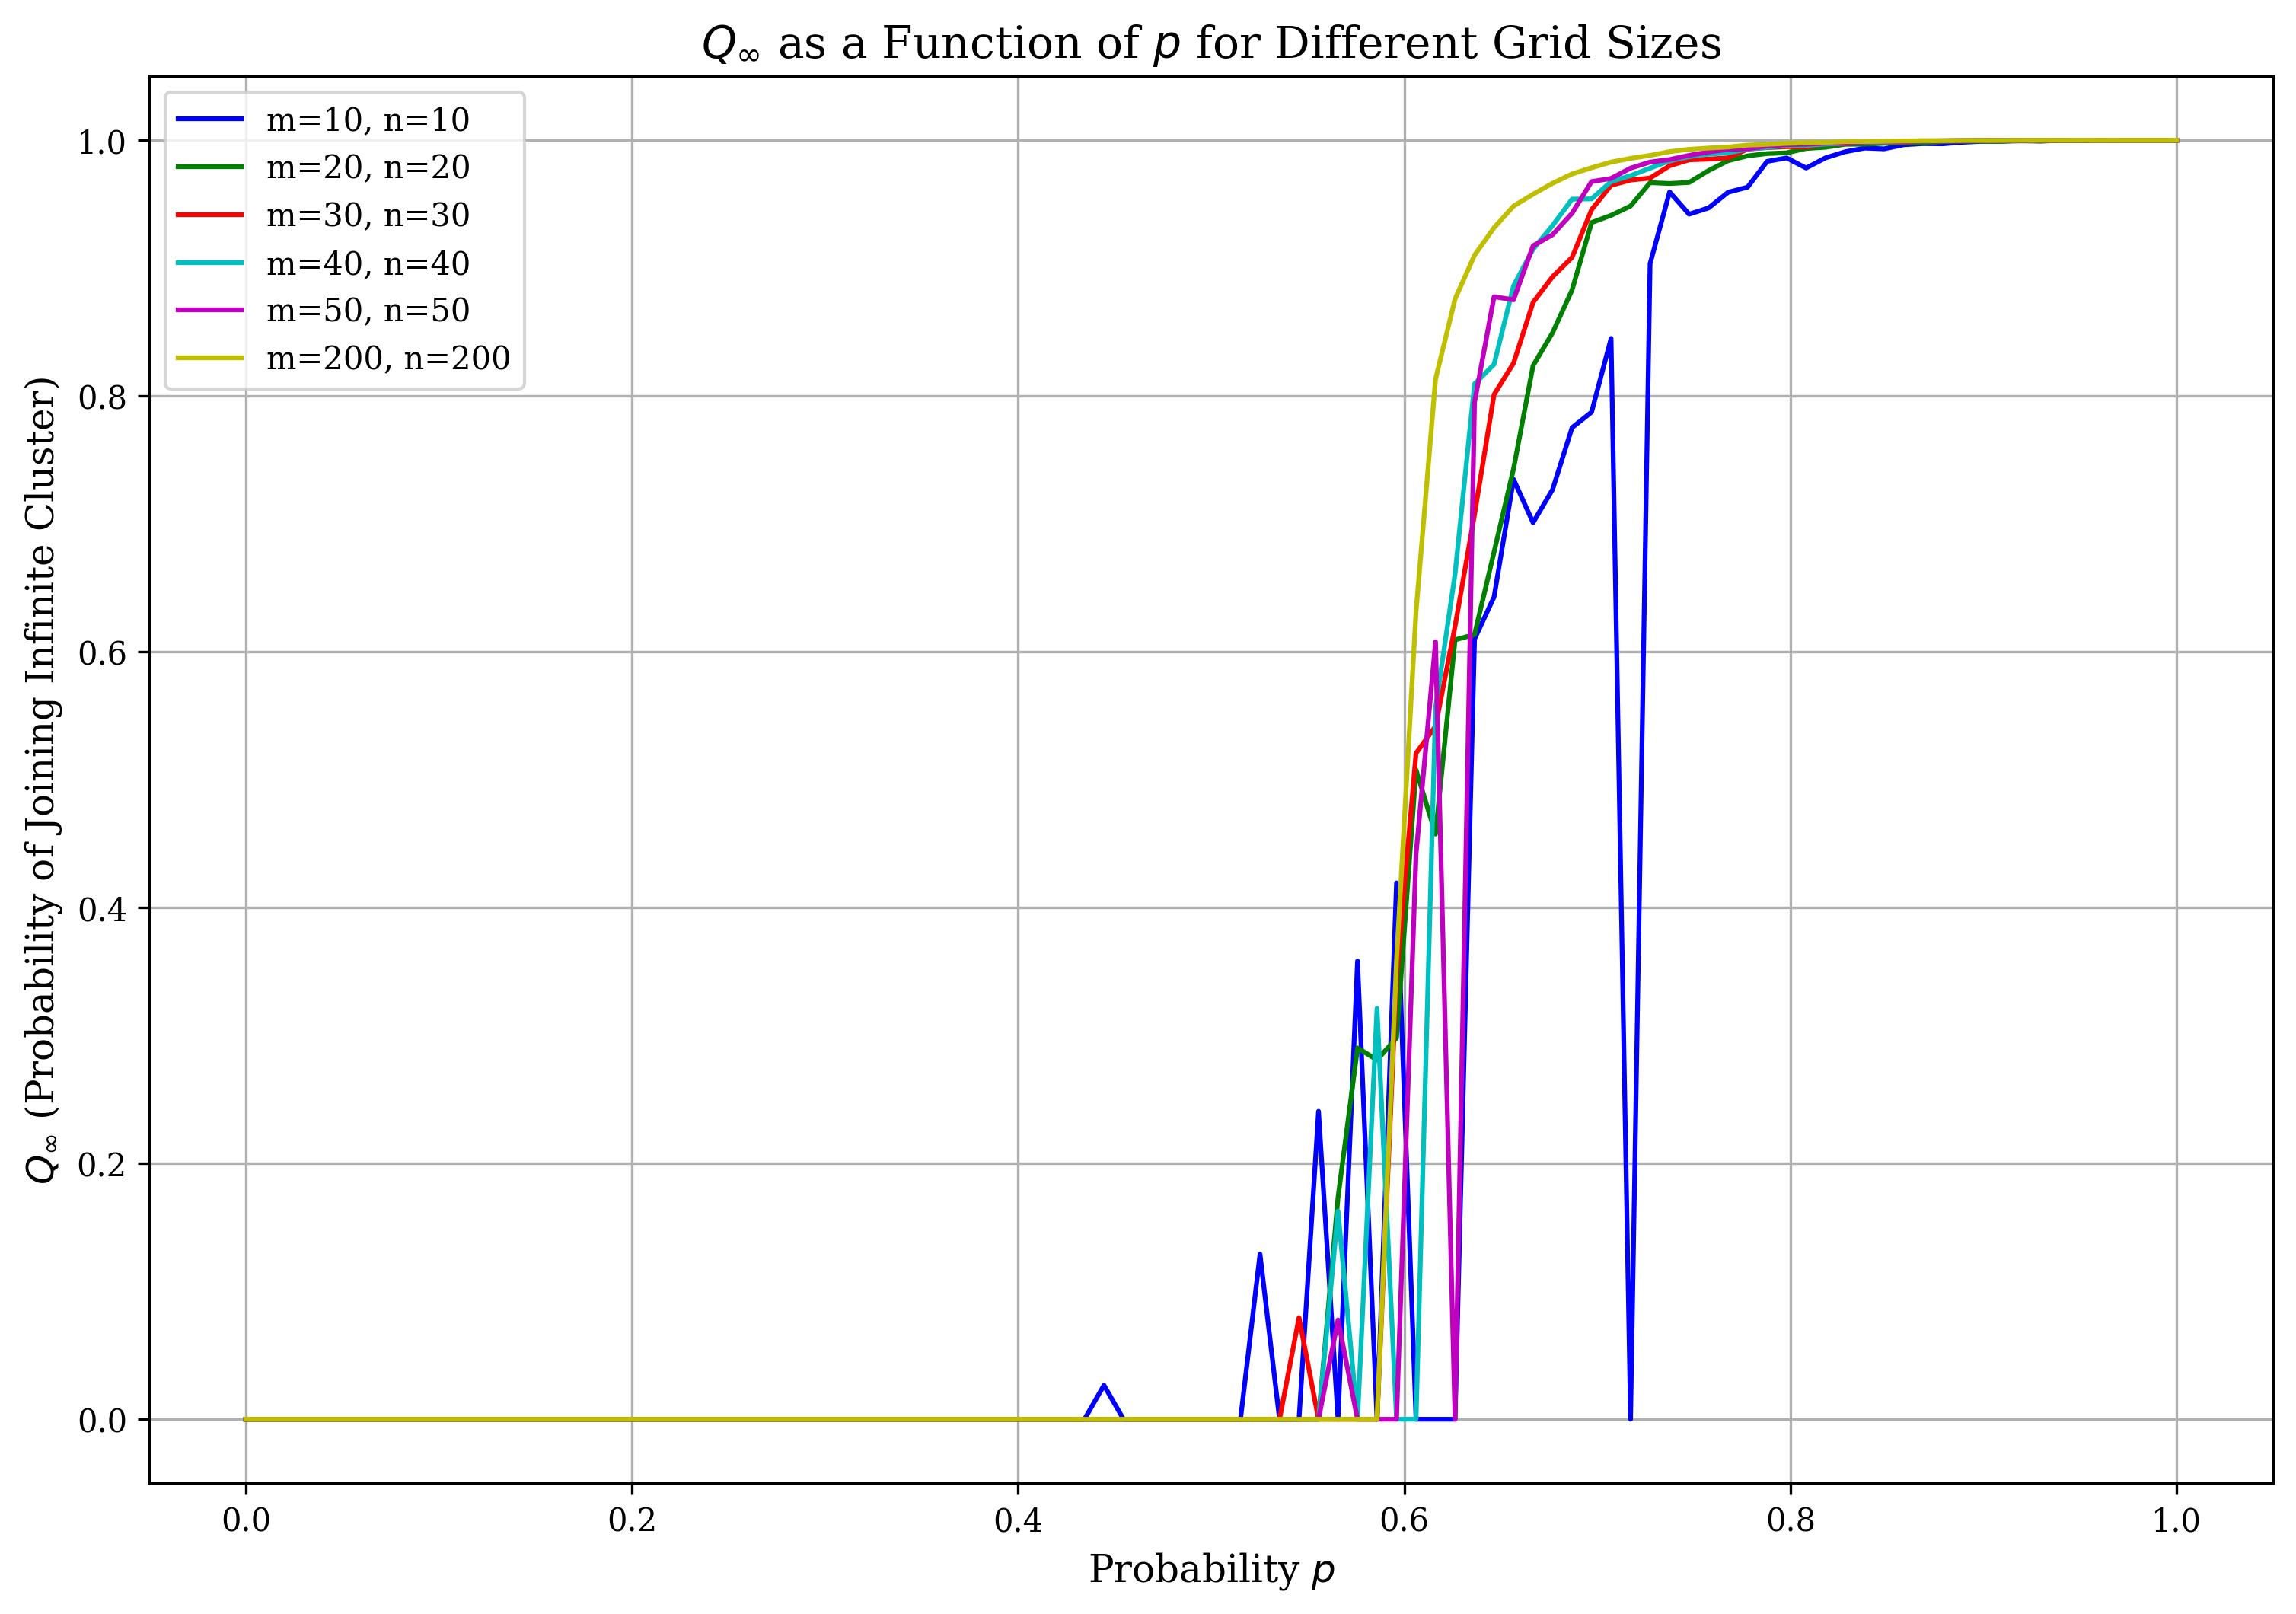

{'avg_q_infty': {(10, 10): np.float64(0.3457035),
  (20, 20): np.float64(0.37831339999999997),
  (30, 30): np.float64(0.3786541),
  (40, 40): np.float64(0.3781249),
  (50, 50): np.float64(0.3728874),
  (200, 200): np.float64(0.3925652)},
 'std_q_infty': {(10, 10): np.float64(0.4458270623736854),
  (20, 20): np.float64(0.45429197004838207),
  (30, 30): np.float64(0.4631630015061544),
  (40, 40): np.float64(0.4679754369953512),
  (50, 50): np.float64(0.46990115590115333),
  (200, 200): np.float64(0.4766540197050267)},
 'q_infty_values': {(10, 10): [0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0.02659,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0.12911,
   0,
   0,
   0.24074,
   0,
   0.35826,
   0,
   0.41932,
   0,
   0,
   0,
   0.60997,
   0.6429,
   0.73486,
   0.70

In [719]:
grid_sizes = [(10, 10), (20, 20), (30, 30), (40, 40), (50, 50), (200,200)]
print("\nEstimating Q_infty:")
estimate_Q_infty(grid_sizes, num_samples=100, p_values=np.linspace(0, 1, 100), num_trials=1000)

In [ ]:
from numba import njit

plt.rc('text', usetex=False)
plt.rc('font', family='serif')

@njit
def calculate_radius_of_gyration(labeled_grid, m, n, cluster_label):
    indices = np.where(labeled_grid == cluster_label)
    if indices[0].size == 0:
        return 0.0
    S = indices[0].size
    if S == 0:
        return 0.0
    x_c = np.mean(indices[0])
    y_c = np.mean(indices[1])
    distances_squared = np.zeros(S, dtype=np.float64)
    for i in range(S):
        dx = indices[0][i] - x_c
        dy = indices[1][i] - y_c
        distances_squared[i] = dx * dx + dy * dy
    R_g = np.sqrt(np.mean(distances_squared)) if distances_squared.size > 0 else 0.0
    return R_g

@njit
def compute_correlation_and_sizes(labeled_grid, m, n, percolating_labels):
    xi_squared_sum = 0.0
    total_weight = 0.0
    max_clusters = m * n
    finite_cluster_sizes = np.zeros(max_clusters, dtype=np.float64)
    finite_cluster_count = 0

    unique_labels = np.unique(labeled_grid)
    for label in unique_labels:
        if label == 0:
            continue
        indices = np.where(labeled_grid == label)
        S = indices[0].size
        if S > 0:
            is_percolating = False
            for pl in percolating_labels:
                if label == pl:
                    is_percolating = True
                    break
            if not is_percolating:
                if finite_cluster_count < max_clusters:
                    finite_cluster_sizes[finite_cluster_count] = S
                    finite_cluster_count += 1
                x_c = np.mean(indices[0])
                y_c = np.mean(indices[1])
                distances_squared = np.zeros(S, dtype=np.float64)
                for i in range(S):
                    dx = indices[0][i] - x_c
                    dy = indices[1][i] - y_c
                    distances_squared[i] = dx * dx + dy * dy
                R_g_squared = np.mean(distances_squared) if distances_squared.size > 0 else 0.0
                xi_squared_sum += S * R_g_squared
                total_weight += S

    xi = np.sqrt(xi_squared_sum / total_weight) if total_weight > 0 else 0.0
    avg_s = np.mean(finite_cluster_sizes[:finite_cluster_count]) if finite_cluster_count > 0 else 0.0
    return xi, avg_s, finite_cluster_sizes[:finite_cluster_count]

def compute_correlation_results(grid_sizes, num_samples=1000, p_values=np.linspace(0.4, 0.8, 10)):
    num_grids = len(grid_sizes)
    num_p = len(p_values)
    xi_values = np.zeros((num_grids, num_p), dtype=np.float64)
    avg_cluster_sizes = np.zeros((num_grids, num_p), dtype=np.float64)
    avg_non_percolating_sizes = np.zeros((num_grids, num_p * num_samples), dtype=np.float64)
    p_c_estimates = []
    L_values = []
    for idx, (m, n) in enumerate(grid_sizes):
        for j, p in enumerate(p_values):
            xi_sum = 0.0
            s_sum = 0.0
            for i in range(num_samples):
                grid = generate_grid(m, n, p)
                if np.sum(grid) == 0:
                    print(f"Warning: Empty grid for m={m}, n={n}, p={p}")
                    continue
                labeled_grid = identify_clusters(grid)
                percolation, percolating_labels = check_percolation(labeled_grid, m, n)
                if isinstance(percolating_labels, set):
                    percolating_labels = np.array(list(percolating_labels), dtype=np.int64)
                elif percolating_labels is None:
                    percolating_labels = np.array([], dtype=np.int64)
                xi, avg_s, finite_sizes = compute_correlation_and_sizes(labeled_grid, m, n, percolating_labels)
                xi_sum += xi
                s_sum += avg_s
                if finite_sizes.size > 0:
                    start_idx = j * num_samples + i
                    avg_non_percolating_sizes[idx, start_idx] = np.mean(finite_sizes)

            xi_values[idx, j] = xi_sum / num_samples if num_samples > 0 else 0.0
            avg_cluster_sizes[idx, j] = s_sum / num_samples if num_samples > 0 else 0.0

        avg_xi = np.mean(xi_values[idx])
        print(f"Grid size (m={m}, n={n}): Average xi = {avg_xi:.4f}")
        p_c = p_values[np.argmax(xi_values[idx])] if np.any(xi_values[idx]) else p_values[0]
        p_c_estimates.append(p_c)
        L_values.append(min(m, n))

    return {
        "xi_values": xi_values,
        "avg_cluster_sizes": avg_cluster_sizes,
        "avg_non_percolating_sizes": avg_non_percolating_sizes,
        "p_c_estimates": p_c_estimates,
        "L_values": L_values,
        "p_values": p_values,
        "grid_sizes": grid_sizes
    }

In [689]:
grid_sizes = [(10, 10), (20, 20), (80, 80)]
print("\nEstimating Correlation Length (xi):")
results = compute_correlation_results(grid_sizes, num_samples=1000, p_values=np.linspace(0.001, 1, 200))


Estimating Correlation Length (xi):
Grid size (m=10, n=10): Average xi = 0.7072
Grid size (m=20, n=20): Average xi = 1.0887
Grid size (m=80, n=80): Average xi = 1.9617


In [690]:
from scipy.optimize import curve_fit

plt.rc('text', usetex=False)
plt.rc('font', family='serif')

def exponential_fit(x, tau):
    return np.exp(-tau * np.log(x))

def plot_correlation_results(results):
    plot_colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    xi_values = results["xi_values"]
    avg_cluster_sizes = results["avg_cluster_sizes"]
    avg_non_percolating_sizes = results["avg_non_percolating_sizes"]
    p_c_estimates = results["p_c_estimates"]
    L_values = results["L_values"]
    p_values = results["p_values"]
    grid_sizes = results["grid_sizes"]

    if len(p_c_estimates) > 1:
        L_inv = 1 / np.array(L_values)
        coeffs = np.polyfit(L_inv, p_c_estimates, 1, w=np.sqrt(L_values))
        p_c_infty = coeffs[1]
        print(f"Estimated p_c(infinity) = {p_c_infty:.4f}")
    else:
        p_c_infty = np.mean(p_c_estimates) if p_c_estimates else p_values.mean()
        print(f"Estimated p_c(infinity) (fallback) = {p_c_infty:.4f}")

    fig1 = plt.figure(figsize=(12, 8), dpi=300)
    for idx, (m, n) in enumerate(grid_sizes):
        plt.plot(p_values, xi_values[idx], color=plot_colors[idx % len(plot_colors)], linestyle='-', label=f'm={m}, n={n}')
    plt.xlabel('Probability $p$', fontsize=12)
    plt.ylabel(r'Correlation Length $\xi$', fontsize=12)
    plt.title(r'Correlation Length $\xi$ as a Function of $p$', fontsize=14)
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.savefig("correlation_length_vs_p.png", dpi=300, bbox_inches='tight')
    plt.show()

    if len(p_c_estimates) > 1:
        fig2 = plt.figure(figsize=(12, 6), dpi=300)
        L_inv = 1 / np.array(L_values)
        coeffs = np.polyfit(L_inv, p_c_estimates, 1, w=np.sqrt(L_values))
        p_c_infty = coeffs[1]
        fit_line = np.polyval(coeffs, L_inv)
        plt.plot(1 / np.array(L_values), p_c_estimates, 'bo', label=r'Simulated $p_c$')
        plt.plot(1 / np.array(L_values), fit_line, 'r-', label=r'Fit: $p_c(\infty) \approx {:.4f}$'.format(p_c_infty))
        delta_p_c = np.abs(np.array(p_c_estimates) - p_c_infty)
        L = np.array(L_values)
        mask = delta_p_c > 0
        if np.sum(mask) > 1:
            popt, _ = curve_fit(lambda x, nu_inv: np.exp(-np.log(x) / nu_inv), L[mask], delta_p_c[mask], p0=[1.0])
            nu_alt = 1 / popt[0]
            plt.plot(1 / L, delta_p_c, 'go', label=r'$|p_c(L) - p_c(\infty)|$')
            plt.plot(1 / L, np.exp(-np.log(L) / popt[0]), 'g--', label=f'Fit $\\nu={nu_alt:.2f}$')
            print(r"$\nu$ from $p_c(L)$: " + f"{nu_alt:.4f}")
        else:
            print("Insufficient data points to fit $\nu$ from $p_c(L)$")
        plt.xlabel('1/L (Inverse System Size)', fontsize=12)
        plt.ylabel(r'$p_c$ or $|p_c(L) - p_c(\infty)|$', fontsize=12)
        plt.title(r'Extrapolation of $p_c(\infty)$ and $\nu$ Estimation', fontsize=14)
        plt.grid(True)
        plt.legend(loc='upper right')
        plt.savefig("extrapolation_pc_infinity_nu_estimation.png", dpi=300, bbox_inches='tight')
        plt.show()

    fig3 = plt.figure(figsize=(12, 6), dpi=300)
    tau_values = []
    for idx, (m, n) in enumerate(grid_sizes):
        valid_sizes = avg_non_percolating_sizes[idx][avg_non_percolating_sizes[idx] > 0]
        if len(valid_sizes) > 0:
            hist, bin_edges = np.histogram(valid_sizes, bins=30, density=True)
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
            mask = bin_centers > 0
            if np.sum(mask) > 1:
                popt, _ = curve_fit(exponential_fit, bin_centers[mask], hist[mask], p0=[2.0])
                tau = popt[0]
                tau_values.append(tau)
                plt.hist(valid_sizes, bins=30, alpha=0.5, color=plot_colors[idx % len(plot_colors)], label=f'm={m}, n={n}', density=True)
                plt.plot(bin_centers, exponential_fit(bin_centers, tau), '--', color=plot_colors[idx % len(plot_colors)], label=f'Fit $\\tau={tau:.2f}$')
            else:
                print(f"Insufficient data points to fit $\\tau$ for m={m}, n={n}")
        else:
            print(f"Warning: No valid non-percolating sizes for m={m}, n={n}")
    plt.xlabel(r'Average Non-percolating Cluster Size $S$', fontsize=12)
    plt.ylabel(r'Normalized Frequency $n_s$', fontsize=12)
    plt.title(r'Distribution of Average Non-percolating Cluster Size $S$ with $n_s \sim S^{-\tau}$', fontsize=14)
    plt.legend(loc='best')
    plt.grid(True)
    plt.savefig("non_percolating_cluster_size_distribution.png", dpi=300, bbox_inches='tight')
    plt.show()
    if tau_values:
        avg_tau = np.mean(tau_values)
        std_tau = np.std(tau_values)
        print(r"Average $\tau$ from $n_s \sim S^{-\tau}$: " + f"{avg_tau:.4f} ± {std_tau:.4f}")
    else:
        print("No $\tau$ values computed due to insufficient data")

    fig4 = plt.figure(figsize=(12, 6), dpi=300)
    for idx, (m, n) in enumerate(grid_sizes):
        plt.plot(p_values, avg_cluster_sizes[idx], color=plot_colors[idx % len(plot_colors)], linestyle='-', label=f'm={m}, n={n}')
    if m == 1:
        plt.plot(p_values, 1 / (1 - np.array(p_values)), 'k--', label=r'$1/(1-p)$')
        plt.ylim(0, 50)
    plt.xlabel('Probability $p$', fontsize=12)
    plt.ylabel(r'Average Cluster Size $S$ (Non-percolating)', fontsize=12)
    plt.title(r'Average Cluster Size $S$ as a Function of $p$', fontsize=14)
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.savefig(f"average_cluster_size_m{m}_n{n}.png", dpi=300, bbox_inches='tight')
    plt.show()

Estimated p_c(infinity) = 0.5979


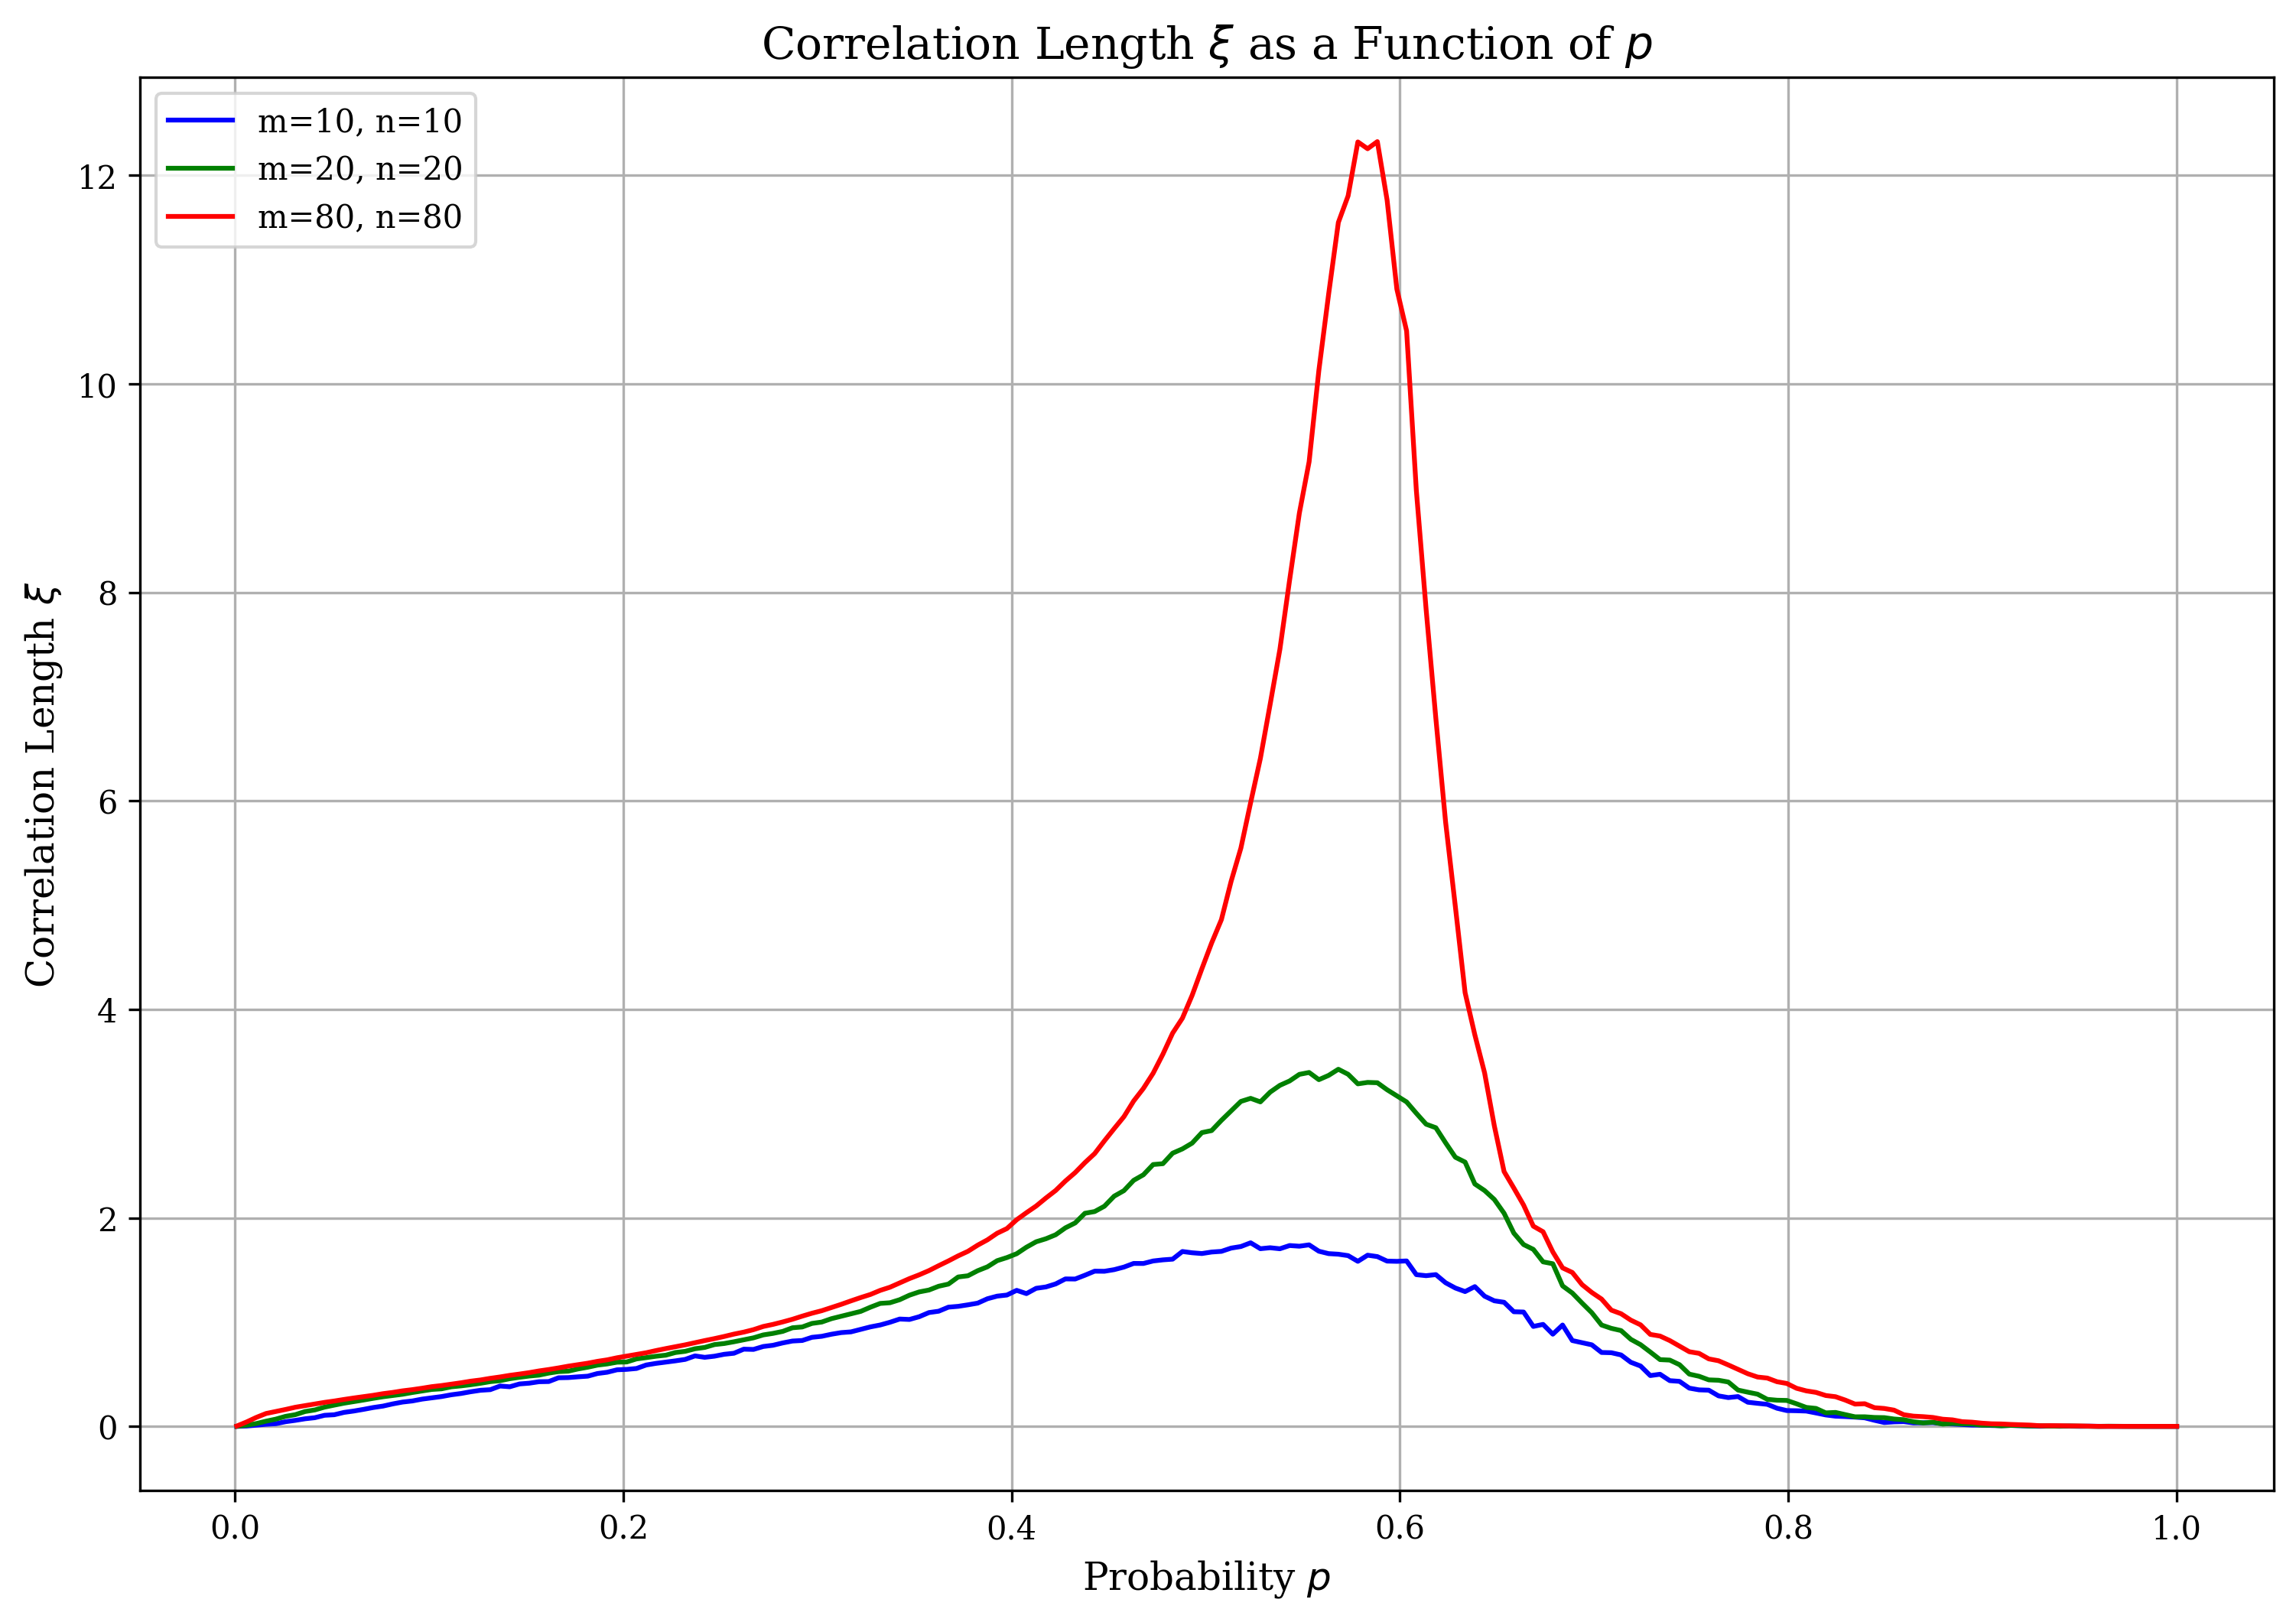

$\nu$ from $p_c(L)$: 1.1359


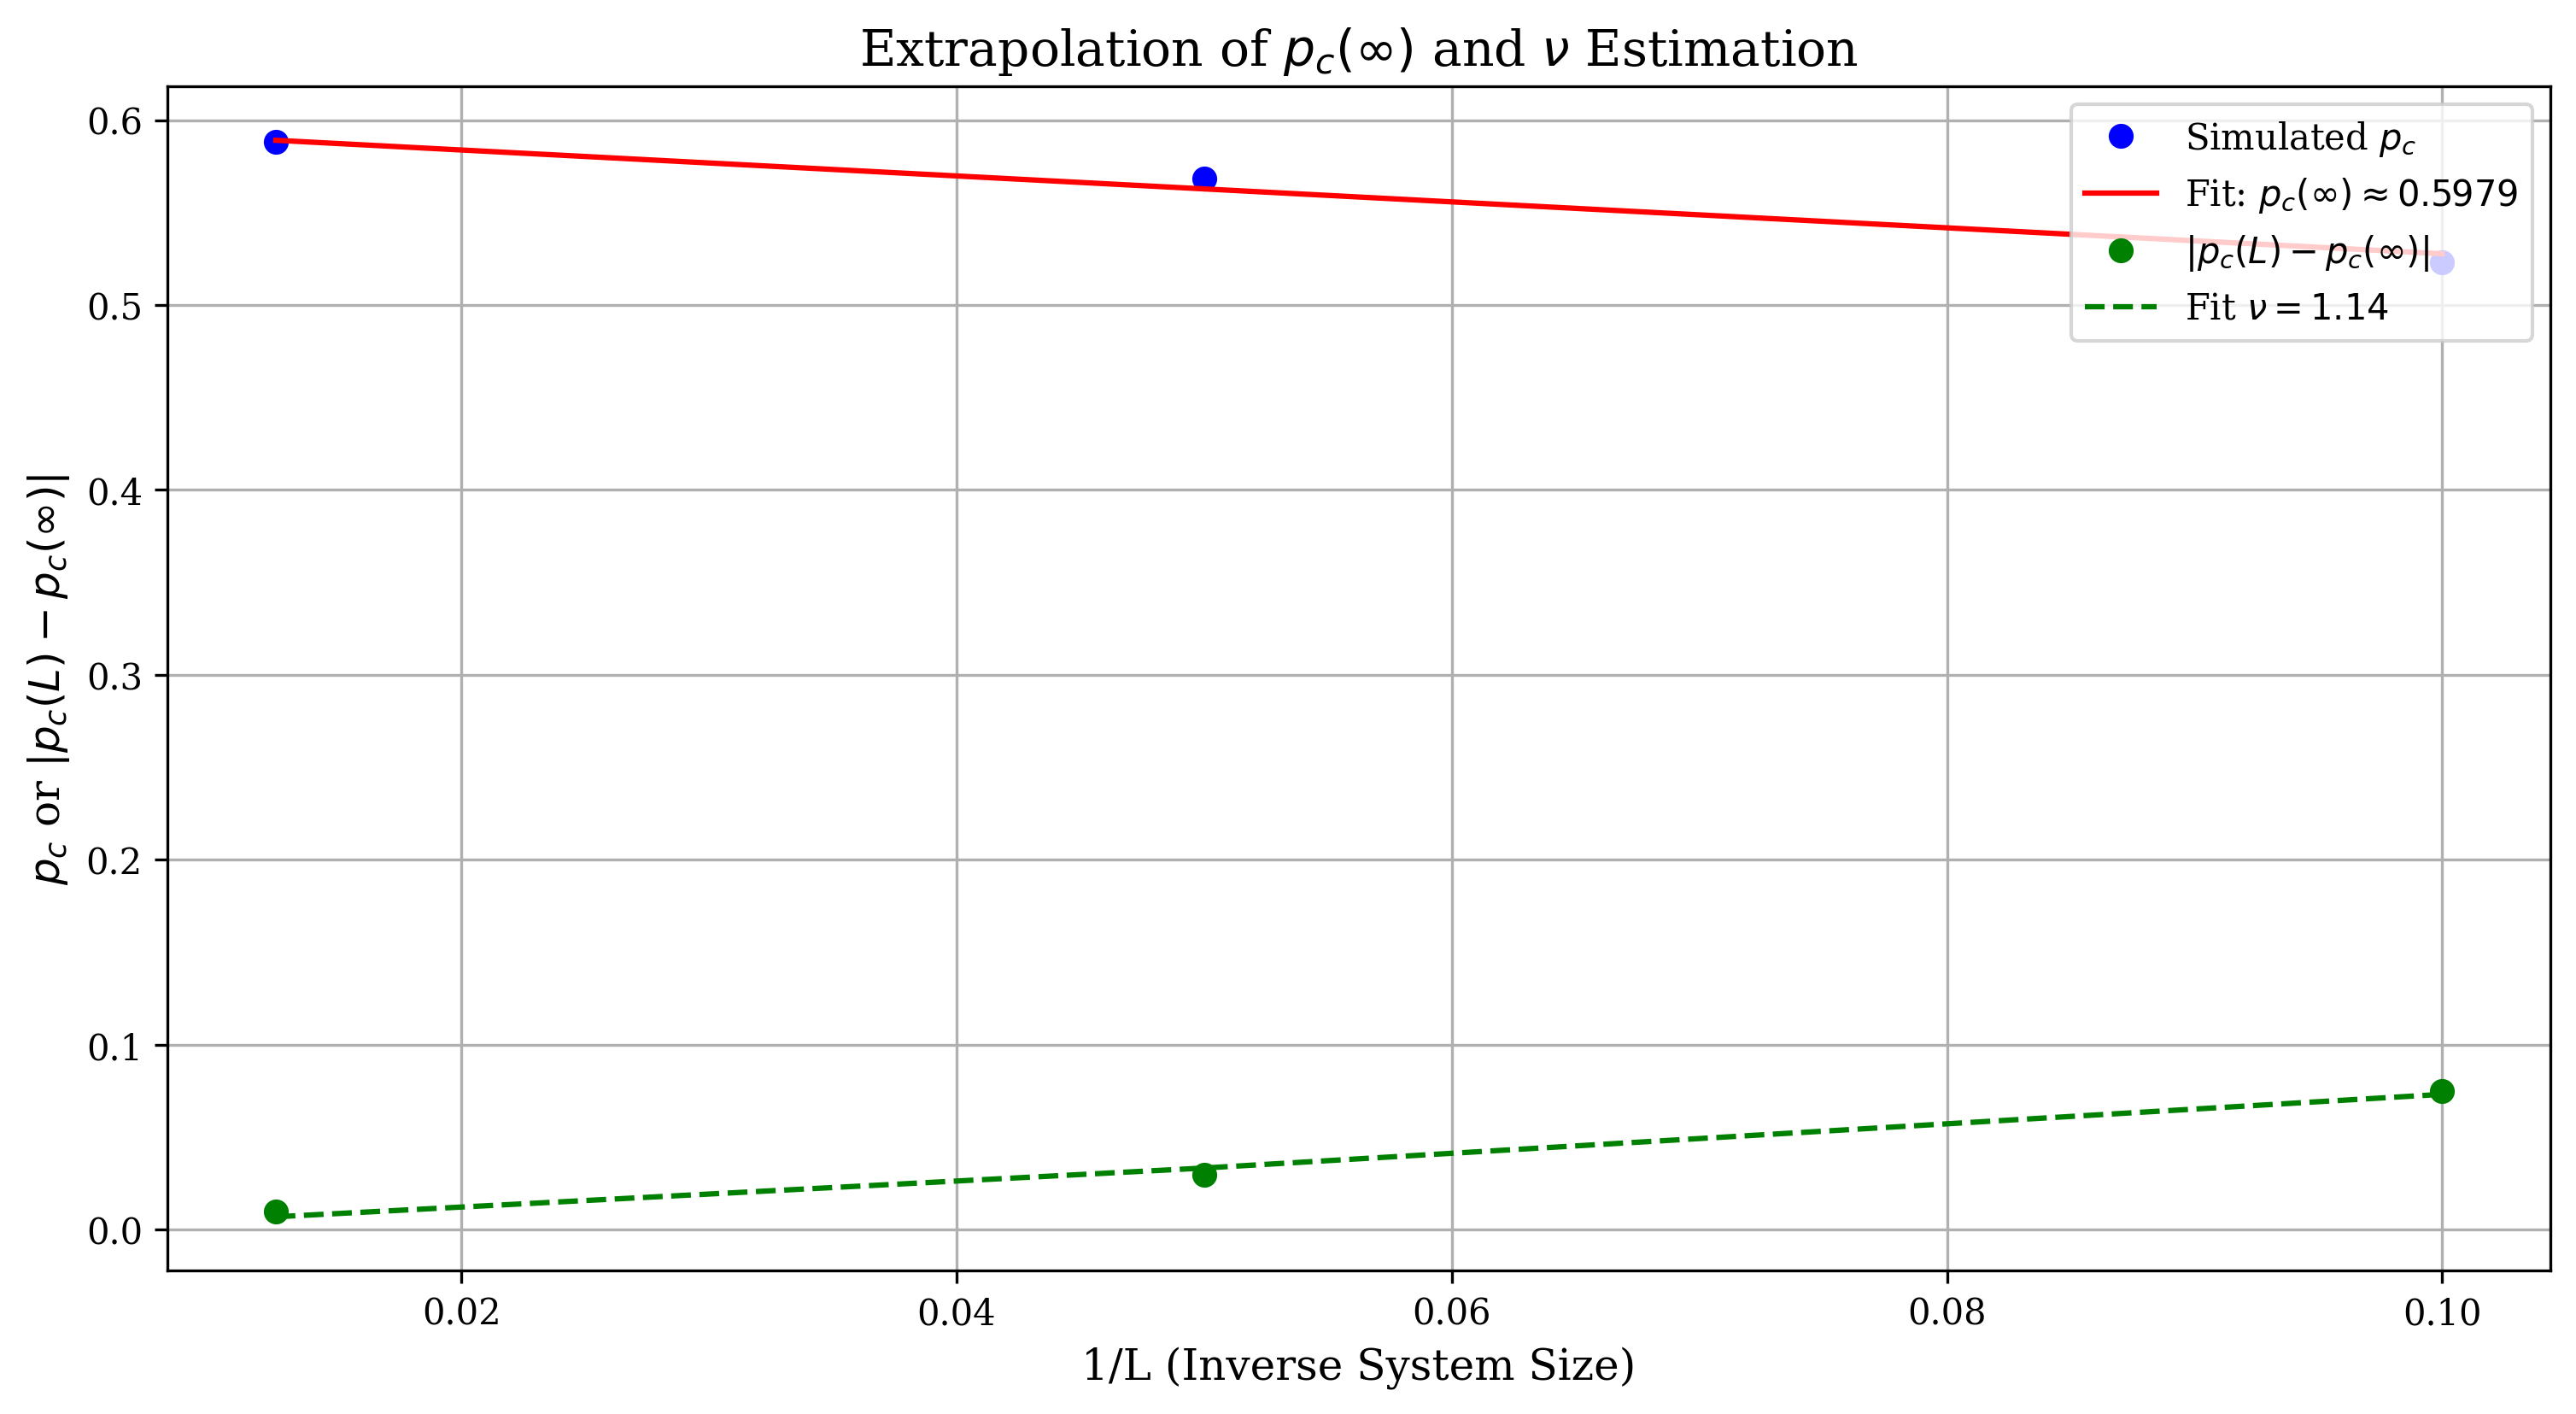

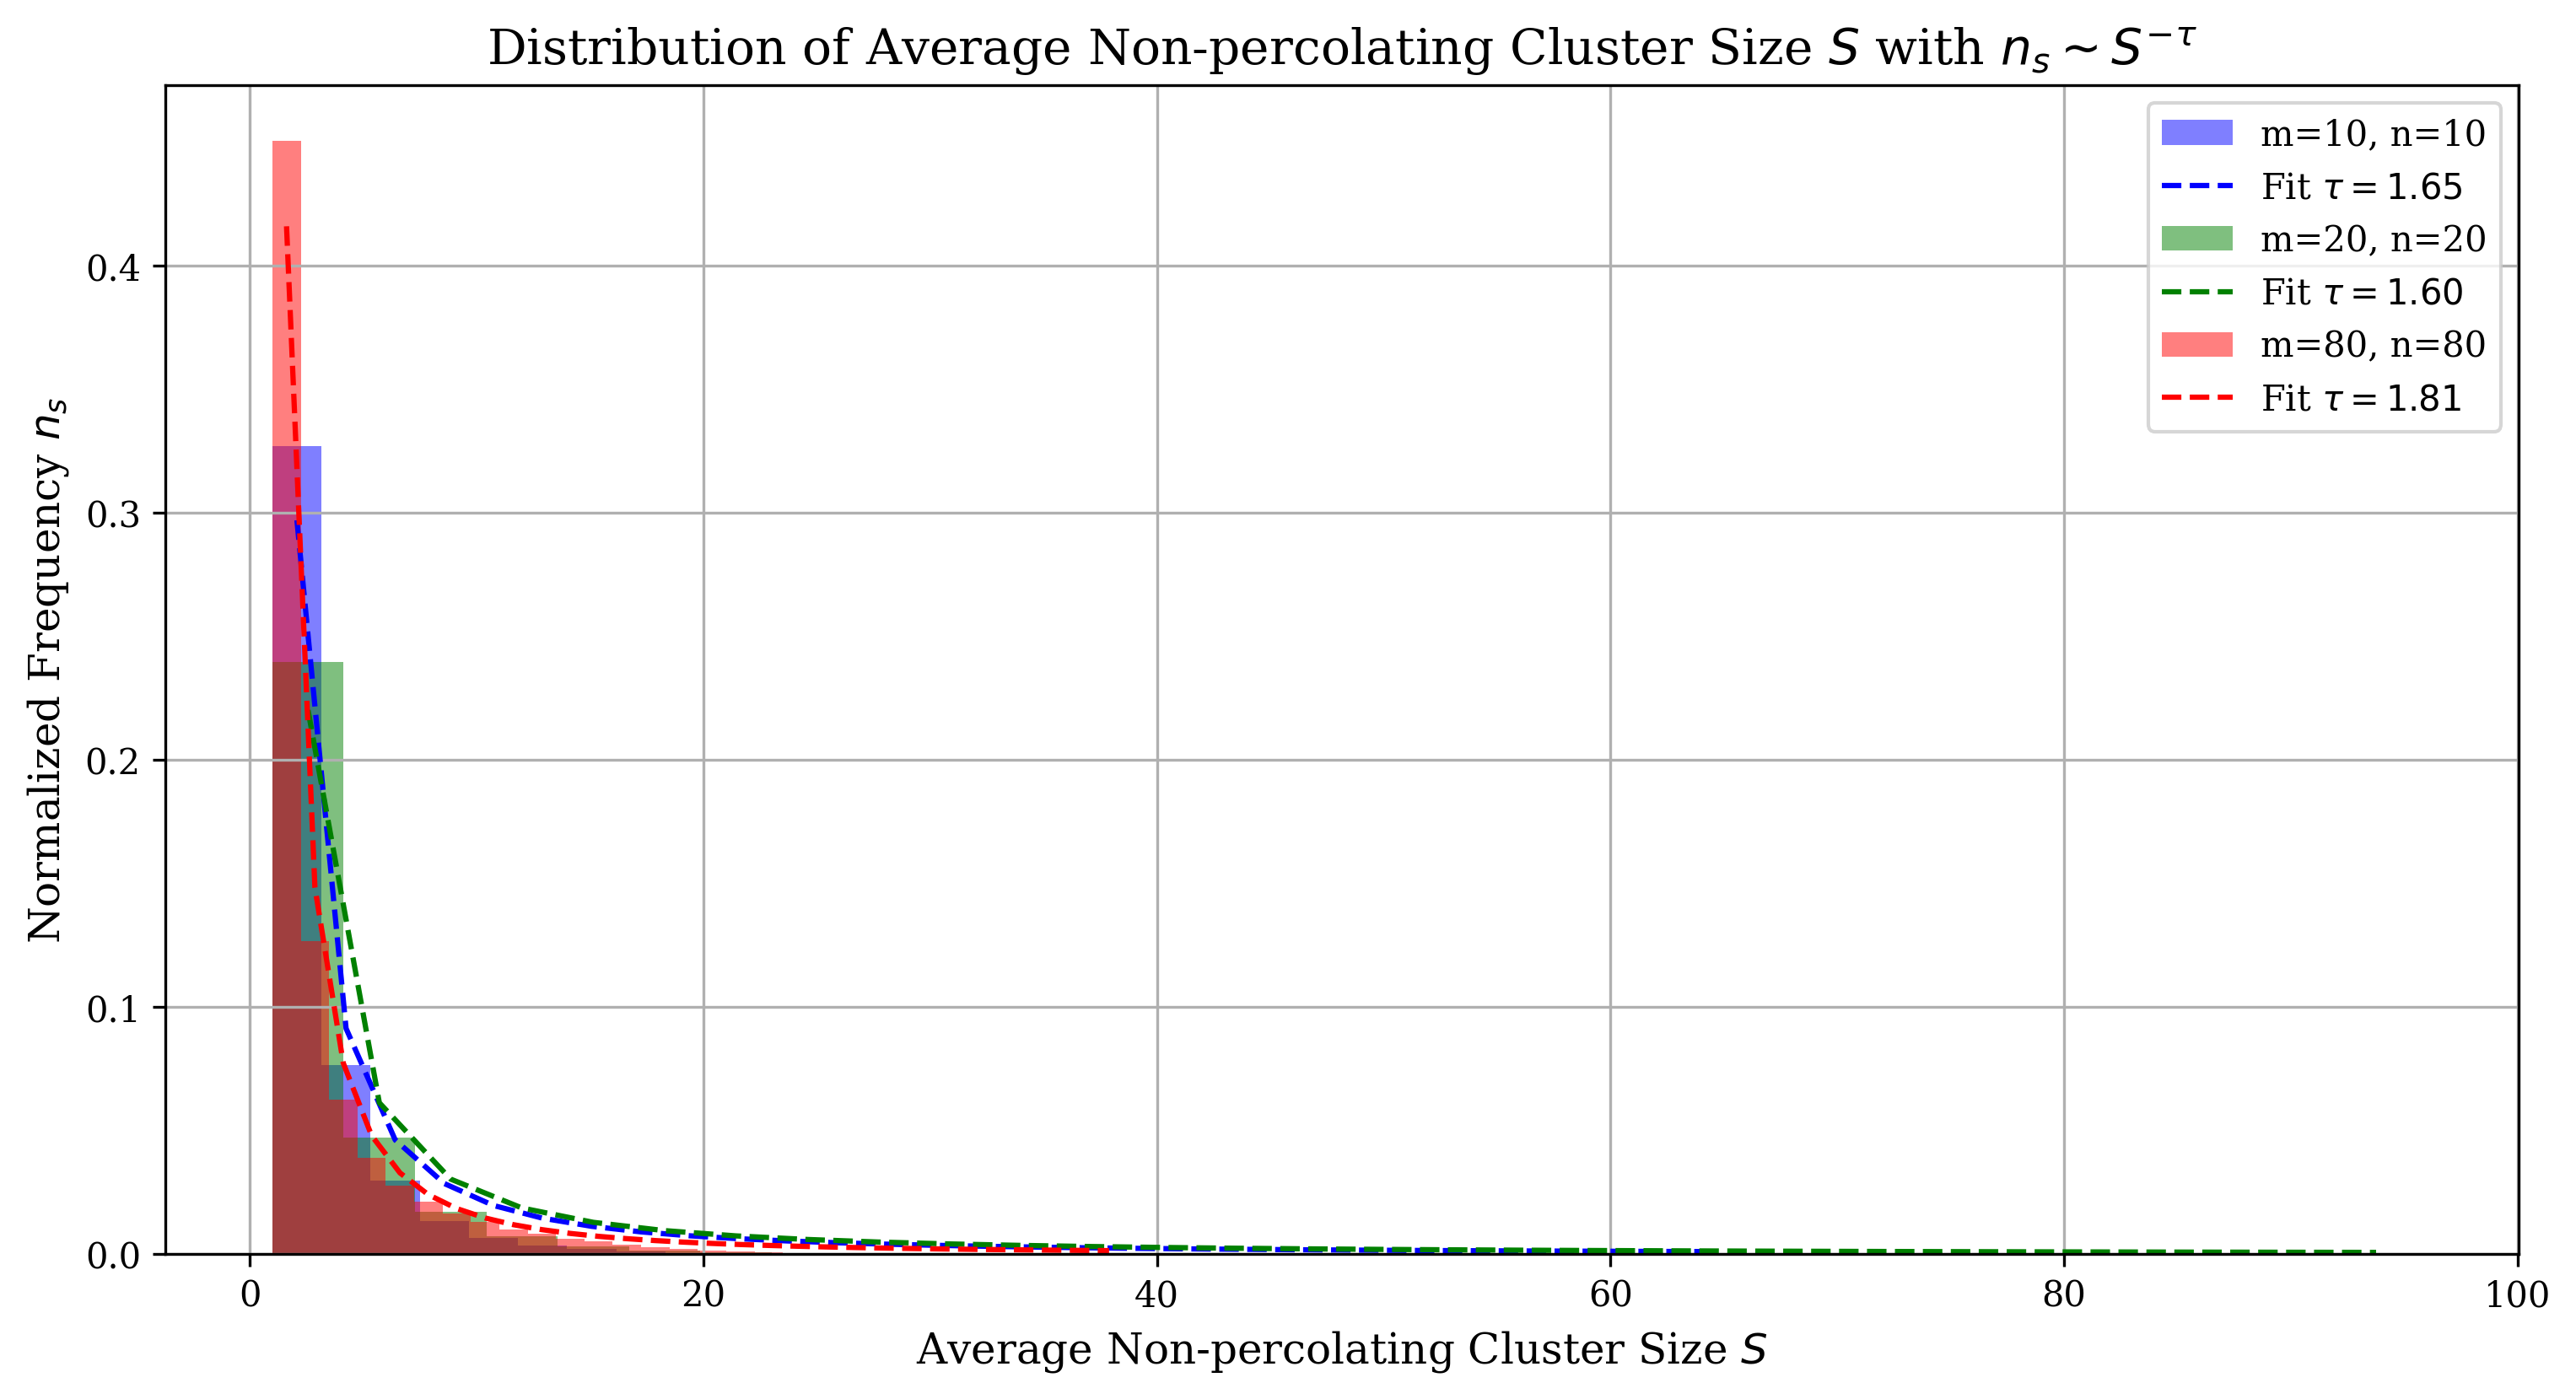

Average $\tau$ from $n_s \sim S^{-\tau}$: 1.6873 ± 0.0865


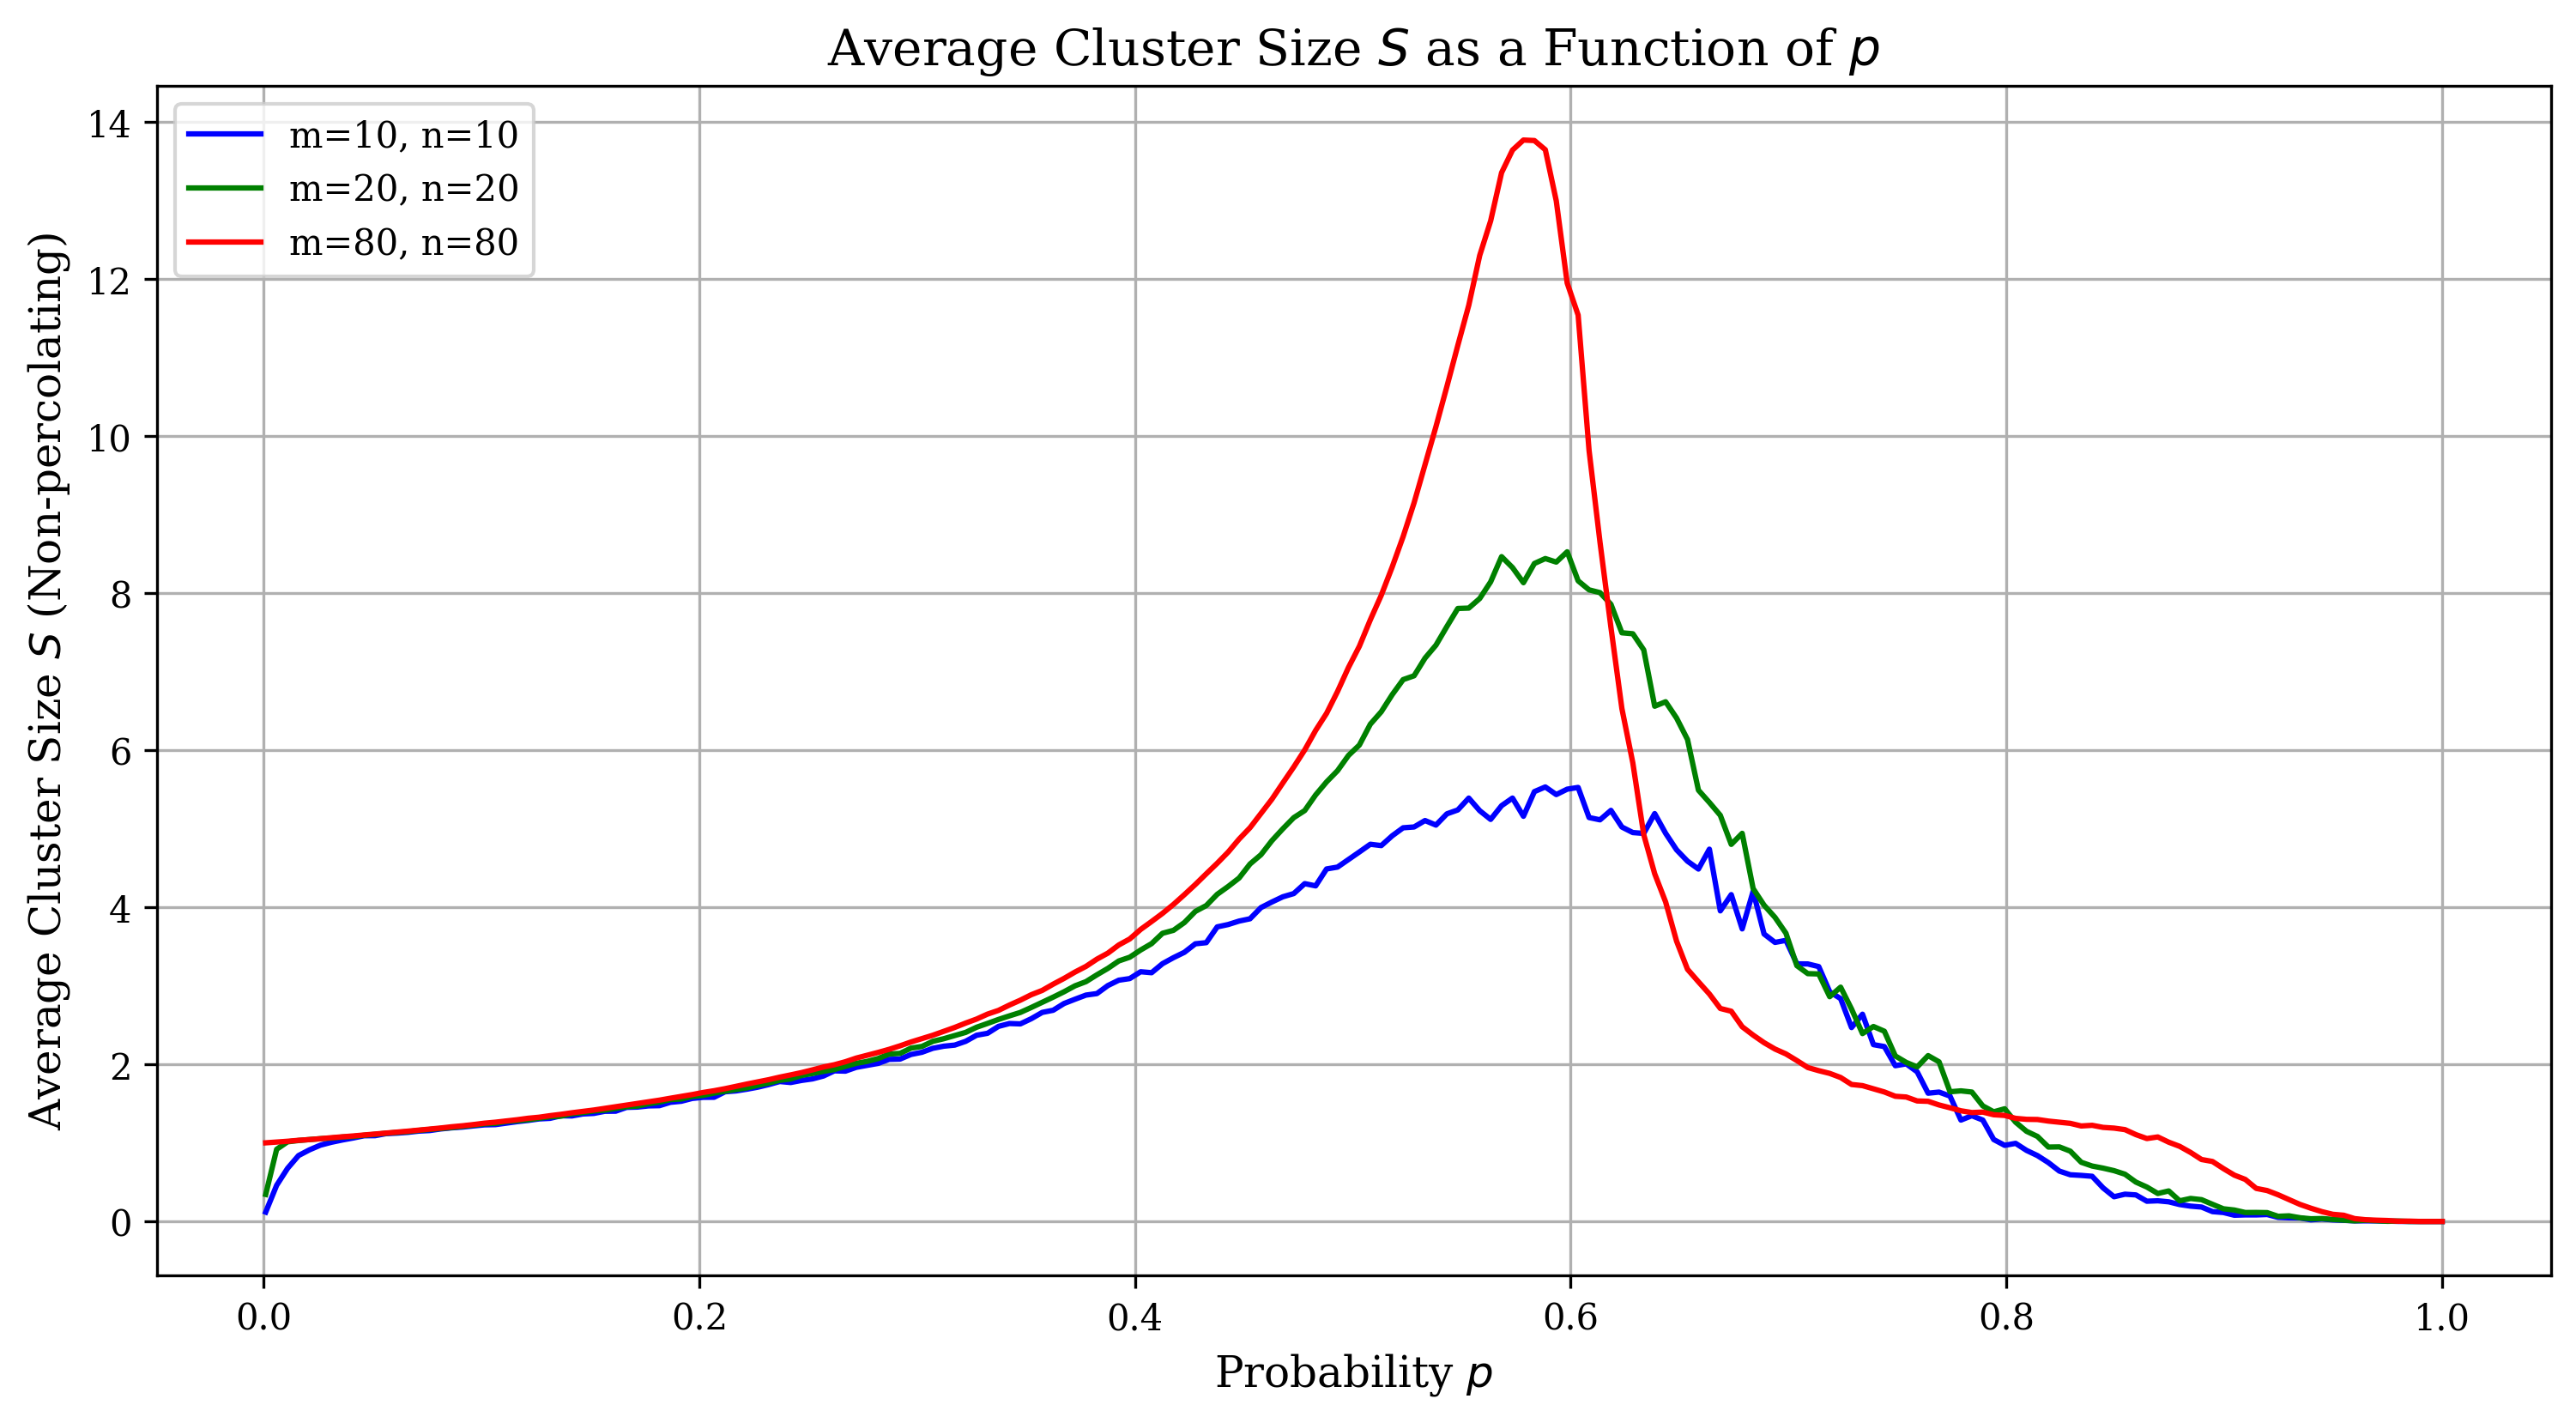

In [691]:
plot_correlation_results(results)

Cluster is blocked at p = 0.50. No new sites to illuminate. Stopping growth.
p = 0.50, Sample 1, Area = 88, xi = 5.7594, Seed = (38, 28)
Cluster is blocked at p = 0.50. No new sites to illuminate. Stopping growth.
p = 0.50, Sample 2, Area = 38, xi = 3.3500, Seed = (6, 35)
Cluster is blocked at p = 0.50. No new sites to illuminate. Stopping growth.
p = 0.50, Sample 3, Area = 6, xi = 1.3017, Seed = (34, 47)
Cluster is blocked at p = 0.50. No new sites to illuminate. Stopping growth.
p = 0.50, Sample 4, Area = 6, xi = 1.3017, Seed = (8, 6)
Cluster is blocked at p = 0.50. No new sites to illuminate. Stopping growth.
p = 0.50, Sample 5, Area = 9, xi = 1.3699, Seed = (43, 16)
Cluster is blocked at p = 0.50. No new sites to illuminate. Stopping growth.
p = 0.50, Sample 6, Area = 98, xi = 5.6715, Seed = (40, 38)
Cluster is blocked at p = 0.50. No new sites to illuminate. Stopping growth.
p = 0.50, Sample 7, Area = 8, xi = 1.3919, Seed = (3, 24)
Cluster is blocked at p = 0.50. No new sites to i

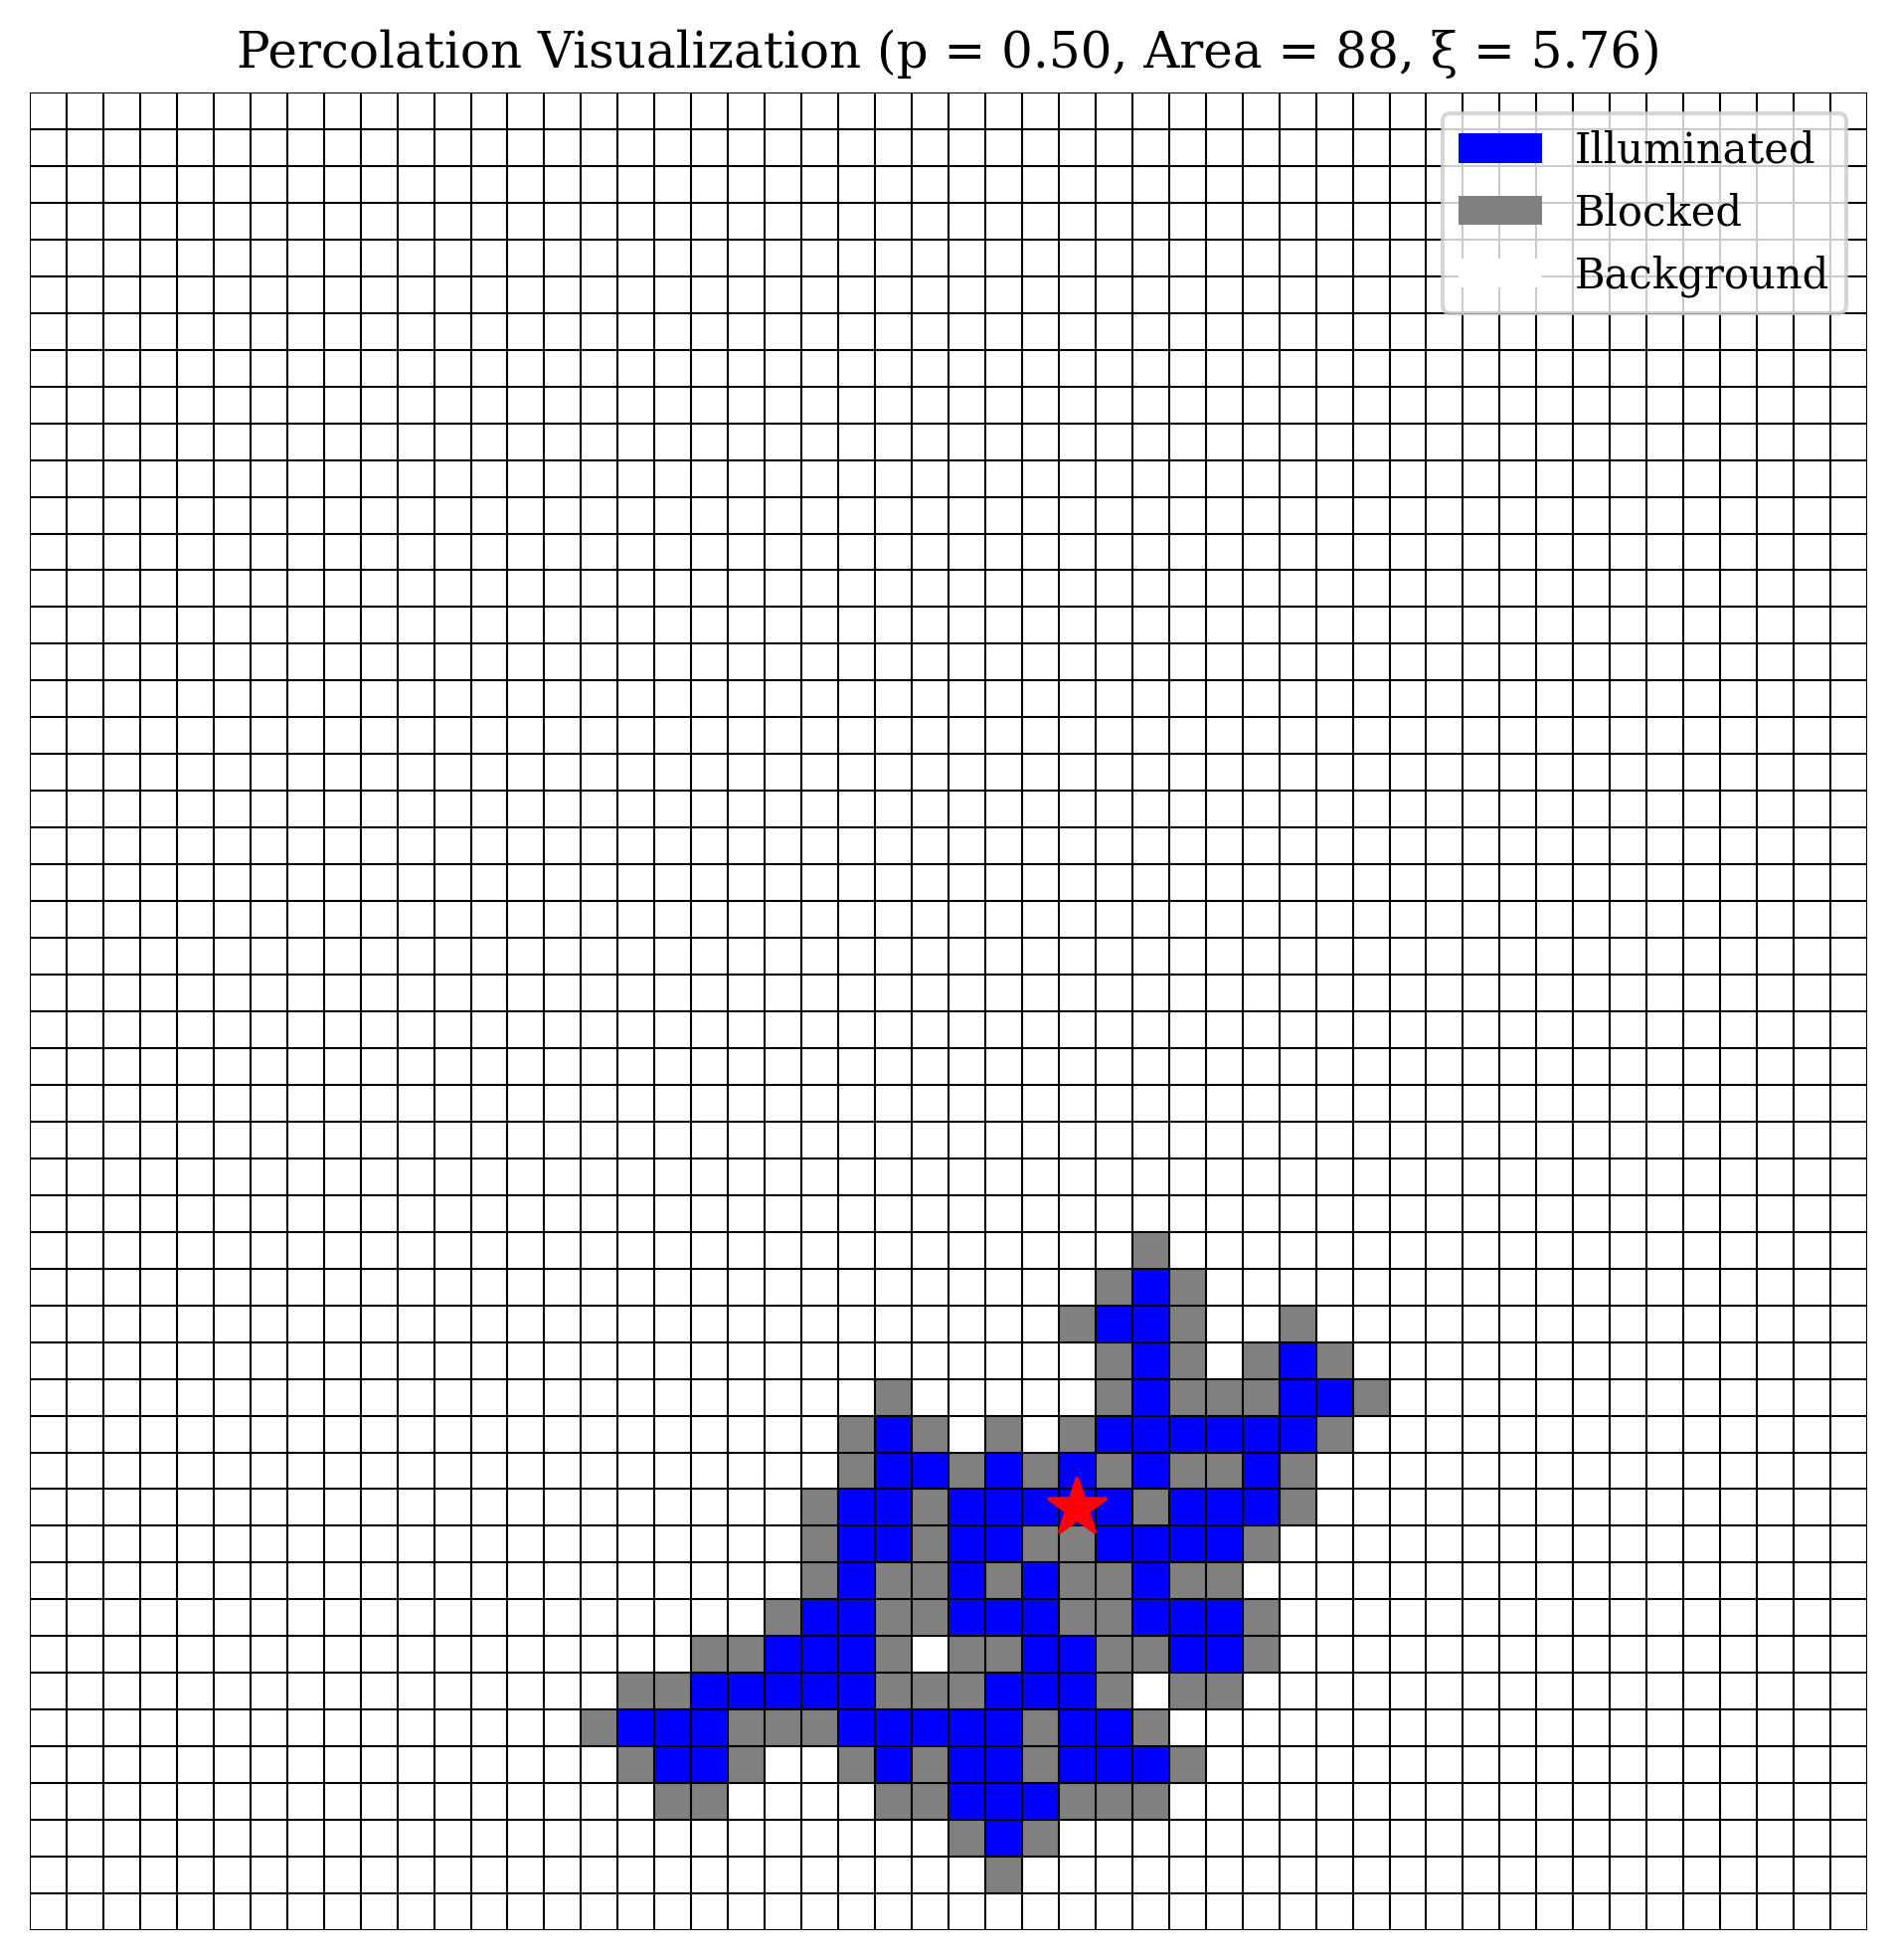

Static Plot - Seed: (5, 32)


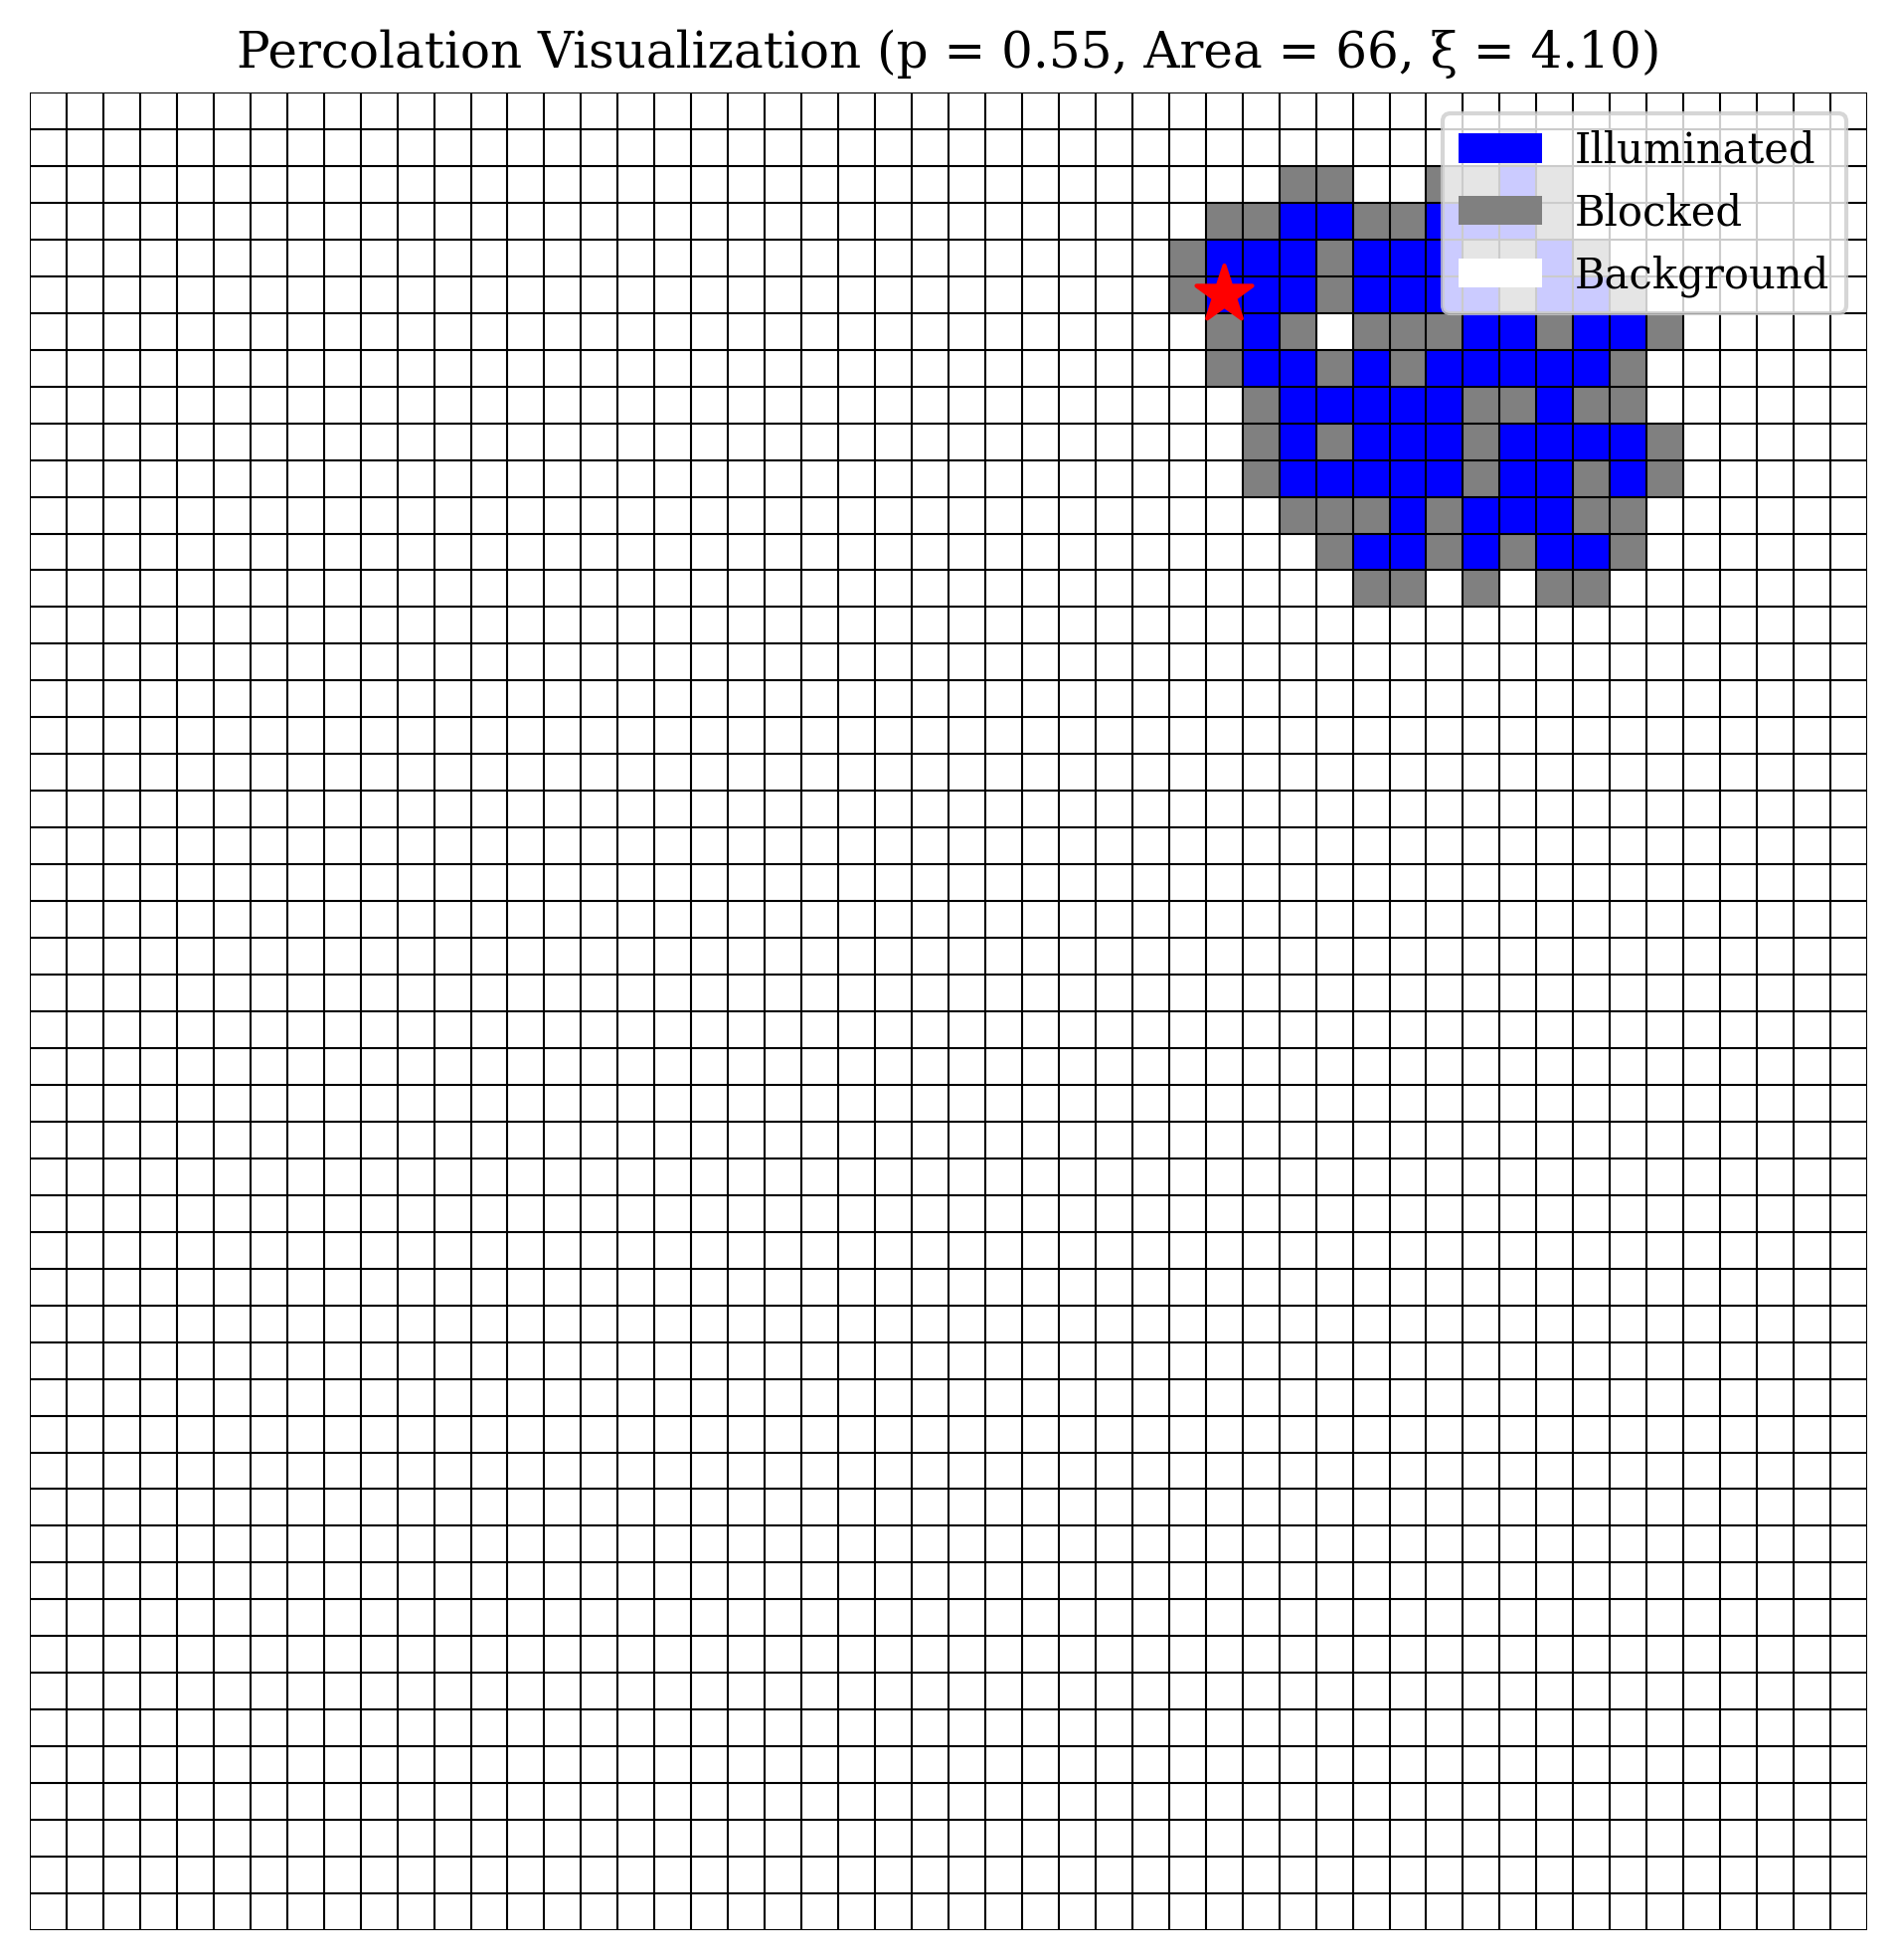

Static Plot - Seed: (40, 32)


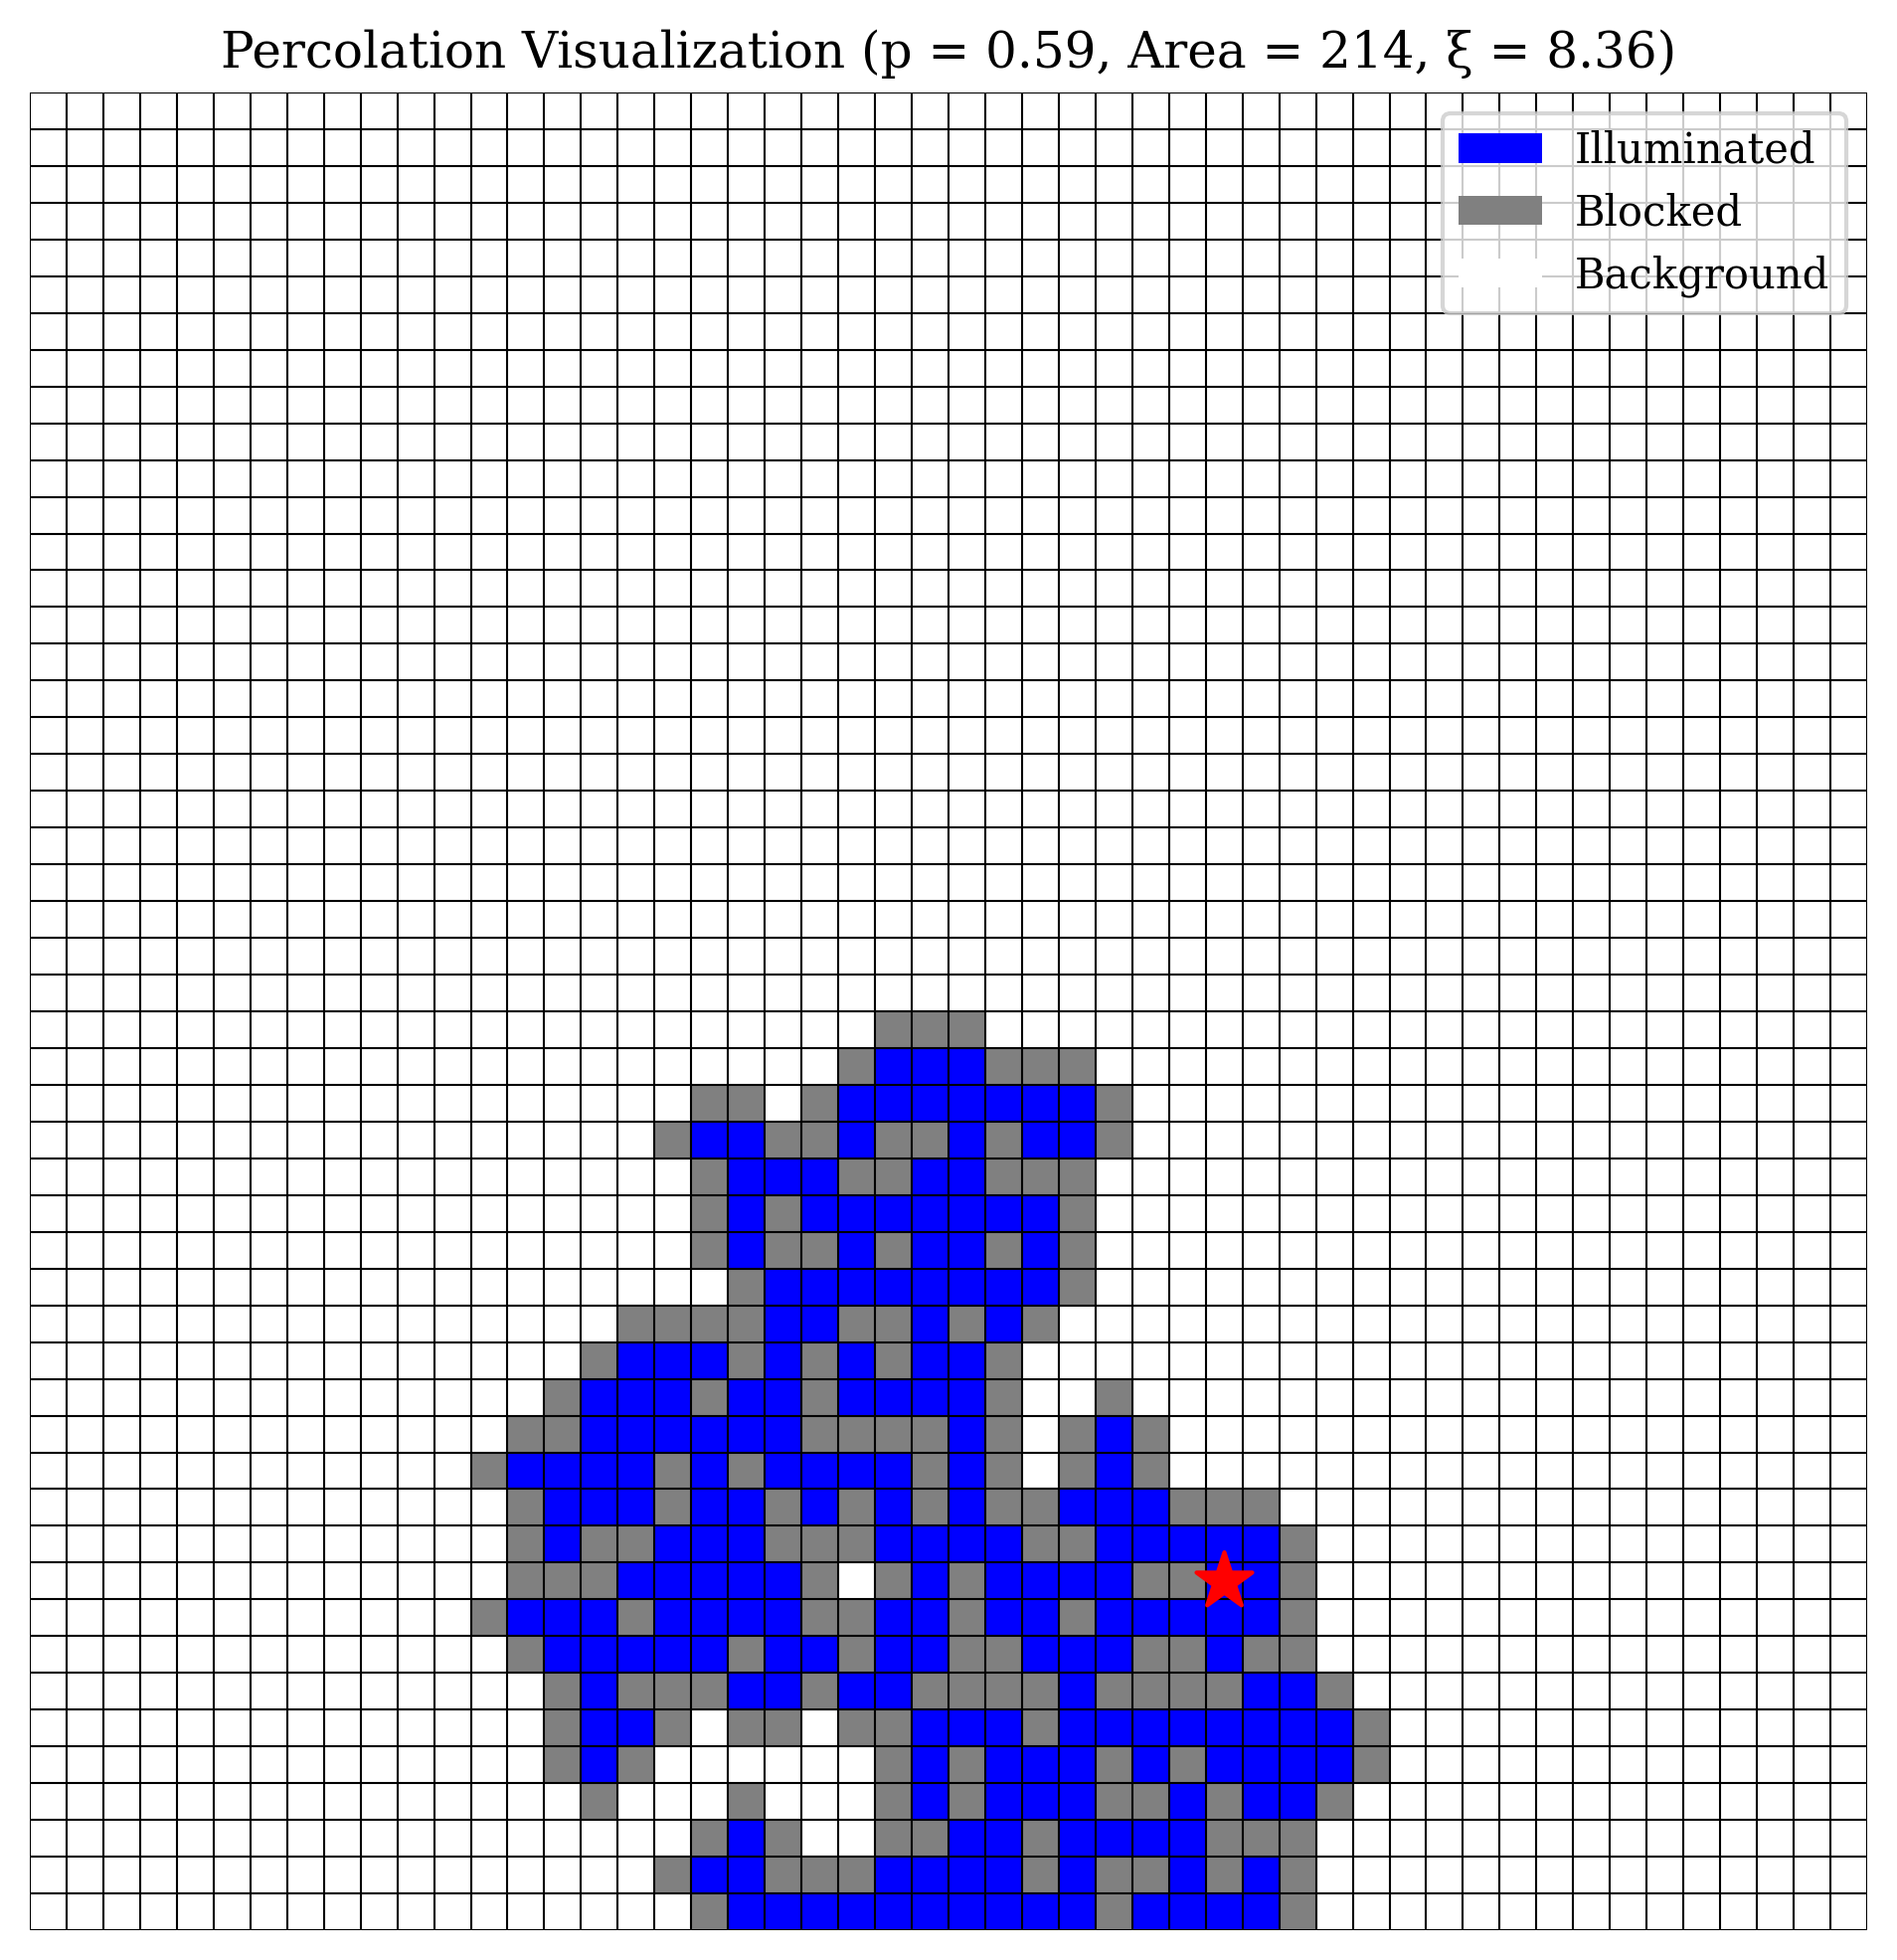

Static Plot - Seed: (4, 0)


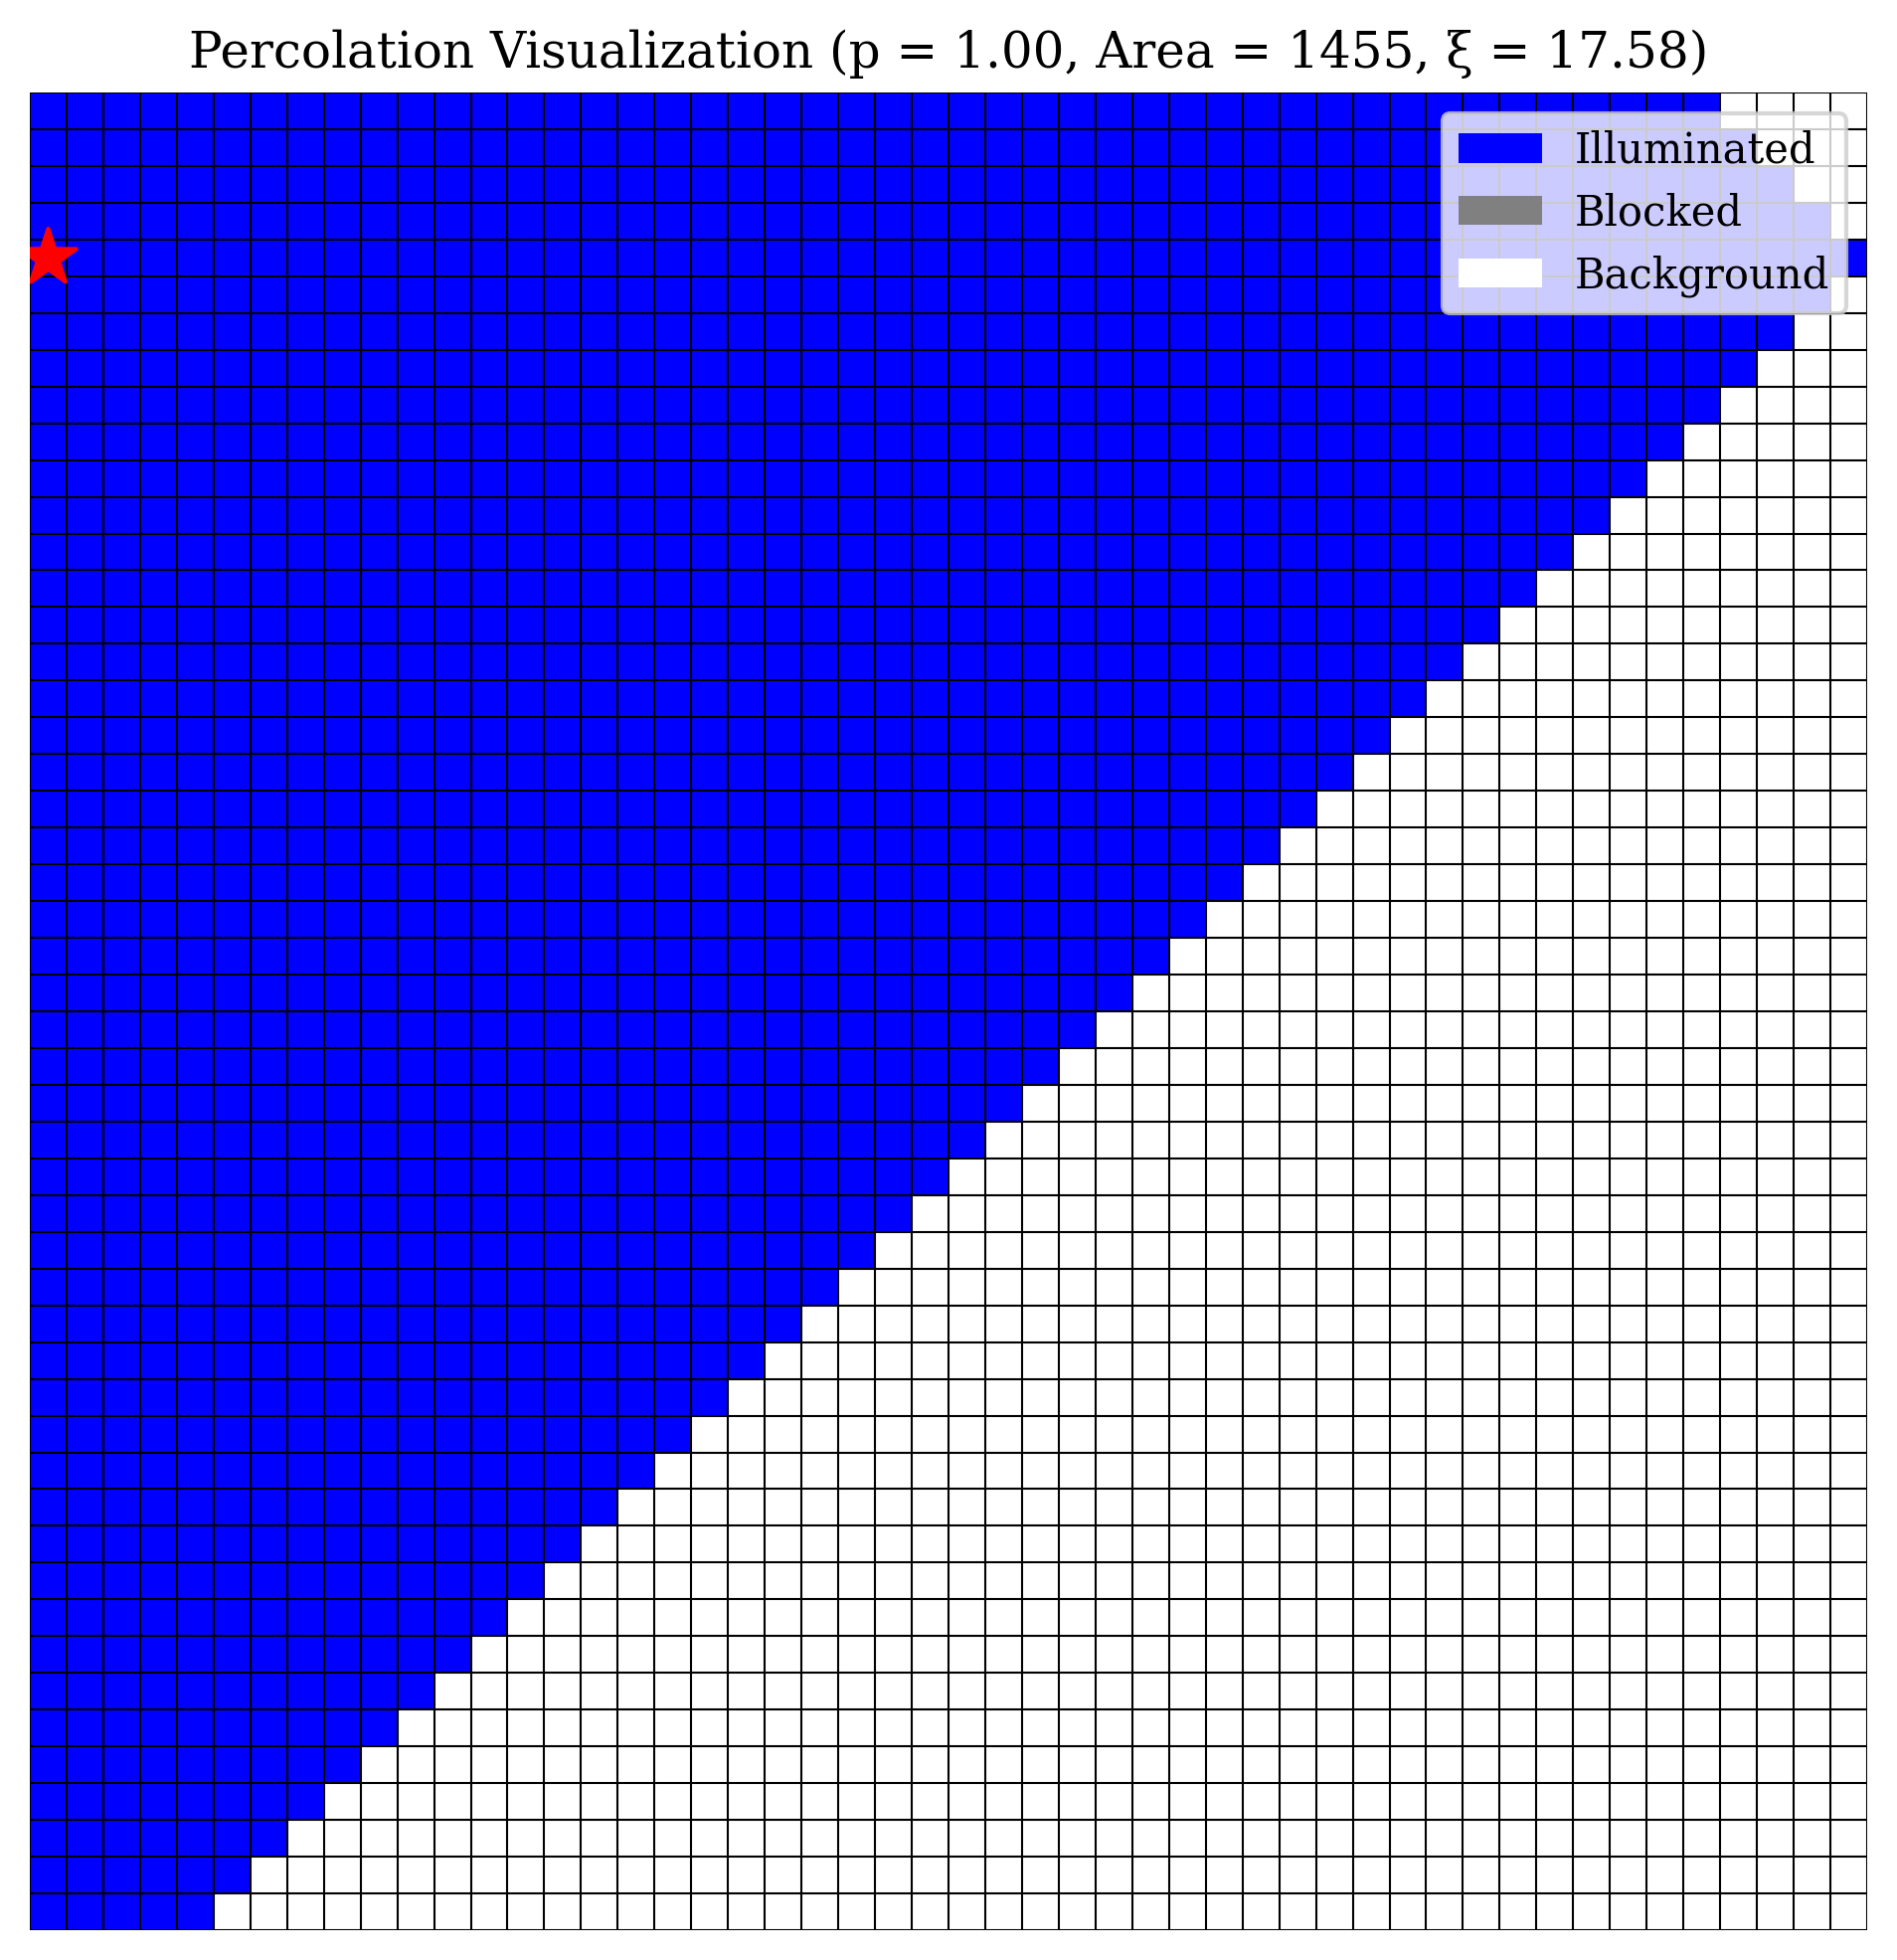

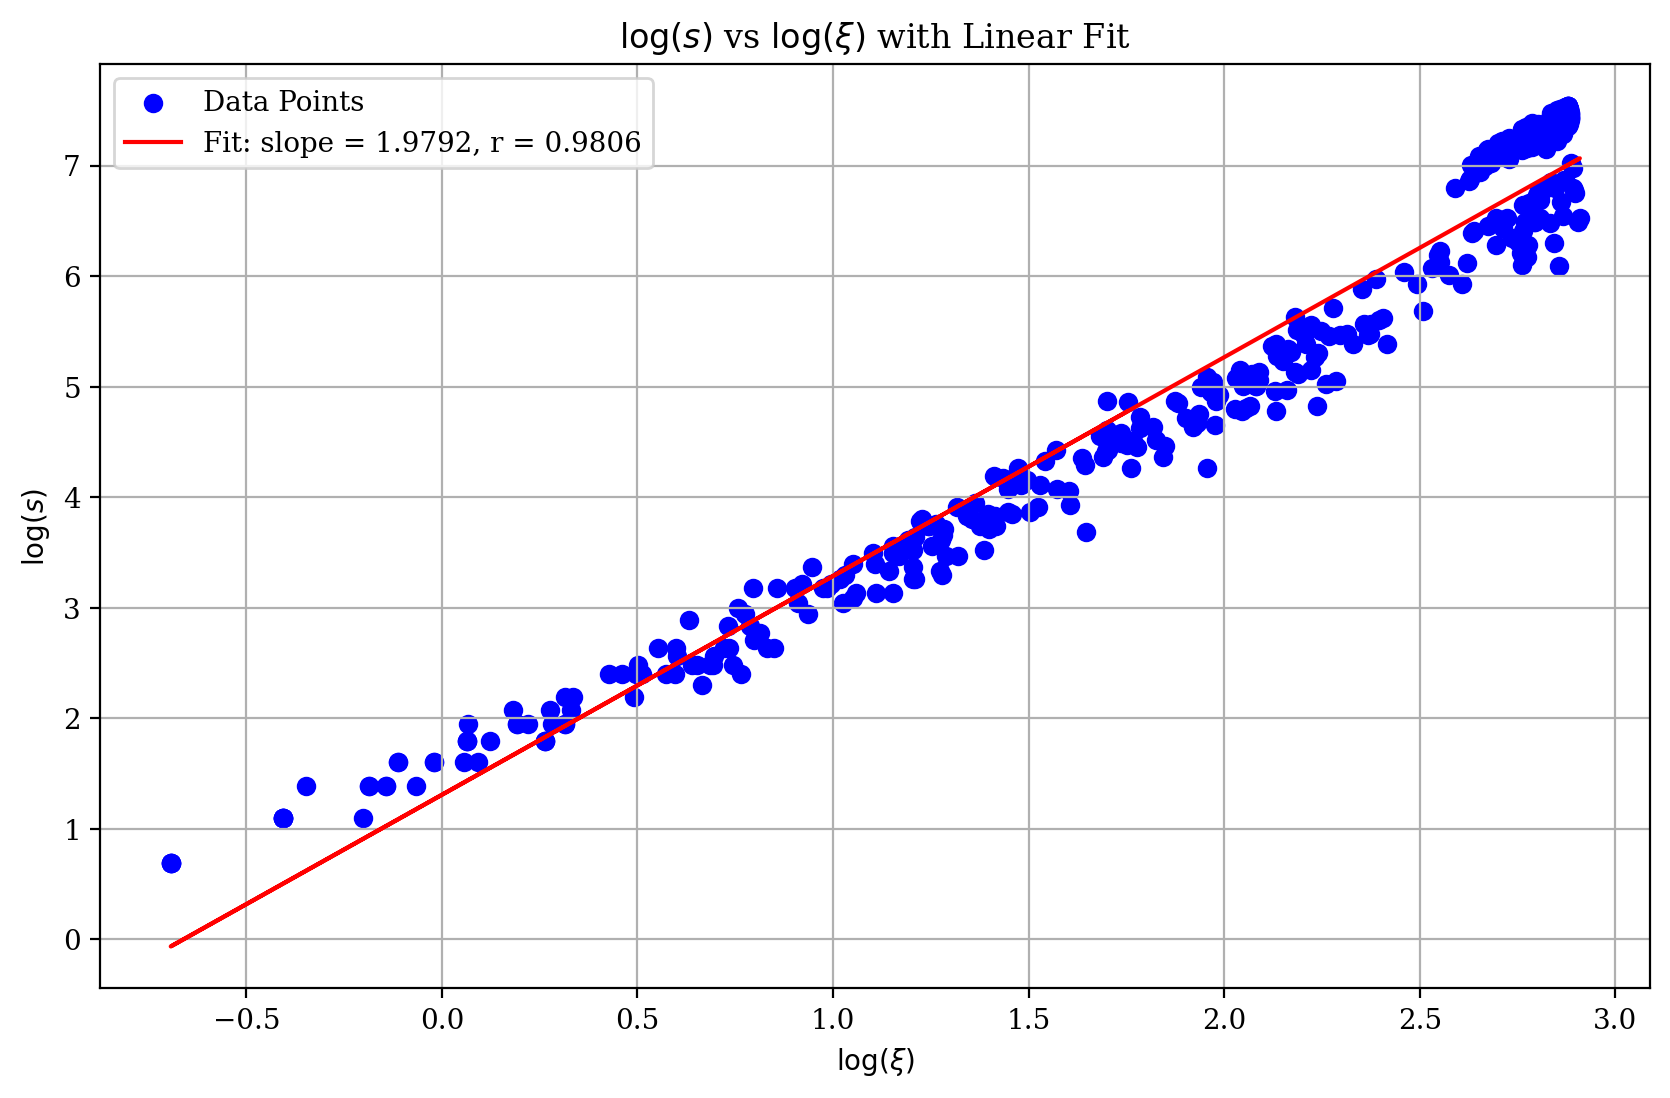

Linear Fit Slope: 1.9792
Correlation Coefficient (r): 0.9806
P-value: 0.0000
Standard Error: 0.0203
A linear fit passes through these points (r > 0.9)
Cluster is blocked at p = 0.50. No new sites to illuminate. Stopping growth.
Animation - Seed: (15, 15)
Rendering frame 1/38
Rendering frame 2/38
Rendering frame 3/38
Rendering frame 4/38
Rendering frame 5/38
Rendering frame 6/38
Rendering frame 7/38
Rendering frame 8/38
Rendering frame 9/38
Rendering frame 10/38
Rendering frame 11/38
Rendering frame 12/38
Rendering frame 13/38
Rendering frame 14/38
Rendering frame 15/38
Rendering frame 16/38
Rendering frame 17/38
Rendering frame 18/38
Rendering frame 19/38
Rendering frame 20/38
Rendering frame 21/38
Rendering frame 22/38
Rendering frame 23/38
Rendering frame 24/38
Rendering frame 25/38
Rendering frame 26/38
Rendering frame 27/38
Rendering frame 28/38
Rendering frame 29/38
Rendering frame 30/38
Rendering frame 31/38
Rendering frame 32/38
Rendering frame 33/38
Rendering frame 34/38
Render

In [ ]:
from scipy.stats import linregress
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Patch
from matplotlib.collections import LineCollection

plt.rc('text', usetex=False)
plt.rc('font', family='serif')

def get_all_neighbors(i, j, m, n):
    neighbors = [
        (i-1, j),
        (i+1, j),
        (i, j-1),
        (i, j+1)
    ]
    return [(ni, nj) for ni, nj in neighbors if 0 <= ni < m and 0 <= nj < n]

def check_percolation(cluster, m, n):
    if not cluster:
        return False
    
    rows = {i for i, j in cluster}
    cols = {j for i, j in cluster}
    
    left_to_right = 0 in cols and (n-1) in cols
    
    #top_to_bottom = 0 in rows and (m-1) in rows
    
    return left_to_right #or top_to_bottom

def generate_percolation_cluster(m, n, p, seed):
    lattice = np.zeros((m, n), dtype=int)
    visited = set()
    cluster = set()
    frontier = {seed}
    visited.add(seed)

    while frontier:
        for i, j in frontier:
            lattice[i, j] = 1
            cluster.add((i, j))

        if check_percolation(cluster, m, n):
            print(f"Percolation detected at p = {p:.2f}. Stopping growth.")
            break

        new_neighbors = set()
        for i, j in frontier:
            neighbors = get_all_neighbors(i, j, m, n)
            for ni, nj in neighbors:
                if (ni, nj) not in visited:
                    new_neighbors.add((ni, nj))
                    visited.add((ni, nj))

        new_neighbors_list = list(new_neighbors)
        np.random.shuffle(new_neighbors_list)
        updates = []
        next_frontier = set()
        for ni, nj in new_neighbors_list:
            if np.random.random() < p:
                updates.append(((ni, nj), 1))
                next_frontier.add((ni, nj))
            else:
                updates.append(((ni, nj), -1))

        for (ni, nj), state in updates:
            lattice[ni, nj] = state

        frontier = next_frontier

        if not frontier:
            print(f"Cluster is blocked at p = {p:.2f}. No new sites to illuminate. Stopping growth.")
            break

    return lattice, cluster

def generate_percolation_cluster_steps(m, n, p, seed):
    lattice = np.zeros((m, n), dtype=int)
    visited = set()
    cluster = set()
    frontier = {seed}
    visited.add(seed)
    frames = [lattice.copy()]

    while frontier:
        for i, j in frontier:
            lattice[i, j] = 1
            cluster.add((i, j))

        frames.append(lattice.copy())

        if check_percolation(cluster, m, n):
            print(f"Percolation detected at p = {p:.2f}. Stopping growth.")
            frames.append(lattice.copy())
            break

        new_neighbors = set()
        for i, j in frontier:
            neighbors = get_all_neighbors(i, j, m, n)
            for ni, nj in neighbors:
                if (ni, nj) not in visited:
                    new_neighbors.add((ni, nj))
                    visited.add((ni, nj))

        new_neighbors_list = list(new_neighbors)
        np.random.shuffle(new_neighbors_list)
        updates = []
        next_frontier = set()
        for ni, nj in new_neighbors_list:
            if np.random.random() < p:
                updates.append(((ni, nj), 1))
                next_frontier.add((ni, nj))
            else:
                updates.append(((ni, nj), -1))

        for (ni, nj), state in updates:
            lattice[ni, nj] = state

        frames.append(lattice.copy())

        frontier = next_frontier

        if not frontier:
            print(f"Cluster is blocked at p = {p:.2f}. No new sites to illuminate. Stopping growth.")
            frames.append(lattice.copy())
            break

    if not frames[-1].tobytes() == lattice.tobytes():
        frames.append(lattice.copy())
    return frames, cluster

def calculate_radius_of_gyration(cluster):
    if not cluster:
        return 0.0
    indices = np.array(list(cluster))
    if indices.size == 0:
        return 0.0
    x_c = np.mean(indices[:, 0])
    y_c = np.mean(indices[:, 1])
    distances_squared = np.sum((indices - [x_c, y_c]) ** 2, axis=1)
    return np.sqrt(np.mean(distances_squared)) if distances_squared.size > 0 else 0.0

def visualize_percolation(lattice, p, area, xi, seed, title="Percolation Cluster"):
    m, n = lattice.shape
    fig = plt.figure(figsize=(8, 8), dpi=300)
    ax = fig.add_subplot(111)
    
    cmap = plt.cm.colors.ListedColormap(['gray', 'white', 'blue'])
    bounds = [-1.5, -0.5, 0.5, 1.5]
    norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)
    
    ax.imshow(lattice, cmap=cmap, norm=norm, interpolation='nearest', extent=[-0.5, n-0.5, -0.5, m-0.5])
    
    x_edges = np.arange(-0.5, n + 0.5)
    y_edges = np.arange(-0.5, m + 0.5)
    h_lines = np.array([[(-0.5, y), (n-0.5, y)] for y in y_edges])
    v_lines = np.array([[(x, -0.5), (x, m-0.5)] for x in x_edges])
    lines = np.vstack((h_lines, v_lines))
    lc = LineCollection(lines, colors='black', linewidths=0.5)
    ax.add_collection(lc)
    
    print(f"Static Plot - Seed: {seed}")
    if 0 <= seed[0] < m and 0 <= seed[1] < n:
        ax.scatter(seed[1], (m-1) - seed[0], color='red', marker='*', s=200, label='Seed', zorder=20)
    
    ax.axis('off')
    
    ax.set_title(f"{title} (p = {p:.2f}, Area = {area}, ξ = {xi:.2f})", fontsize=12)
    
    legend_elements = [
        Patch(facecolor='blue', edgecolor='none', label='Illuminated'),
        Patch(facecolor='gray', edgecolor='none', label='Blocked'),
        Patch(facecolor='white', edgecolor='none', label='Background')
    ]
    ax.legend(handles=legend_elements, loc='upper right', frameon=True)
    
    ax.set_aspect('equal')
    plt.savefig(f"Percolation_Visualization_p_{p}.png", dpi=300, bbox_inches='tight')

    plt.show()

def visualize_percolation_frame(lattice, p, area, xi, seed, title="Percolation Cluster Growth"):
    m, n = lattice.shape
    fig = plt.figure(figsize=(6, 6), dpi=100)
    ax = fig.add_subplot(111)
    
    cmap = plt.cm.colors.ListedColormap(['gray', 'white', 'blue'])
    bounds = [-1.5, -0.5, 0.5, 1.5]
    norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)
    
    im = ax.imshow(lattice, cmap=cmap, norm=norm, interpolation='nearest', extent=[-0.5, n-0.5, -0.5, m-0.5])
    
    x_edges = np.arange(-0.5, n + 0.5)
    y_edges = np.arange(-0.5, m + 0.5)
    h_lines = np.array([[(-0.5, y), (n-0.5, y)] for y in y_edges])
    v_lines = np.array([[(x, -0.5), (x, m-0.5)] for x in x_edges])
    lines = np.vstack((h_lines, v_lines))
    lc = LineCollection(lines, colors='black', linewidths=0.5)
    ax.add_collection(lc)
    
    print(f"Animation - Seed: {seed}")
    if 0 <= seed[0] < m and 0 <= seed[1] < n:
        ax.scatter(seed[1], (m-1) - seed[0], color='red', marker='*', s=100, label='Seed', zorder=20)
    
    ax.axis('off')
    
    ax.set_title(f"{title} (p = {p:.2f}, Area = {area}, ξ = {xi:.2f})", fontsize=10)
    
    legend_elements = [
        Patch(facecolor='blue', edgecolor='none', label='Illuminated'),
        Patch(facecolor='gray', edgecolor='none', label='Blocked'),
        Patch(facecolor='white', edgecolor='none', label='Background')
    ]
    ax.legend(handles=legend_elements, loc='upper right', frameon=True, fontsize=8)
    
    ax.set_aspect('equal')
    return fig, ax, im

m, n = 50, 50
p_values = [0.5, 0.55, 0.59, 1]
num_samples = 100
areas = []
xi_values = []
lattices = []
seeds = []

np.random.seed(42)
for p in p_values:
    for i in range(num_samples):
        seed = (np.random.randint(0, m), np.random.randint(0, n))
        lattice, cluster = generate_percolation_cluster(m, n, p, seed)
        area = len(cluster)
        xi = calculate_radius_of_gyration(cluster)
        areas.append(area)
        xi_values.append(xi)
        lattices.append(lattice)
        seeds.append(seed)
        print(f"p = {p:.2f}, Sample {i+1}, Area = {area}, xi = {xi:.4f}, Seed = {seed}")

for i, p in enumerate(p_values):
    idx = i * num_samples
    visualize_percolation(lattices[idx], p, areas[idx], xi_values[idx], seeds[idx], title="Percolation Visualization")

areas = np.array(areas)
xi_values = np.array(xi_values)
mask = (areas > 0) & (xi_values > 0)
log_s = np.log(areas[mask])
log_xi = np.log(xi_values[mask])

if len(log_s) > 1 and len(np.unique(log_s)) > 1:
    fig = plt.figure(figsize=(10, 6), dpi=200, facecolor='white')
    ax = fig.add_subplot(111)
    ax.set_facecolor('white')
    ax.scatter(log_xi, log_s, color='b', label='Data Points')
    
    slope, intercept, r_value, p_value, std_err = linregress(log_xi, log_s)
    fit_line = slope * log_xi + intercept
    ax.plot(log_xi, fit_line, 'r-', label=f'Fit: slope = {slope:.4f}, r = {r_value:.4f}')
    
    ax.set_xlabel(r'$\log(\xi)$')
    ax.set_ylabel(r'$\log(s)$')
    ax.set_title(r'$\log(s)$ vs $\log(\xi)$ with Linear Fit')
    ax.legend()
    ax.grid(True)
    plt.savefig(f"log(s)vslog(xi).png", dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Linear Fit Slope: {slope:.4f}")
    print(f"Correlation Coefficient (r): {r_value:.4f}")
    print(f"P-value: {p_value:.4f}")
    print(f"Standard Error: {std_err:.4f}")
    if abs(r_value) > 0.9:
        print("A linear fit passes through these points (r > 0.9)")
    else:
        print("A linear fit does not strongly pass through these points (r ≤ 0.9)")
else:
    print("Insufficient variation in log(s) for linear regression")

m, n = 30, 30
seed = (m//2, n//2)
for p in p_values:
    np.random.seed(42)
    frames, cluster = generate_percolation_cluster_steps(m, n, p, seed)
    area = len(cluster)
    xi = calculate_radius_of_gyration(cluster)

    fig, ax, im = visualize_percolation_frame(frames[0], p, area, xi, seed, title=f"Percolation Growth (p = {p:.2f})")

    def update(frame):
        im.set_array(frame)
        return [im]

    ani = FuncAnimation(fig, update, frames=frames, interval=100, blit=True, repeat=False)

    filename = f'percolation_growth_p{p:.2f}.mp4'
    ani.save(filename, writer='ffmpeg', dpi=100, progress_callback=lambda i, n: print(f'Rendering frame {i+1}/{n}'))
    plt.close()
    print(f"Animation saved as '{filename}'. Open with a media player.")

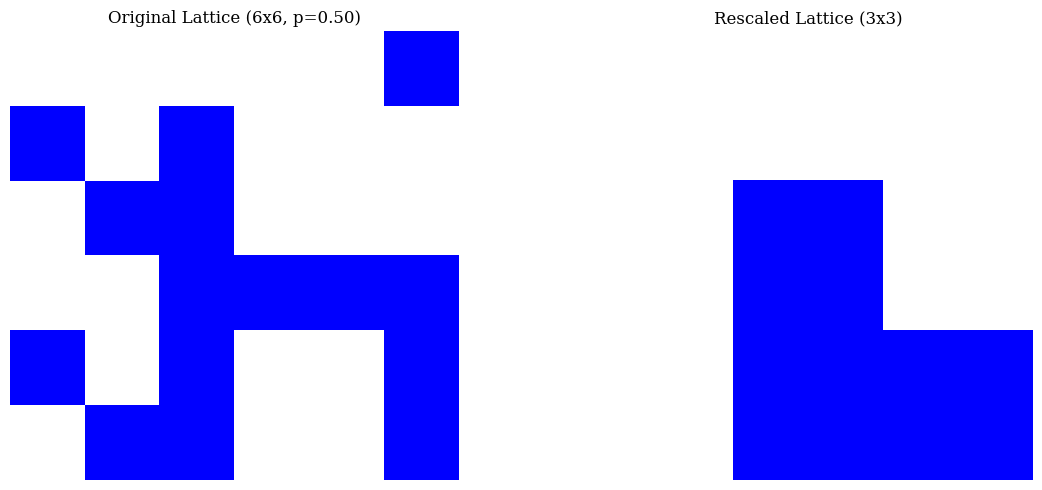

Original lattice percolates vertically: False


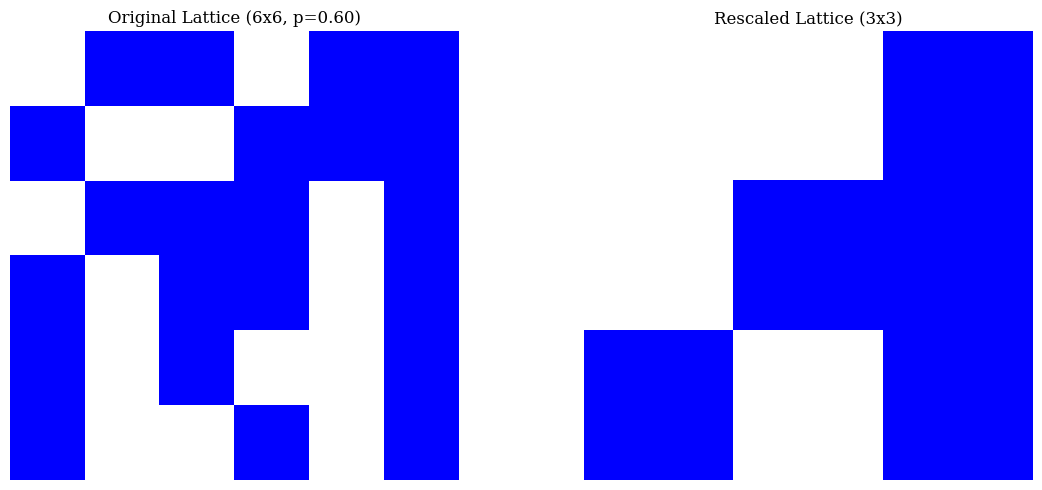

Original lattice percolates vertically: True


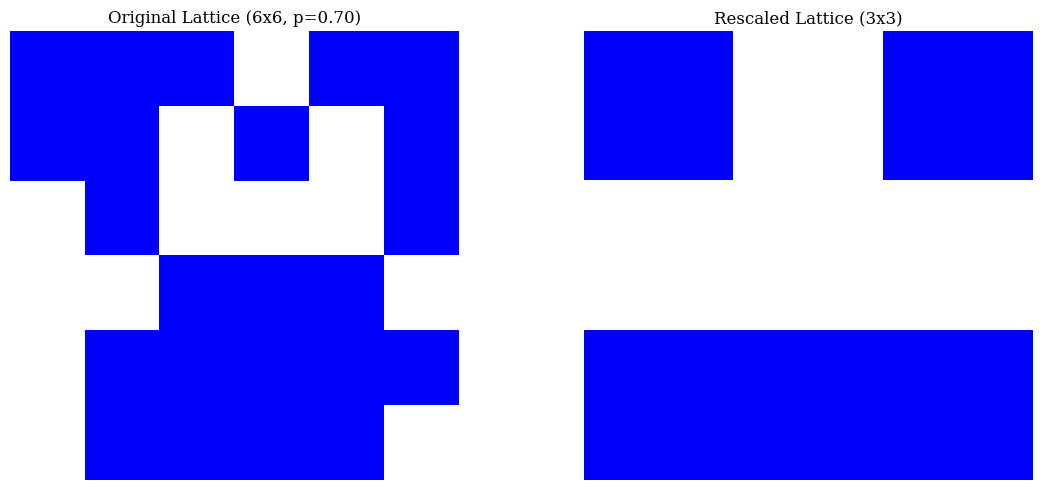

Original lattice percolates vertically: False


In [ ]:
def generate_lattice(m, n, p):
    return np.random.rand(m, n) < p

def check_block_percolation_vertical(block):
    m, n = block.shape
    visited = np.zeros_like(block, dtype=bool)
    queue = deque()
    
    for j in range(n):
        if block[0, j]:
            queue.append((0, j))
            visited[0, j] = True
    
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    
    while queue:
        x, y = queue.popleft()
        if x == m - 1:
            return True
        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            if 0 <= nx < m and 0 <= ny < n:
                if block[nx, ny] and not visited[nx, ny]:
                    visited[nx, ny] = True
                    queue.append((nx, ny))
    return False

def apply_renormalization(lattice, block_m, block_n):
    m, n = lattice.shape
    if m % block_m != 0 or n % block_n != 0:
        raise ValueError(f"Lattice dimensions must be divisible by block size ({block_m}x{block_n})")
    
    m_new = m // block_m
    n_new = n // block_n
    rescaled = np.zeros((m_new, n_new), dtype=int)
    
    for i in range(0, m, block_m):
        for j in range(0, n, block_n):
            block = lattice[i:i+block_m, j:j+block_n]
            rescaled[i//block_m, j//block_n] = 1 if check_block_percolation_vertical(block) else 0
    
    return rescaled

def visualize_lattices(original, rescaled, p, m, n, block_m, block_n, save_figure=False, dpi=300):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    cmap = plt.cm.colors.ListedColormap(['white', 'blue'])
    
    ax1.imshow(original, cmap=cmap, interpolation='nearest', vmin=0, vmax=1)
    ax1.set_title(f'Original Lattice ({m}x{n}, p={p:.2f})')
    ax1.axis('off')
    
    ax2.imshow(rescaled, cmap=cmap, interpolation='nearest', vmin=0, vmax=1)
    ax2.set_title(f'Rescaled Lattice ({m//block_m}x{n//block_n})')
    ax2.axis('off')
    
    plt.tight_layout()
    
    if save_figure:
        filename = f'lattice_p_{p:.2f}_block_{block_m}x{block_n}_dpi_{dpi}.png'
        plt.savefig(filename, dpi=dpi, bbox_inches='tight')
    
    plt.show()

m, n = 6, 6
block_m = 2
block_n = 2
p_values = [0.5, 0.6, 0.7]

if m % block_m != 0 or n % block_n != 0:
    raise ValueError(f"6x6 lattice must be divisible by {block_m}x{block_n} blocks")

for p in p_values:
    lattice = generate_lattice(m, n, p)
    rescaled = apply_renormalization(lattice, block_m, block_n)
    
    visualize_lattices(lattice, rescaled, p, m, n, block_m, block_n, save_figure=True, dpi=300)

    labels, _ = coloring_algorithm(lattice)
    top = labels[0, :]
    bottom = labels[-1, :]
    original_percolates = np.any(np.isin(top[top > 0], bottom[bottom > 0]))
    print(f"Original lattice percolates vertically: {original_percolates}")

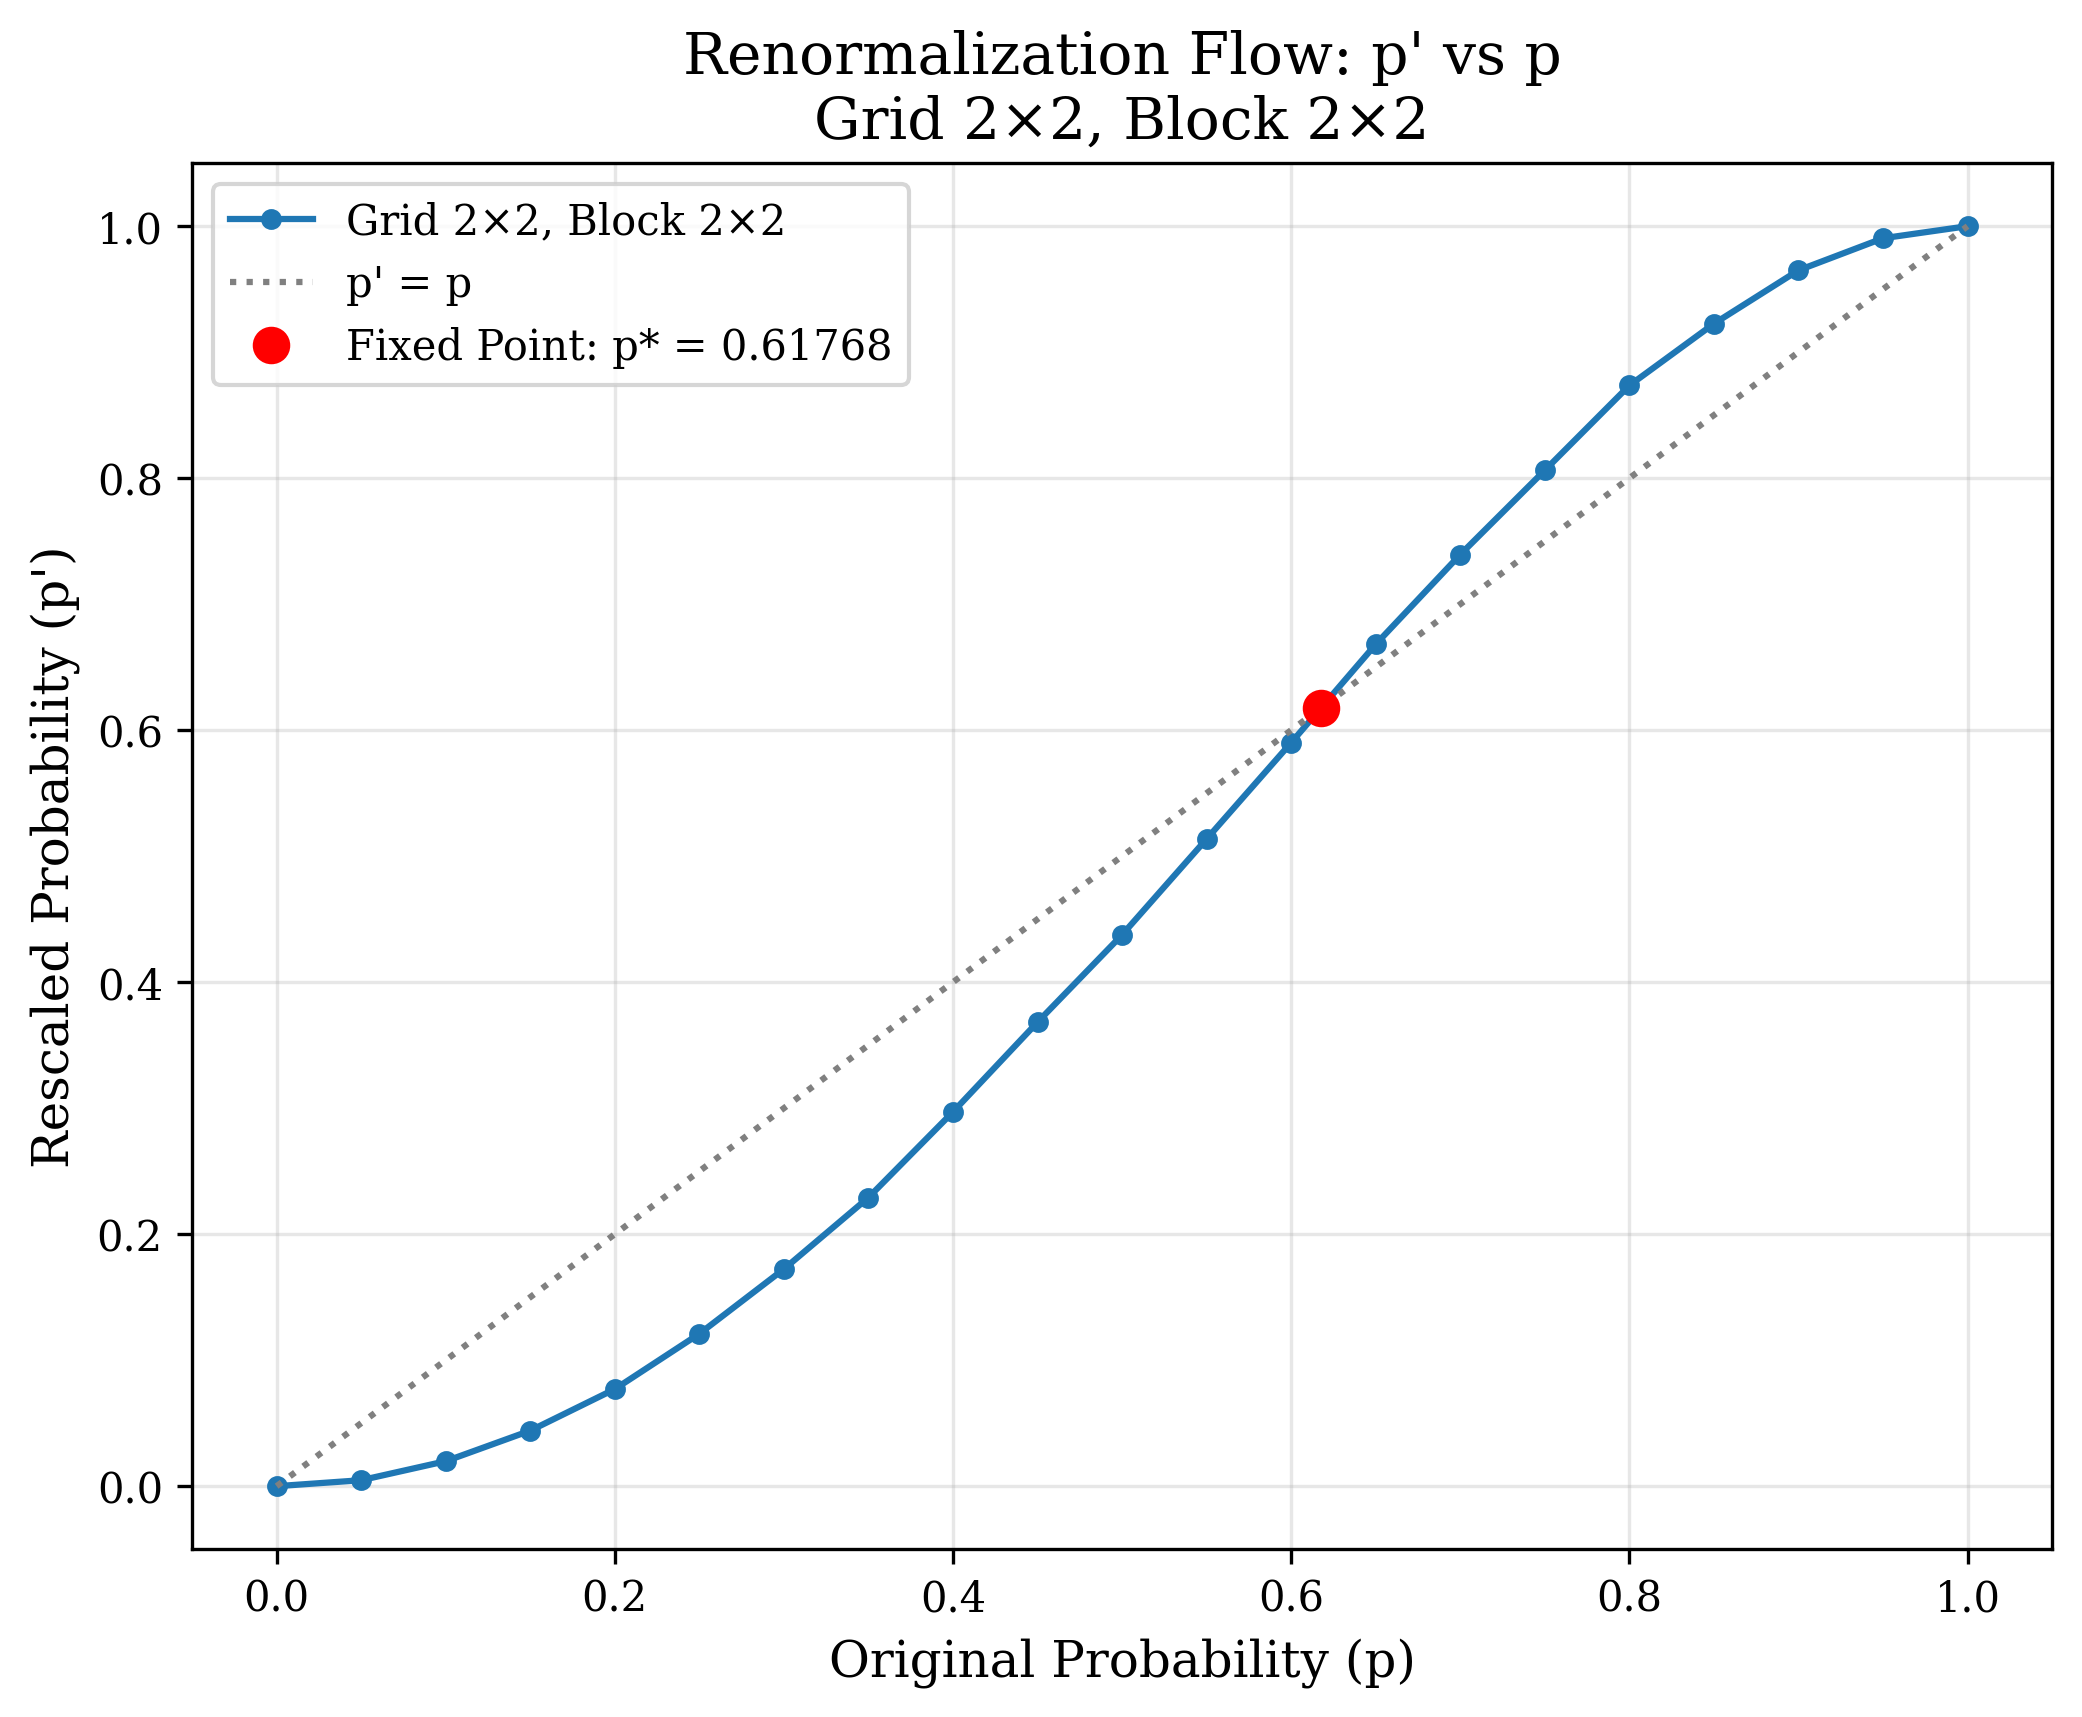


Critical points for Grid 2×2, Block 2×2: [np.float64(0.618)]


In [ ]:
def simulate_p_prime(p, grid_size, block_size, num_samples=10000):
    grid_m, grid_n = grid_size
    block_m, block_n = block_size
    
    if grid_m % block_m != 0 or grid_n % block_n != 0:
        raise ValueError(f"Grid dimensions must be divisible by block size ({block_m}x{block_n})")
    
    percolation_count = 0
    for _ in range(num_samples):
        grid = (np.random.rand(grid_m, grid_n) < p).astype(int)
        rescaled_grid = apply_renormalization(grid, block_size)
        if np.any(rescaled_grid == 1):
            percolation_count += 1
            
    return percolation_count / num_samples

def plot_p_prime_vs_p(grid_size, block_size, num_points=21, num_samples=50000):
    p_values = np.linspace(0, 1, num_points)
    p_prime_sim = []
    
    for p in p_values:
        p_prime = simulate_p_prime(p, grid_size, block_size, num_samples)
        p_prime_sim.append(p_prime)
    
    plt.figure(figsize=(8, 6), dpi=300)
    plt.plot(p_values, p_prime_sim, 'o-', markersize=4, label=f'Grid {grid_size[0]}×{grid_size[1]}, Block {block_size[0]}×{block_size[1]}')
    plt.plot([0, 1], [0, 1], 'gray', linestyle=':', label='p\' = p')
    
    crossings = []
    for i in range(len(p_values)-1):
        if (p_prime_sim[i] - p_values[i]) * (p_prime_sim[i+1] - p_values[i+1]) < 0:
            x1, x2 = p_values[i], p_values[i+1]
            y1, y2 = p_prime_sim[i] - x1, p_prime_sim[i+1] - x2
            root = x1 - y1*(x2 - x1)/(y2 - y1)
            crossings.append(round(root, 3))
            plt.plot(root, root, 'ro', markersize=8, label=f'Fixed Point: p* = {root:.5}')
    
    plt.xlabel('Original Probability (p)', fontsize=12)
    plt.ylabel('Rescaled Probability (p\')', fontsize=12)
    plt.title(f'Renormalization Flow: p\' vs p\nGrid {grid_size[0]}×{grid_size[1]}, Block {block_size[0]}×{block_size[1]}', fontsize=14)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.savefig(f'Renormalization_Flow_pp_vs_p_Grid_{grid_size[0]}_{grid_size[1]}_Block_{block_size[0]}_{block_size[1]}', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nCritical points for Grid {grid_size[0]}×{grid_size[1]}, Block {block_size[0]}×{block_size[1]}:", crossings)


grid_m = 2
grid_n = 2
block_m = 2
block_n = 2
grid_size = (grid_m, grid_n)
block_size = (block_m, block_n)

if grid_m % block_m != 0 or grid_n % block_n != 0:
    raise ValueError(f"Grid dimensions must be divisible by block size ({block_m}x{block_n})")

plot_p_prime_vs_p(grid_size, block_size, num_samples=50000)

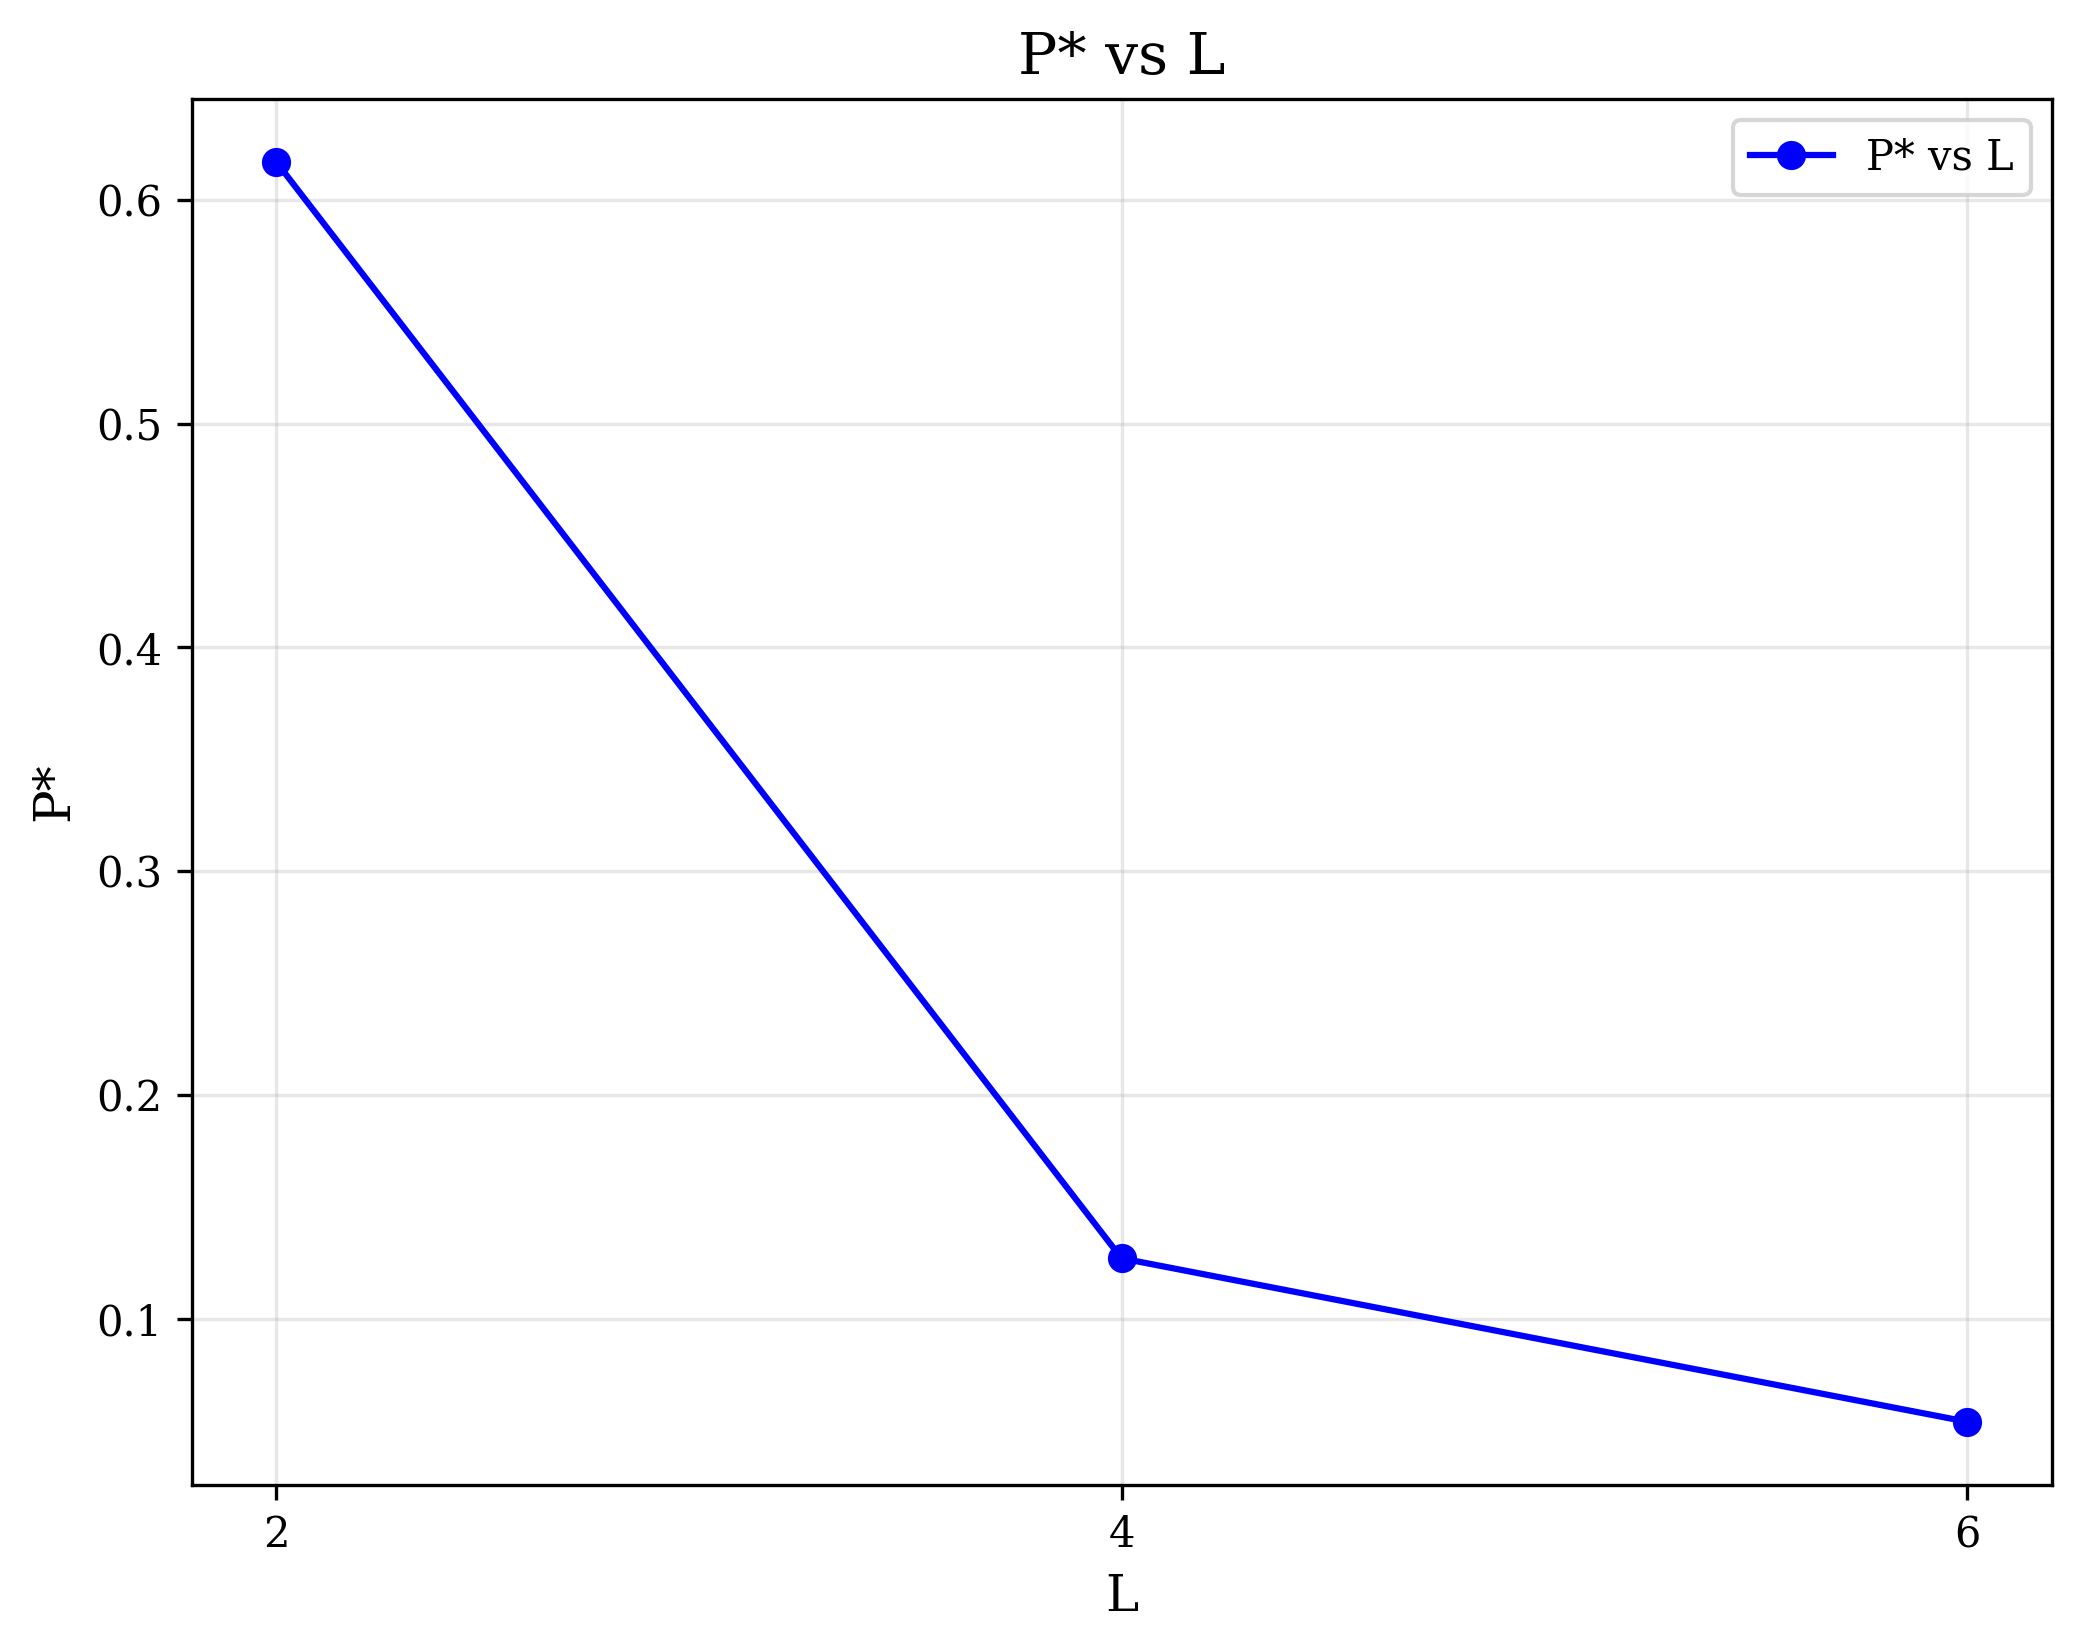

In [716]:
L = [2, 4, 6]
P_star = [0.617, 0.127, 0.054]

plt.figure(figsize=(8, 6), dpi=300)
plt.plot(L, P_star, marker='o', linestyle='-', color='b', label='P* vs L')
plt.xlabel('L', fontsize=12)
plt.ylabel('P*', fontsize=12)
plt.title('P* vs L', fontsize=14)
plt.xticks(L)
plt.grid(True, alpha=0.3)
plt.legend()
plt.savefig("P_star_vs_L.png", dpi=300, bbox_inches='tight')
plt.show()


Original grid (p=0.40, 2x2):
[[0 0]
 [1 0]]
Rescaled grid (1x1):
[[0]]

Original grid (p=0.60, 2x2):
[[0 1]
 [1 1]]
Rescaled grid (1x1):
[[1]]

Original grid (p=0.80, 2x2):
[[1 1]
 [0 1]]
Rescaled grid (1x1):
[[1]]


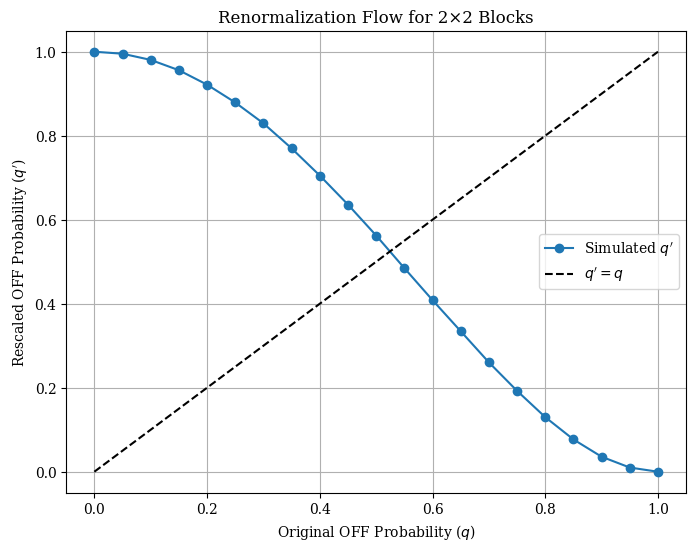


Critical points q* for 2x2 blocks: [np.float64(0.524)]
Equivalent p* = 1 - q*: [np.float64(0.476)]


In [ ]:
def check_block_percolation_vertical(block):
    m, n = block.shape
    visited = np.zeros((m, n), dtype=bool)
    queue = deque()
    
    for j in range(n):
        if block[0, j] == 1:
            queue.append((0, j))
            visited[0, j] = True
    
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    while queue:
        x, y = queue.popleft()
        if x == m - 1:
            return True
        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            if 0 <= nx < m and 0 <= ny < n and not visited[nx, ny] and block[nx, ny] == 1:
                visited[nx, ny] = True
                queue.append((nx, ny))
    return False

def apply_renormalization(grid, block_m=2, block_n=2):
    m, n = grid.shape
    if m % block_m != 0 or n % block_n != 0:
        raise ValueError(f"Grid dimensions must be divisible by block size ({block_m}x{block_n})")
    
    m_new = m // block_m
    n_new = n // block_n
    rescaled = np.zeros((m_new, n_new), dtype=int)
    
    for i in range(0, m, block_m):
        for j in range(0, n, block_n):
            block = grid[i:i+block_m, j:j+block_n]
            rescaled[i//block_m, j//block_n] = 1 if check_block_percolation_vertical(block) else 0
    
    return rescaled

def simulate_off_probability(q, block_m=2, block_n=2, num_samples=10000):
    off_count = 0
    for _ in range(num_samples):
        block = (np.random.rand(block_m, block_n) > (1 - q)).astype(int)
        if not check_block_percolation_vertical(block):
            off_count += 1
    return off_count / num_samples

def find_intersection_points(q_values, q_primes):
    crossings = []
    for i in range(1, len(q_values)):
        x1, x2 = q_values[i-1], q_values[i]
        y1, y2 = q_primes[i-1] - x1, q_primes[i] - x2
        
        if y1 * y2 < 0:
            denominator = y2 - y1
            if abs(denominator) > 1e-6:
                x_intercept = x1 - y1*(x2 - x1)/denominator
                crossings.append(x_intercept)
                
        elif abs(y1) < 1e-6:
            crossings.append(x1)
        elif abs(y2) < 1e-6:
            crossings.append(x2)
    
    return sorted(list(set(round(x, 3) for x in crossings)))

m, n = 2, 2
block_m, block_n = 2, 2
p_values = [0.4, 0.6, 0.8]

for p in p_values:
    grid = generate_grid(m, n, p)
    rescaled_grid = apply_renormalization(grid, block_m, block_n)
    
    print(f"\nOriginal grid (p={p:.2f}, {m}x{n}):")
    print(grid)
    print(f"Rescaled grid ({m//block_m}x{n//block_n}):")
    print(rescaled_grid)
    
q_values = np.linspace(0, 1, 21)
q_primes = [simulate_off_probability(q, block_m=2, block_n=2, num_samples=100000) for q in q_values]

plt.figure(figsize=(8, 6))
plt.plot(q_values, q_primes, 'o-', label="Simulated $q'$")
plt.plot(q_values, q_values, 'k--', label="$q' = q$")
plt.xlabel("Original OFF Probability ($q$)")
plt.ylabel("Rescaled OFF Probability ($q'$)")
plt.title(f"Renormalization Flow for {block_m}×{block_n} Blocks")
plt.legend()
plt.grid(True)
plt.show()

crossings = find_intersection_points(q_values, q_primes)
print(f"\nCritical points q* for {block_m}x{block_n} blocks:", crossings)
print(f"Equivalent p* = 1 - q*:", [round(1 - q, 3) for q in crossings])